<a href="https://colab.research.google.com/github/tvelagapudi/deblender/blob/master/MAGAN/lenstronomy_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade https://github.com/sibirrer/lenstronomy/tarball/master
!pip install --upgrade https://github.com/sibirrer/fastell4py/tarball/master
!pip install CosmoHammer
!pip install astropy
!pip install dynesty
!pip install pymultinest
!pip install pypolychord
!pip install nestcheck
!pip install corner
!pip install aplpy

from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
import lenstronomy.Util.image_util as image_util
from lenstronomy.Plots.output_plots import ModelPlot
from lenstronomy.Data.psf import PSF
import copy
import numpy as np
import math
import matplotlib.pyplot as plt
import sys
%matplotlib inline

     | 9.1MB 2.3MB/s
  Created wheel for lenstronomy: filename=lenstronomy-1.0.1-cp36-none-any.whl size=5964256 sha256=ffd9fcae8a115af447d5404935302a1f90ad4b7b1dfe154bc573906d50b12bf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-76r5dd02/wheels/2e/10/78/35e130916344104a501432d1042633eea6c63f71cf31abcace
Successfully built lenstronomy
     - 174kB 1.4MB/s
  Created wheel for fastell4py: filename=fastell4py-0.1.0-cp36-cp36m-linux_x86_64.whl size=199256 sha256=def6770e1620d63d5273ea7d7d17c4a9dd4ae0ec2377bdea6f5dca1972105ccb
  Stored in directory: /tmp/pip-ephem-wheel-cache-jw3q5_qn/wheels/b8/11/8a/51038ecb6be0b8ab795b372c4b952a05b9e87c3ce42c56404f
Successfully built fastell4py
     |████████████████████████████████| 51kB 2.4MB/s 
     |████████████████████████████████| 61kB 24.4MB/s 
  Created wheel for CosmoHammer: filename=cosmoHammer-0.6.1-cp36-none-any.whl size=54236 sha256=0cf75a1150417864f6d87aeaece4cd9374e6f179a715bbe8d5770b963e86f5f3
  Stored in directory: /root/.cache/pip/wh

In [0]:
 class Simlens:
  sis_center_x = 0
  sis_center_y = 0
  theta_ra = 0
  theta_dec = 0
  q = 1. # axis ratio q=1 is a spherical lens
  phi = 0
  phi_gamma = 0
  gamma = 0
  redshift_list = []
  z_souce = 0
  spep_e1 = 0
  spep_e2 = 0
  spep_gamma = 0
  spep_center_x = 0
  spep_center_y = 0
  shear_gamma_ext = 0
  shear_psi_ext = 0

  def __init__(self, sis_center_x, sis_center_y, theta_ra, theta_dec, q, phi, gamma, phi_gamma, redshift_list, z_source, spep_e1, spep_e2, spep_gamma, spep_center_x, spep_center_y, shear_gamma_ext, shear_psi_ext):
    self.sis_center_x = sis_center_x
    self.sis_center_y = sis_center_y
    self.theta_ra = theta_ra
    self.theta_dec = theta_dec
    self.q = q
    self.phi = phi
    self.phi_gamma = phi_gamma
    self.gamma = gamma
    self.redshift_list.clear()
    self.redshift_list.extend(redshift_list)
    self.z_source = z_source
    self.spep_e1 = spep_e1
    self.spep_e2 = spep_e2
    self.spep_gamma = spep_gamma
    self.spep_center_x = spep_center_x
    self.spep_center_y = spep_center_y
    self.shear_gamma_ext = shear_gamma_ext
    self.shear_psi_ext = shear_psi_ext

  def image_gen(self, sis_theta_E, spep_theta_E):
    # specify the choice of lens models #
    lens_model_list = ['SPEP', 'SIS', 'SHEAR_GAMMA_PSI']

    # setup lens model class with the list of lens models #
    lensModel = LensModel(lens_model_list=lens_model_list)

    # define parameter values of lens models #
    kwargs_spep = {'theta_E': spep_theta_E, 'e1': self.spep_e1, 'e2': self.spep_e2, 'gamma': self.spep_gamma, 'center_x': self.spep_center_x, 'center_y': self.spep_center_y}
    kwargs_shear = {'gamma_ext': self.shear_gamma_ext, 'psi_ext': self.shear_psi_ext}
    kwargs_sis = {'theta_E': sis_theta_E, 'center_x': self.sis_center_x, 'center_y': self.sis_center_y}
    kwargs_lens = [kwargs_spep, kwargs_sis, kwargs_shear]

    
    # setup lens model class with the list of lens models #
    lensModel_mp = LensModel(lens_model_list=lens_model_list, z_source=self.z_source, lens_redshift_list=self.redshift_list, multi_plane=True)

    # set up the list of light models to be used #
    source_light_model_list = ['SERSIC']
    lightModel_source = LightModel(light_model_list=source_light_model_list)
    lens_light_model_list = ['SERSIC_ELLIPSE']
    lightModel_lens = LightModel(light_model_list=lens_light_model_list)
    beta_ra, beta_dec = 0, 0.21
    # define the parameters #
    kwargs_light_source = [{'amp': 500, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]
    e1, e2 = param_util.phi_q2_ellipticity(phi=self.phi, q=self.q)
    kwargs_light_lens = [{'amp': 10000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}]

    # evaluate surface brightness at a specific position #
    flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)


    # unlensed source positon #
    point_source_model_list = ['SOURCE_POSITION']
    pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel_mp, fixed_magnification_list=[True])
    kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 1000}]
    # return image positions and amplitudes #
    x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
    point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)



    deltaPix = 0.05 * 100/28  # size of pixel in angular coordinates #

    # setup the keyword arguments to create the Data() class #
    ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
    kwargs_pixel = {'nx': 28, 'ny': 28,  # number of pixels per axis
                    'ra_at_xy_0': ra_at_xy_0,  
                    'dec_at_xy_0': dec_at_xy_0,
                    'transform_pix2angle': transform_pix2angle} 
    pixel_grid = PixelGrid(**kwargs_pixel)


    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.1, 'pixel_size': deltaPix}
    psf = PSF(**kwargs_psf)


    # define the numerics #
    kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                      'supersampling_convolution': False}
    # initialize the Image model class by combining the modules we created above #
    imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                            source_model_class=lightModel_source,
                            lens_light_model_class=lightModel_lens,
                            point_source_class=pointSource, 
                            kwargs_numerics=kwargs_numerics)
    # simulate image with the parameters we have defined above #
    image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                             kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

    # we can also add noise #
    exp_time = 100  # exposure time to quantify the Poisson noise level
    background_rms = 0.01  # background rms value
    poisson = image_util.add_poisson(image, exp_time=exp_time)
    bkg = image_util.add_background(image, sigma_bkd=background_rms)
    image_noisy = image + bkg + poisson
    return image_noisy


[0.5, 0.5, 0.1]
0
1.0526144938027606


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


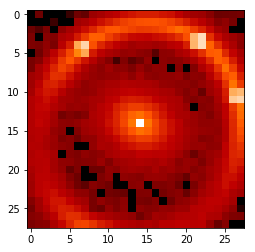

1
0.7382164584887748


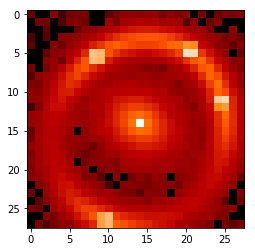

2
0.9518636828625728


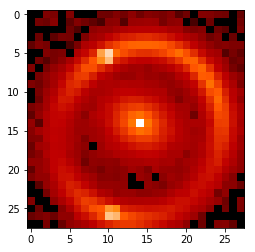

3
2.027284955972118


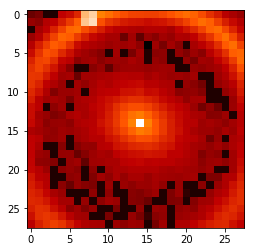

4
1.134043001703111


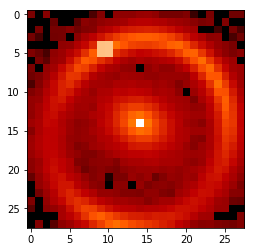

5
1.0870275291286664


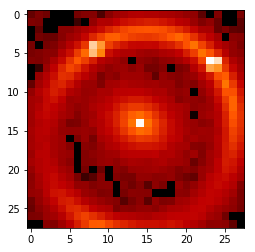

6
1.056527457067175


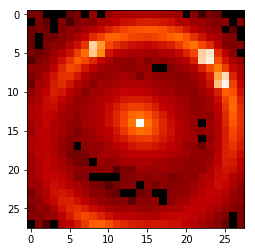

7
0.4812819913433649


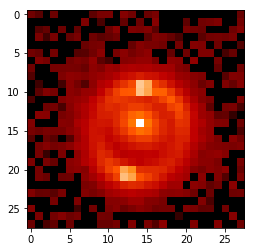

8
0.6074047008950081


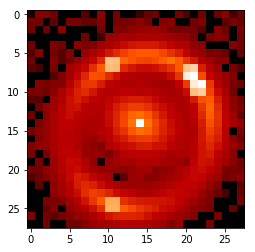

9
1.0420809145638512


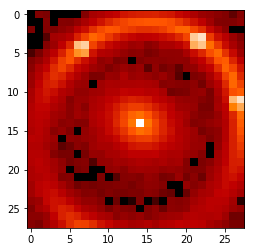

10
1.1698537940365465


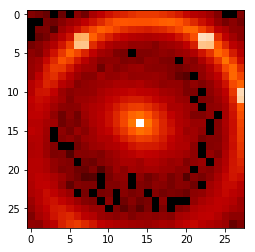

11
1.7356841619106973


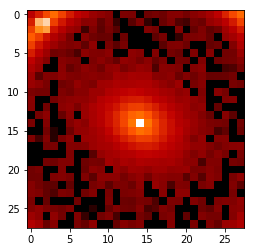

12
1.2516254352171792


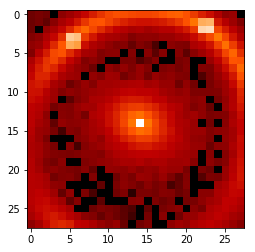

13
0.9436131594720949


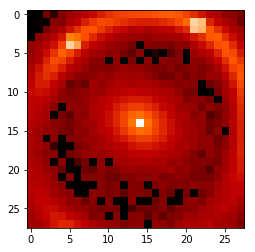

14
1.0467428027957681


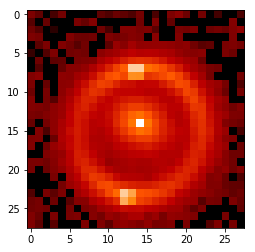

15
1.2417495435413075


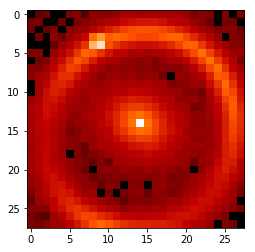

16
1.449248354671954


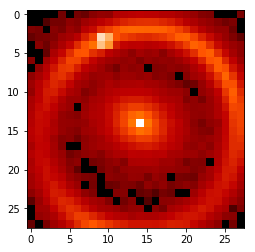

17
1.3015302560359052


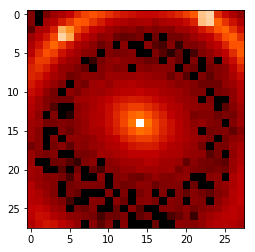

18
1.4522147052469092


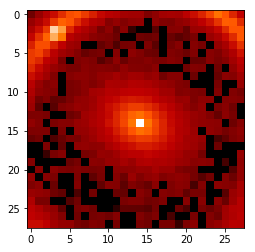

19
1.5733043420231496


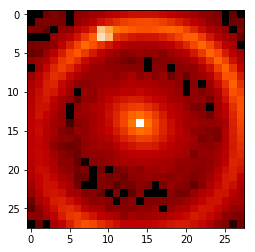

20
1.138082533922656


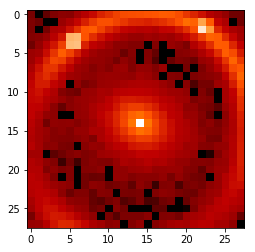

21
1.6932804248609243


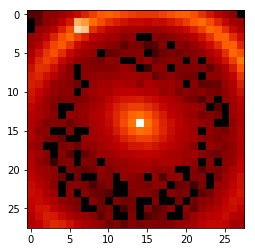

22
1.0265572107312328


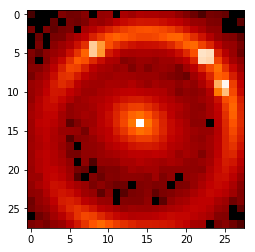

23
1.1712820445005154


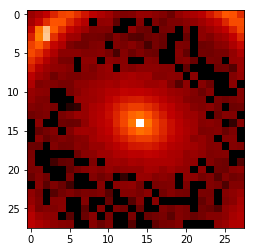

24
1.490904795706505


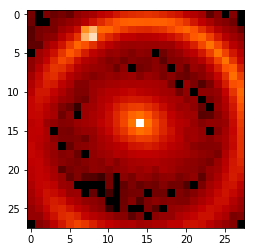

25
1.289881137300874


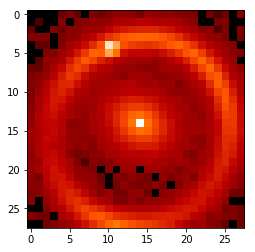

26
1.1865411301419966


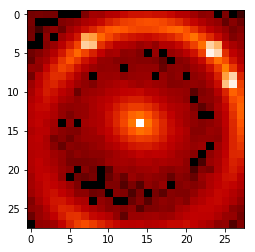

27
1.2358708697646361


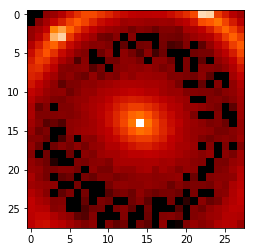

28
1.5060856084947352


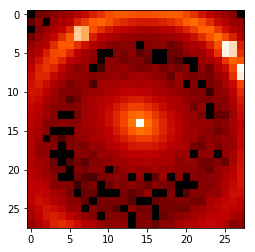

29
0.366533216220582


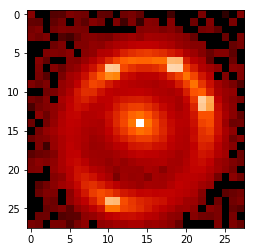

30
0.5434141849045111


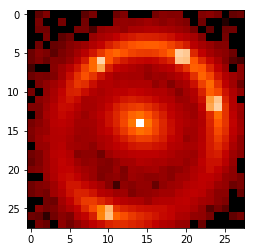

31
1.9116859523645853


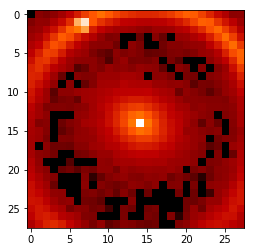

32
0.7453401770601334


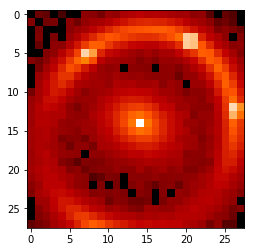

33
1.267420938752659


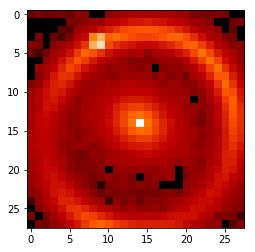

34
1.8412573868734037


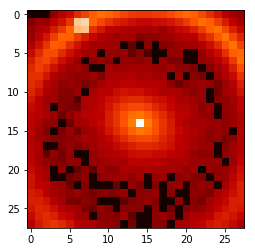

35
1.2011090428085371


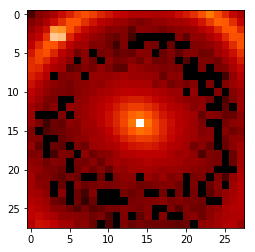

36
1.2444399575766234


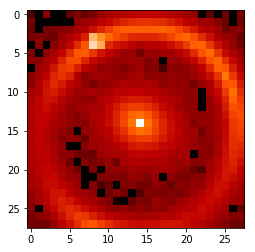

37
0.5154396124809112


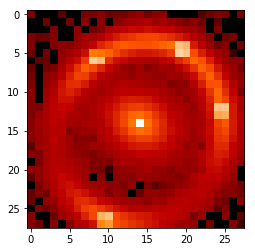

38
1.538741507979087


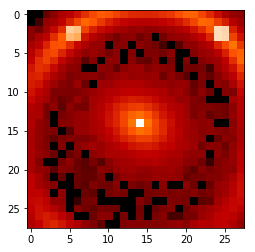

39
1.1306324673644164


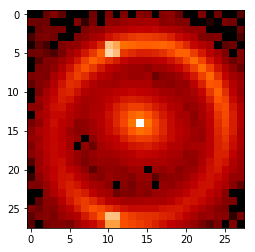

40
1.0332363525654613


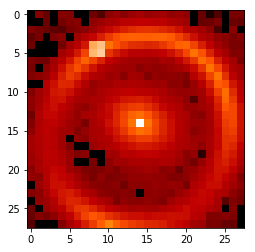

41
1.215861159914102


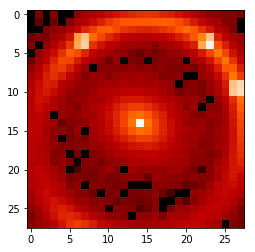

42
1.5005767637420977


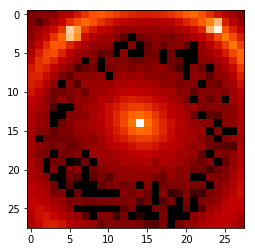

43
1.750340658973496


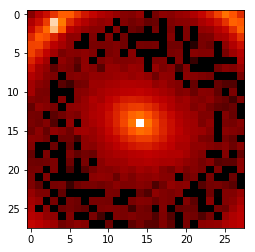

44
1.0479966489882826


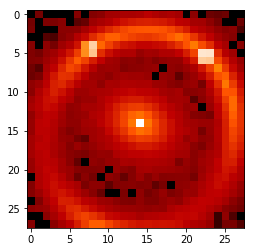

45
0.6330045340121676


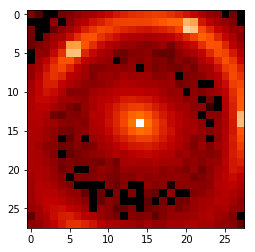

46
1.2814825059668749


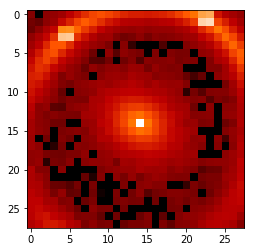

47
0.7373027815766253


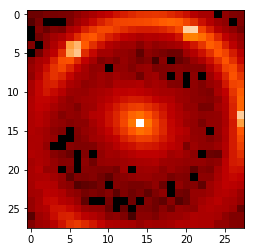

48
1.508151812306566


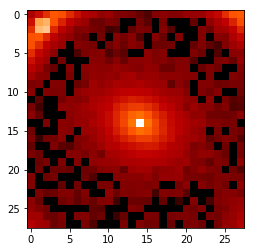

49
1.2005000798708552


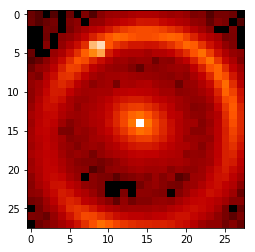

50
1.1534527669067982


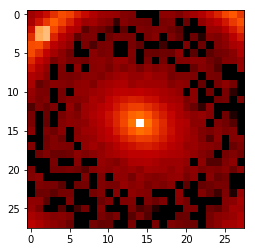

51
1.4393629866186162


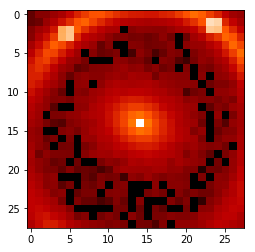

52
0.7641640773141656


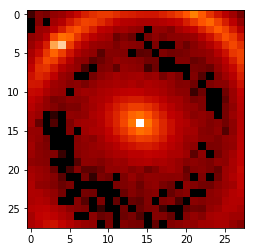

53
1.0882870074647966


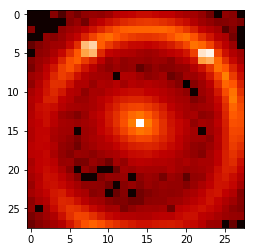

54
1.3416506878181738


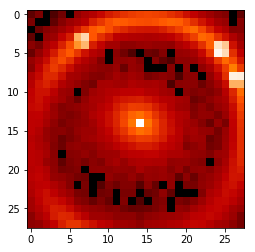

55
1.1133371188215488


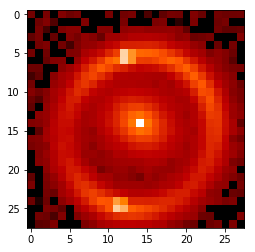

56
1.8518482148929893


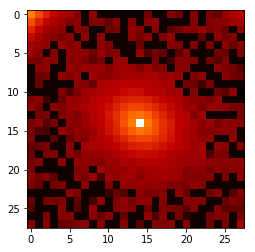

57
1.6567391026352456


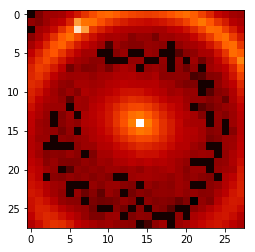

58
1.167245303563233


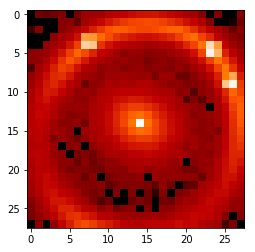

59
0.755317254941769


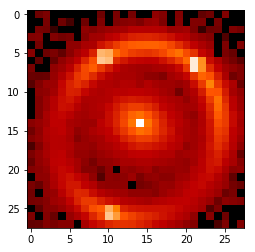

60
0.7817309428423027


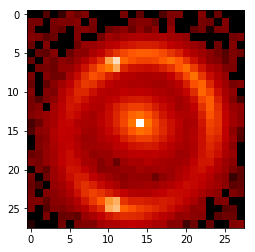

61
1.2294420933926895


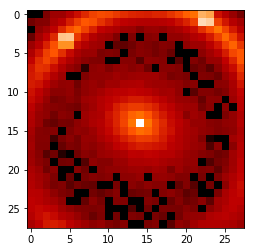

62
1.0401741104914963


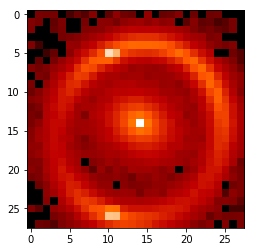

63
1.4078967840957946


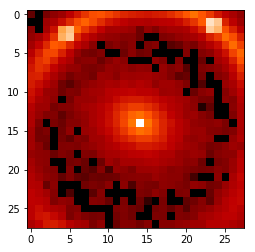

64
1.272737384878873


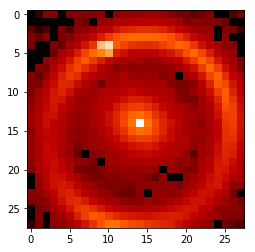

65
1.5603600426296969


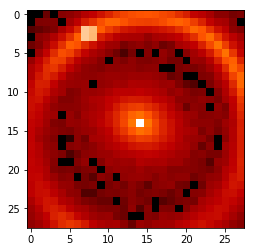

66
0.8677626960139819


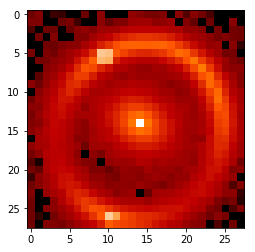

67
1.2298505159141002


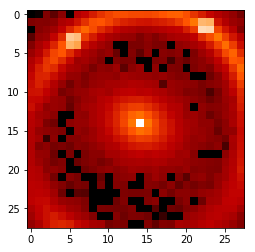

68
1.409554381451482


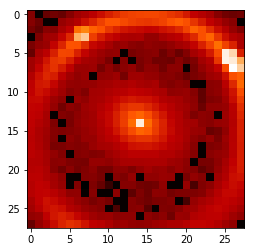

69
1.0412139857329643


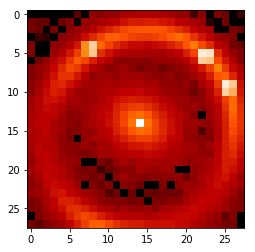

70
1.1523671287416386


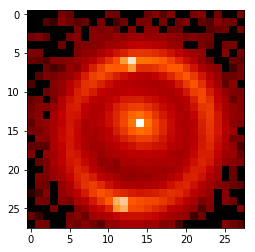

71
1.6223522824156325


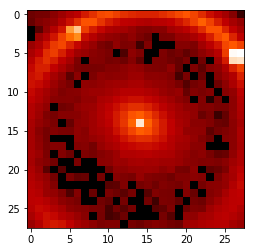

72
1.5173782654759949


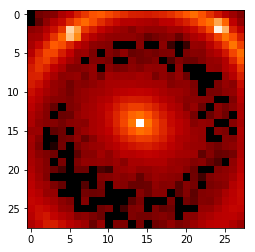

73
1.304803529761913


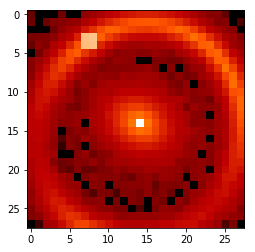

74
1.912210159209859


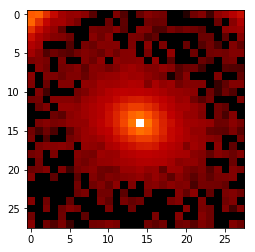

75
1.227302051085456


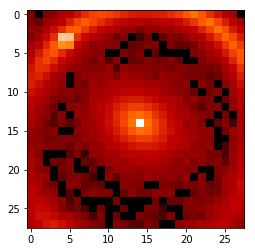

76
1.6287679226398182


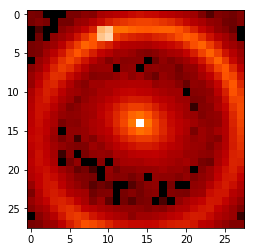

77
0.9734778155724308


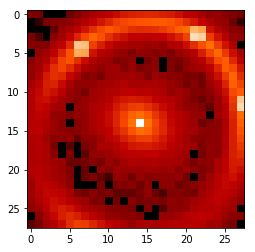

78
0.6455632796738024


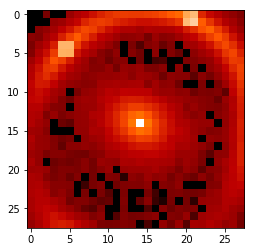

79
0.993129680915526


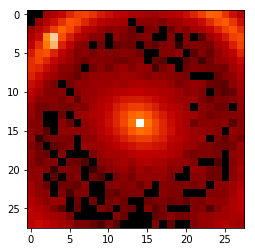

80
1.4551348587079742


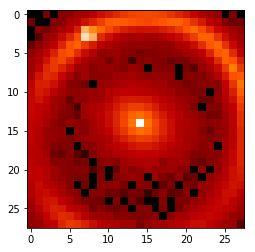

81
1.2860678275295503


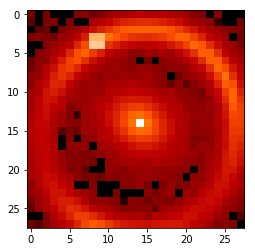

82
0.9651161014250825


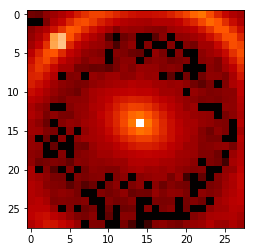

83
0.9515544597792809


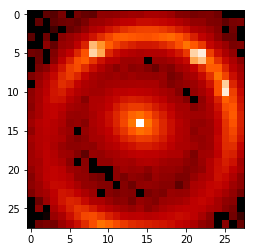

84
1.8714092436655376


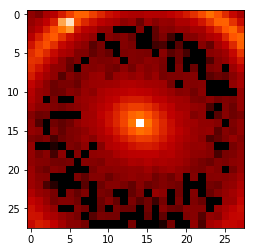

85
1.7922009207382323


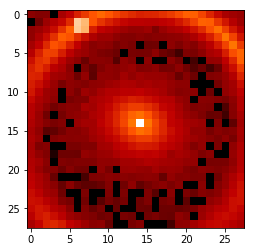

86
1.3206279136703976


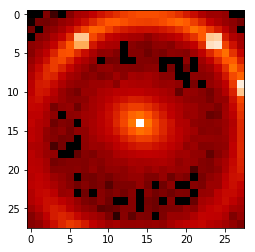

87
0.8149580845040933


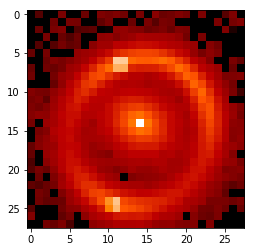

88
0.8715168859665798


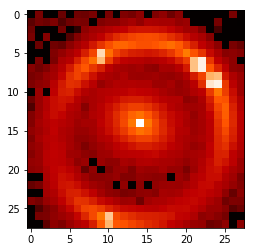

89
0.4448469250618603


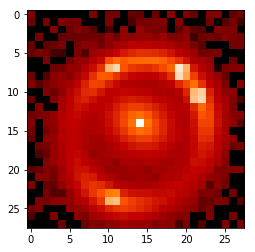

90
0.7076174919120714


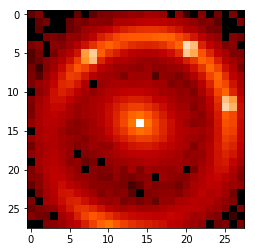

91
1.1019334548170945


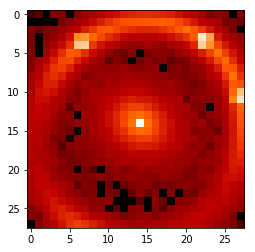

92
1.6552409774182104


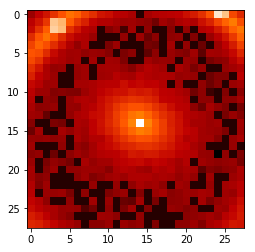

93
0.5974063338176137


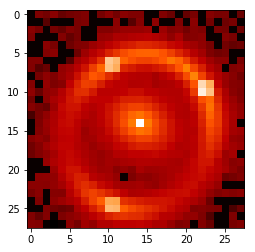

94
0.2529349963166412


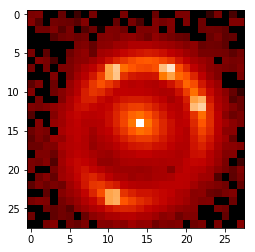

95
1.8515312592723565


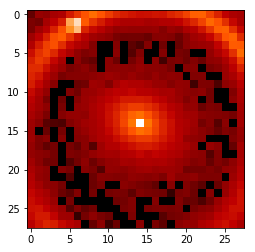

96
1.097861597149992


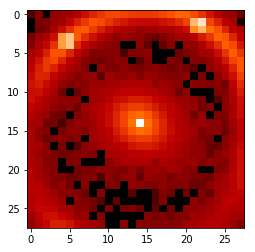

97
0.9610911143867159


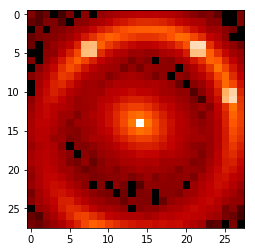

98
1.6417773046737172


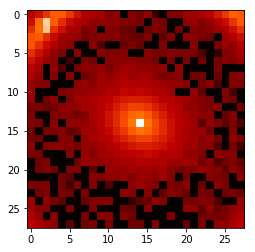

99
1.968411606939139


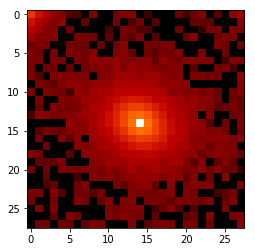

[0.5, 0.5, 0.1]
0
1.3458941179809616


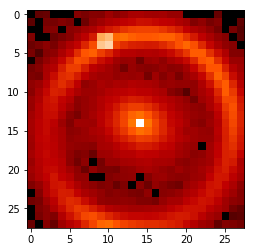

1
0.8460154745630681


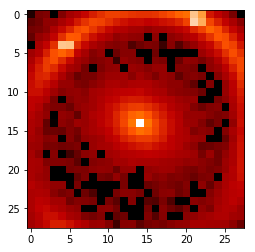

2
0.616900724730573


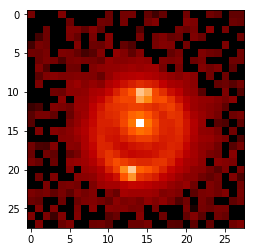

3
1.0941069890932924


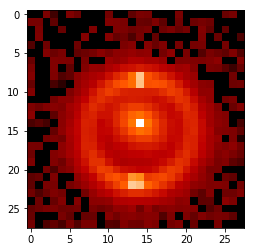

4
0.7741137143342218


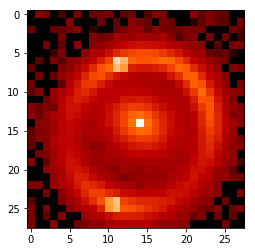

5
1.3685122940388363


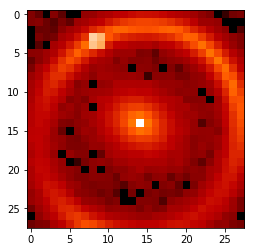

6
1.6165891641734658


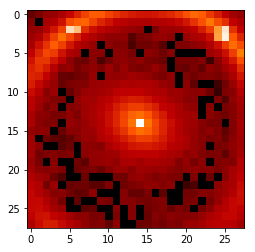

7
0.8518231535224505


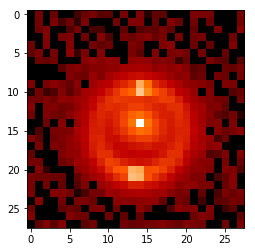

8
1.4299755143927213


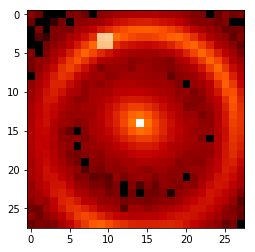

9
0.7647273989904557


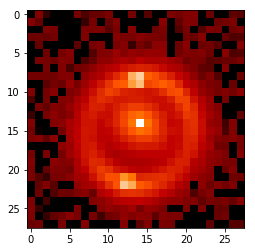

10
1.4270559400578517


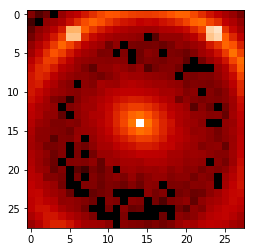

11
0.6783094010407094


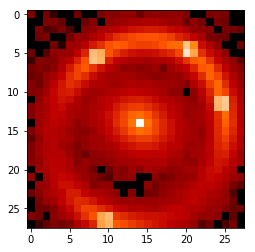

12
1.2191034136814805


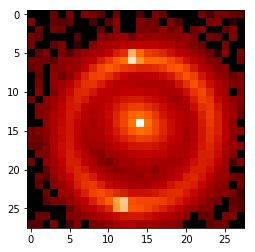

13
1.1166771196960992


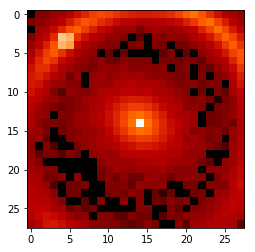

14
1.8649683458657913


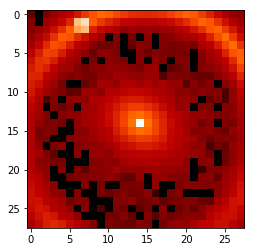

15
1.1681932347749586


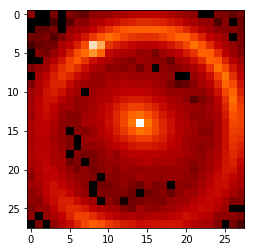

16
0.4887059280047149


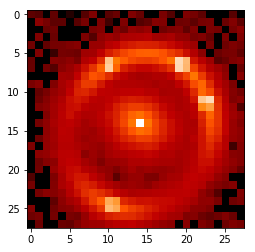

17
0.814334202196815


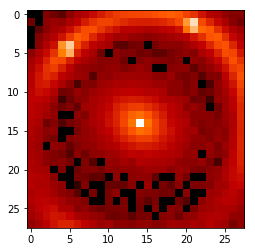

18
0.85110032164171


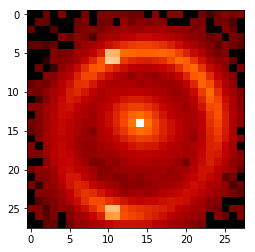

19
1.6564436744677198


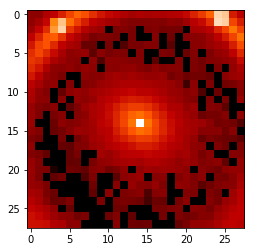

20
1.2180841063455938


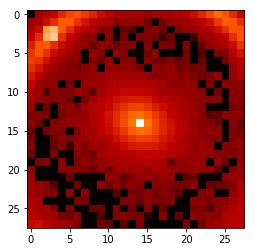

21
2.126147977962389


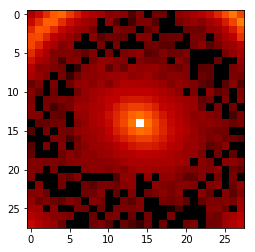

22
0.6892356545618022


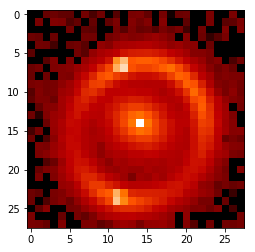

23
1.16824823958525


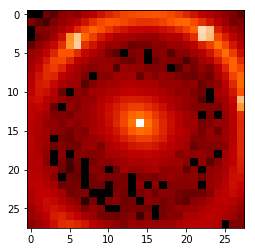

24
2.151392208231017


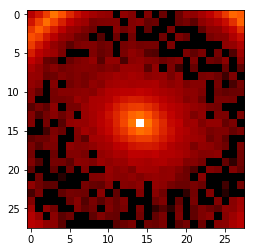

25
0.8595553613452163


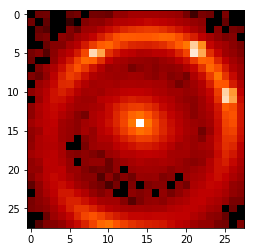

26
1.3424459763064396


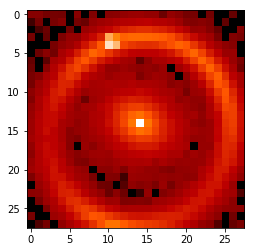

27
1.3915439825032103


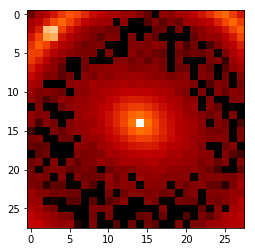

28
0.827807789515235


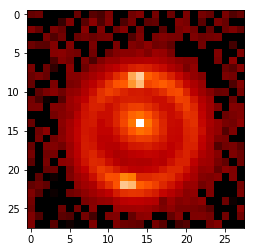

29
2.1314984273859787


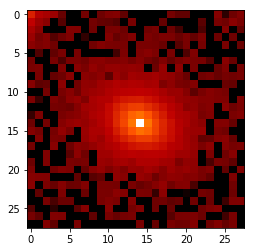

30
0.5039514507107072


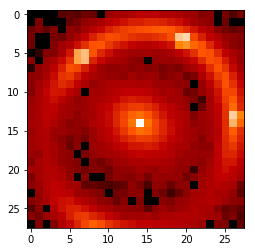

31
1.2991547838480684


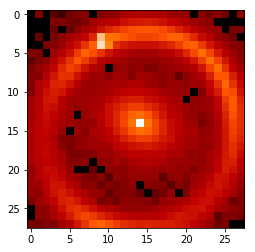

32
0.5838830474855711


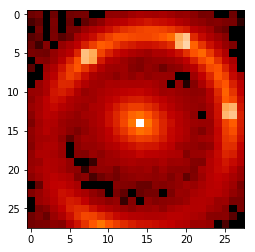

33
1.4629512869742882


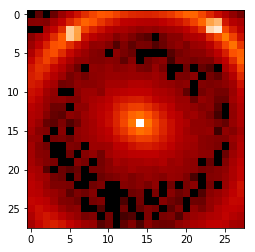

34
1.667455398939973


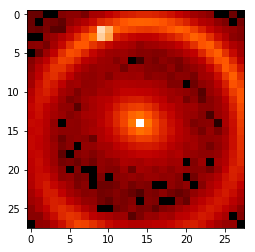

35
1.112519496285148


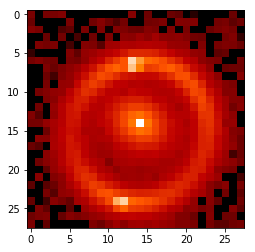

36
0.6859654113306279


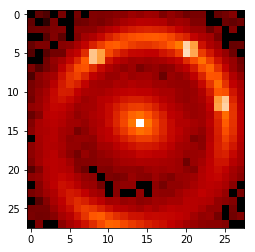

37
1.0993928863862228


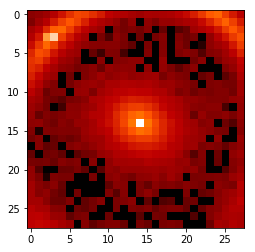

38
1.1656556018284974


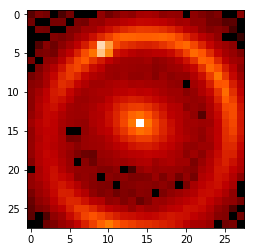

39
1.1685349616441414


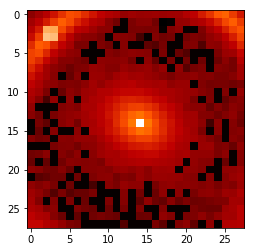

40
1.0777577664972458


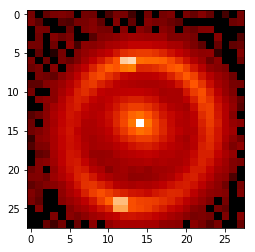

41
1.2450522446696453


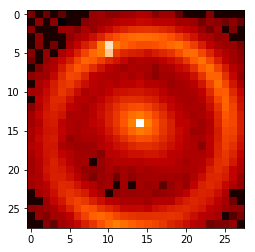

42
1.1590079849723978


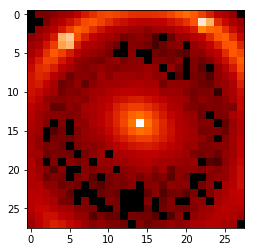

43
1.041969905992277


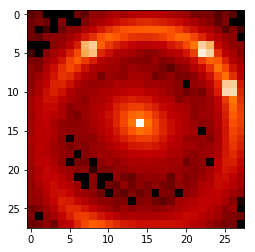

44
2.091983754466864


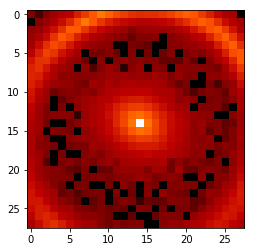

45
0.9216967286874196


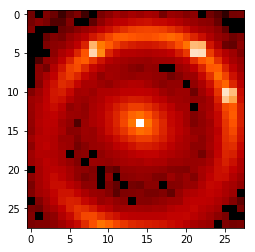

46
1.502741237282799


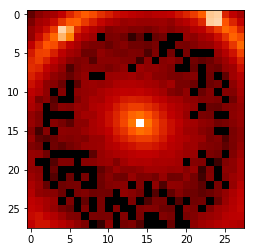

47
1.6385336892737854


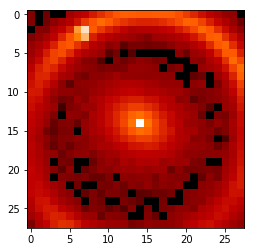

48
1.5870280736471665


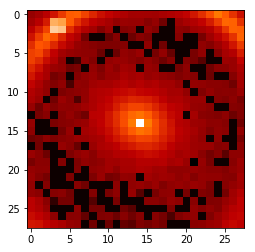

49
1.4670411669304575


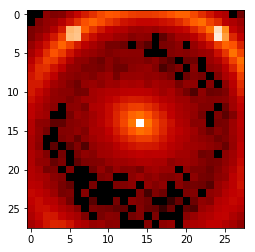

50
0.5523375174695874


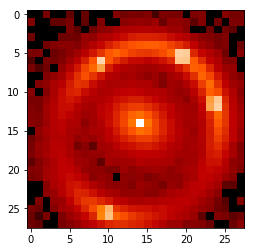

51
0.969879162143537


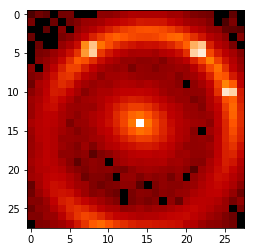

52
1.3430246744293577


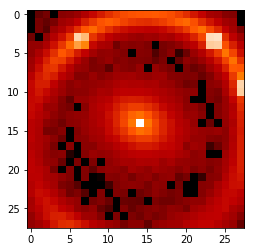

53
2.2347451436090595


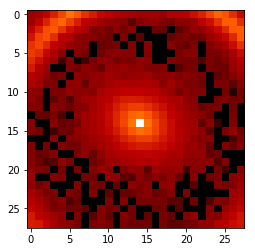

54
1.2478992373044622


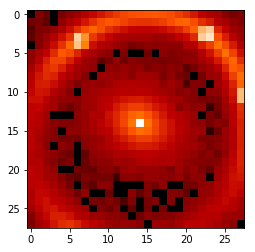

55
1.32233144134499


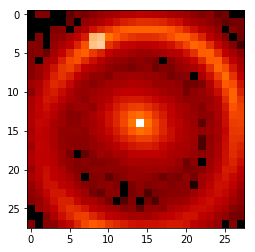

56
1.2304594750054239


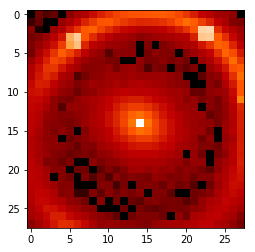

57
1.0011502847812759


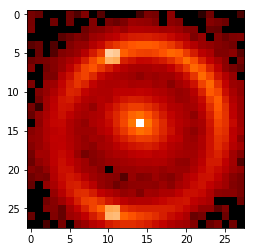

58
1.465718580836119


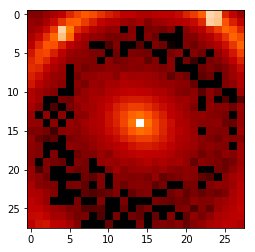

59
1.4313239009169532


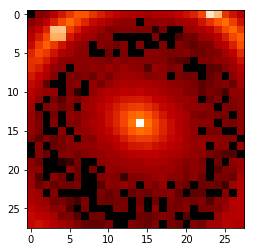

60
1.1179677391316971


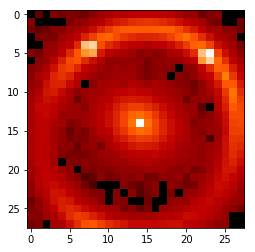

61
1.926964825876522


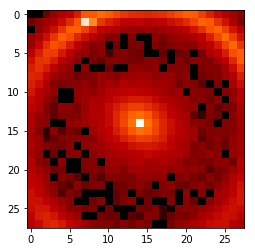

62
1.722722434853994


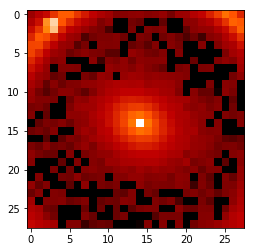

63
1.435796754332982


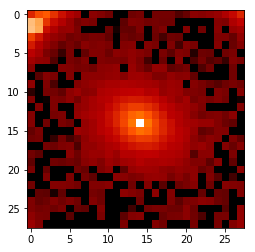

64
0.5487499272128308


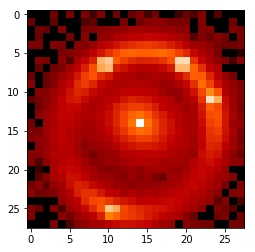

65
0.2683676692342063


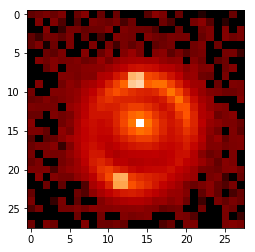

66
1.5734628411290814


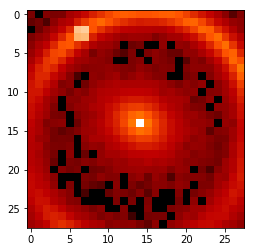

67
0.24611135651136395


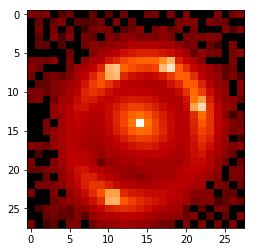

68
1.217598821871333


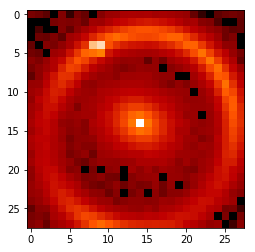

69
1.190720119056037


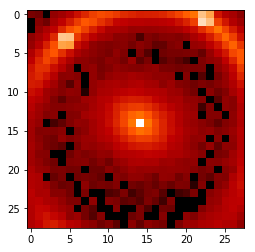

70
1.136140468619837


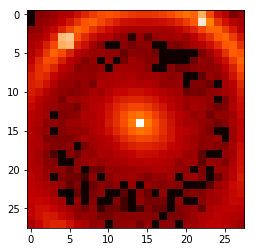

71
1.2310298655413334


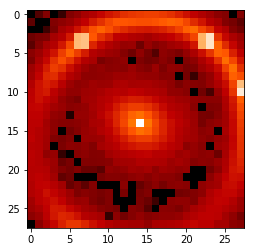

72
0.8235308095954408


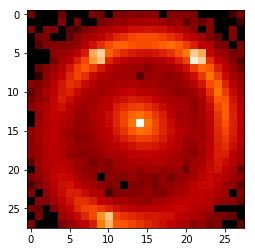

73
1.634933093832343


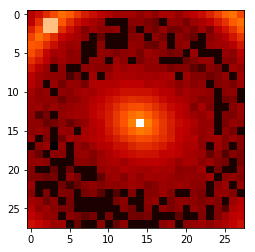

74
1.047327419356792


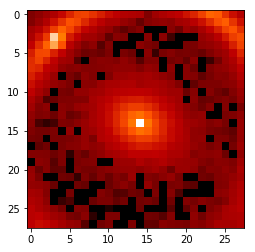

75
1.1852557259793897


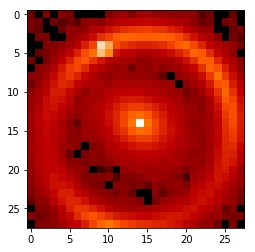

76
1.2088901328052934


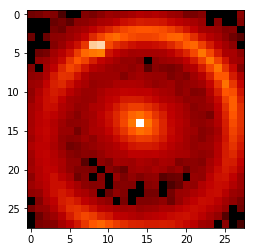

77
1.193084207424323


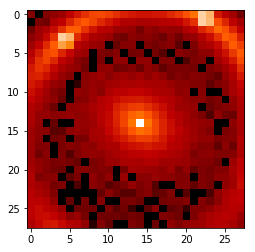

78
1.2070708886131267


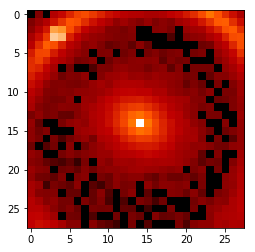

79
1.3271021268159164


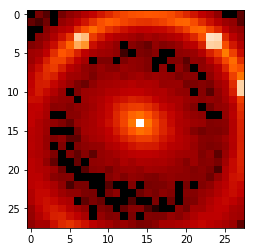

80
1.471607104398153


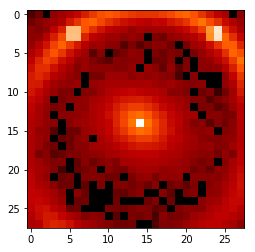

81
1.3520681395853684


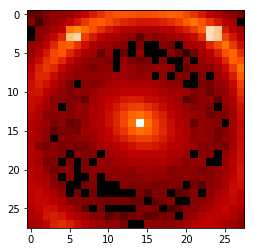

82
0.8912558143830649


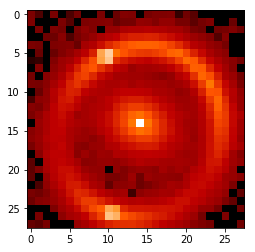

83
1.045121194378642


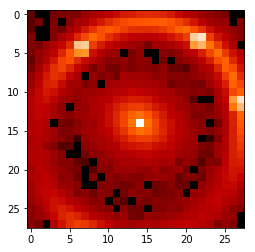

84
1.6518943647967832


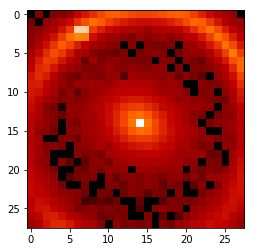

85
0.6232464877213746


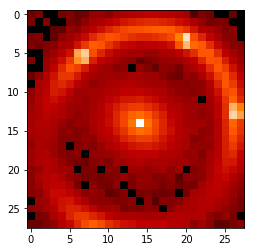

86
1.6600653266891263


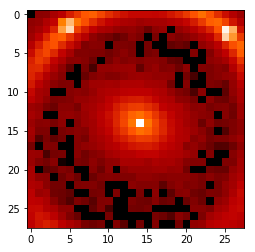

87
1.504787057811432


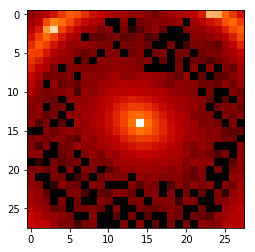

88
1.225854077208253


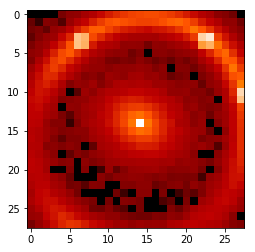

89
1.1745332864727325


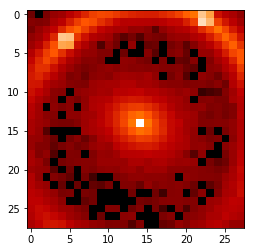

90
1.3336048467308501


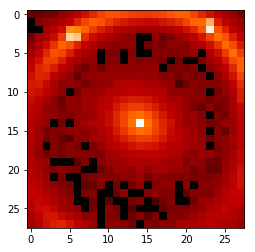

91
1.4516387334968543


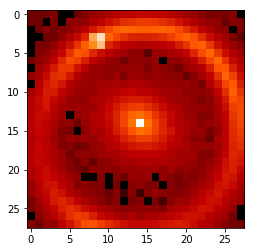

92
0.7551928907542917


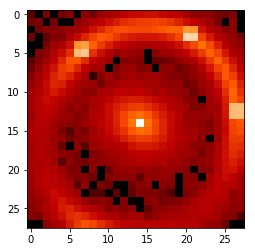

93
1.8643859786574977


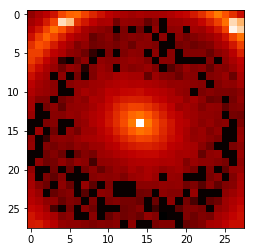

94
1.2690103791853997


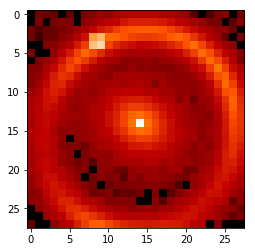

95
0.20186772039625334


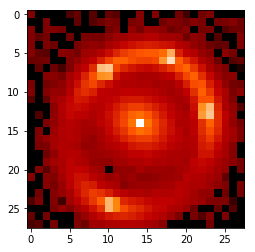

96
1.5909657811374274


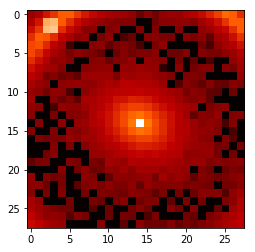

97
1.7699215006642226


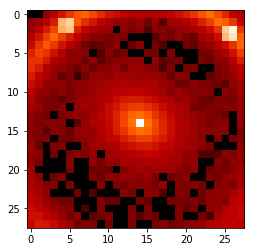

98
1.5689155844072529


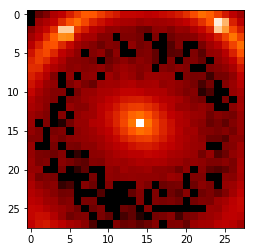

99
2.104157444694226


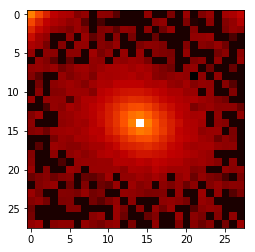

[0.5, 0.5, 0.1]
0
1.775468800436229


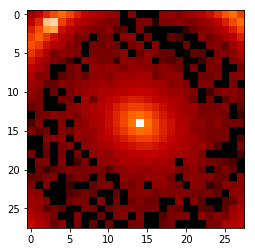

1
1.3670263005140917


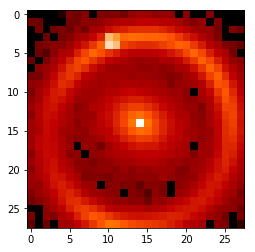

2
1.4406568338989265


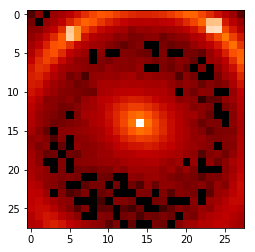

3
1.1514773290948854


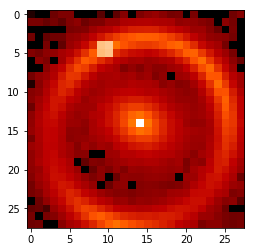

4
1.244531246886809


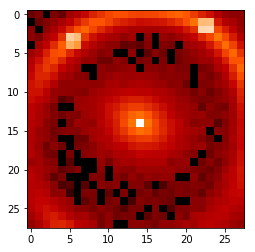

5
1.638068855989003


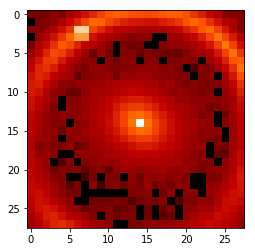

6
1.7340672184690857


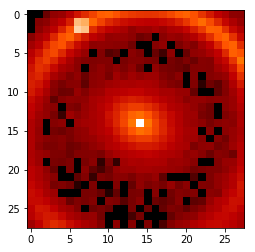

7
1.4502026487904849


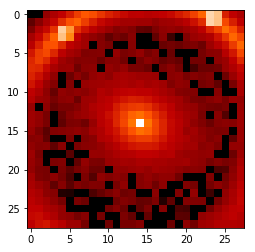

8
1.6912736175573986


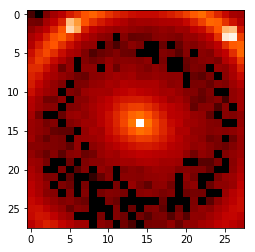

9
1.1128473456563406


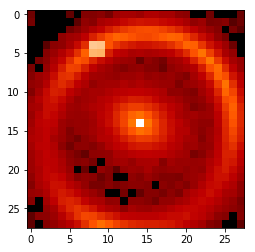

10
0.5114711861851811


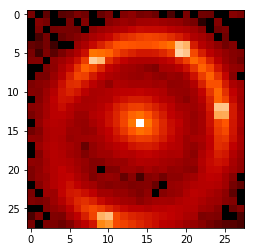

11
1.107923253586596


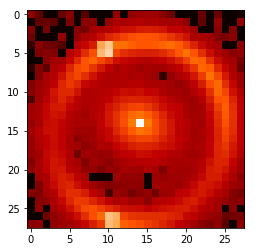

12
0.8988807484583105


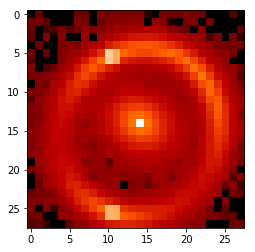

13
0.7830067663493214


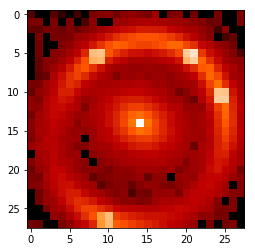

14
1.668839991884314


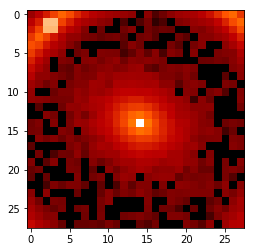

15
0.4906163465658725


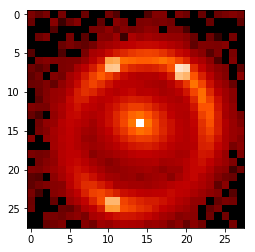

16
0.4585767488299527


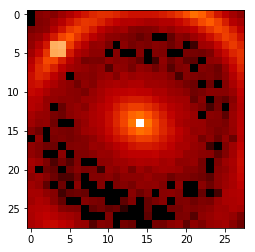

17
1.164109629927866


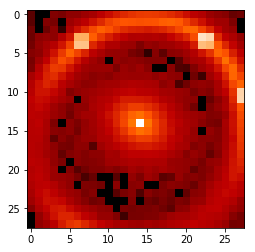

18
1.4292005507057688


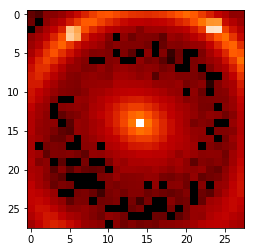

19
1.3171223788512565


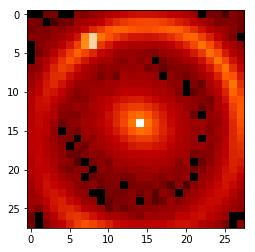

20
1.4747747841007168


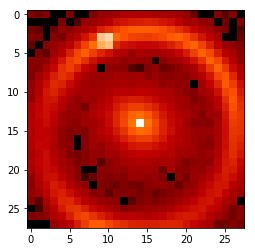

21
1.073504094966804


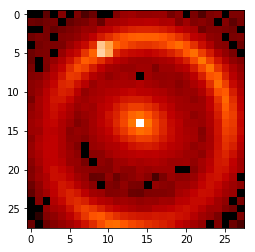

22
1.8116012723602748


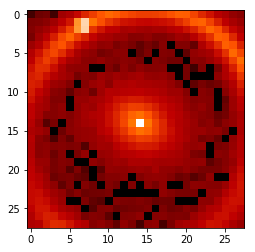

23
1.1904935581590106


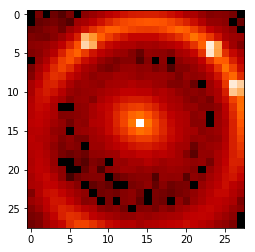

24
1.7407812742693174


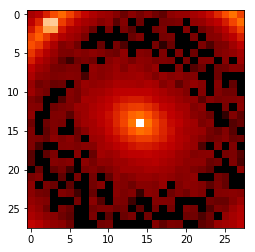

25
0.6527267501380805


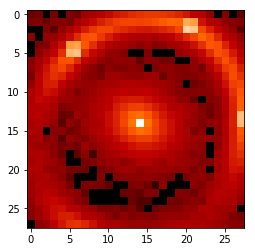

26
0.47335746196335315


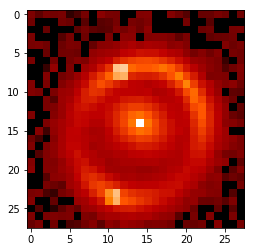

27
1.0999106353690553


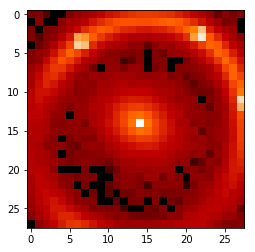

28
1.556772149980953


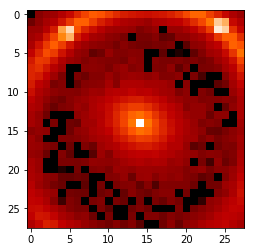

29
1.0147291023070428


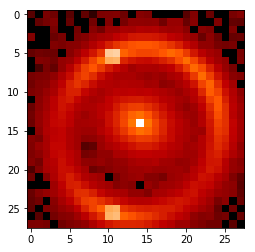

30
1.3503824761847398


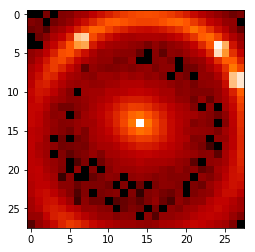

31
1.0724659413315556


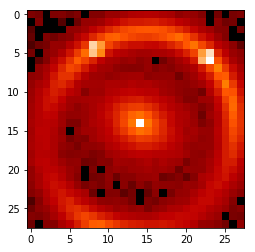

32
0.9249040772949675


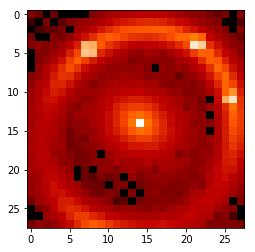

33
0.9582706466541097


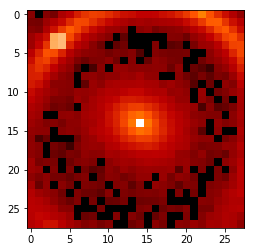

34
0.8360548846766824


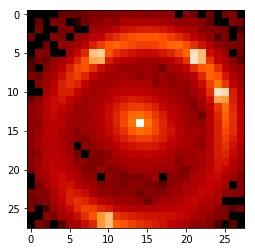

35
1.1130870595680649


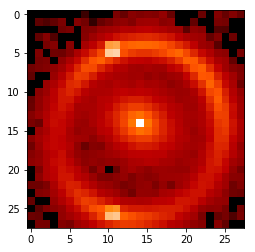

36
1.8718297365249041


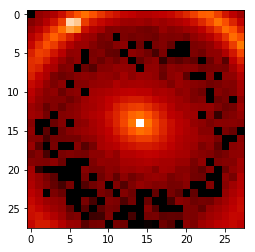

37
0.8857945701956711


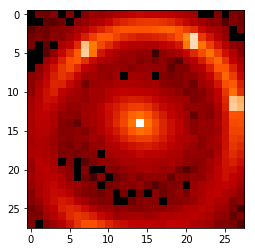

38
0.9908797486919059


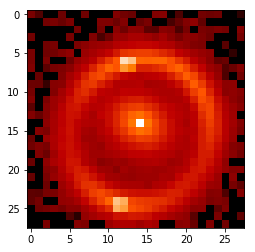

39
1.9627494839845427


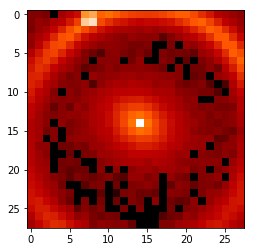

40
1.5134478396746


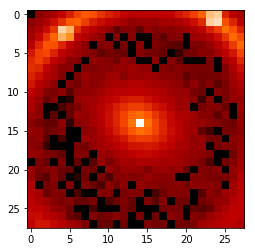

41
2.05710781794762


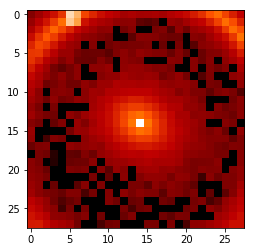

42
1.3531361582763866


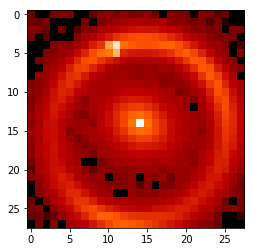

43
2.319069928511194


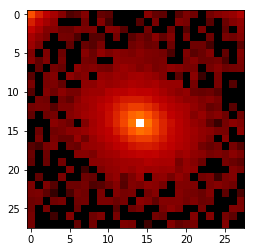

44
0.9261724346393553


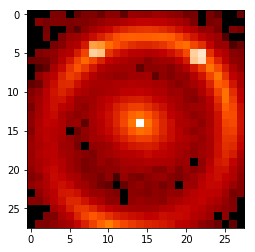

45
1.6866725111606402


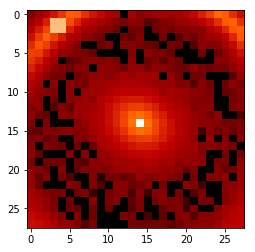

46
1.3666426272623038


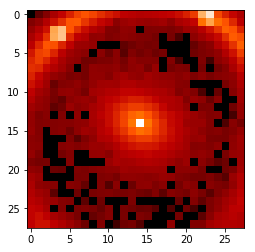

47
1.4379590730582215


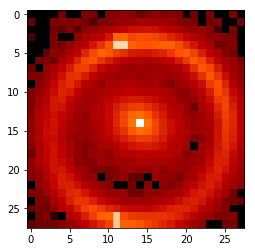

48
1.7355497310963786


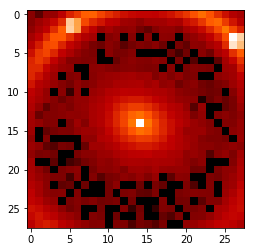

49
1.4443220327138795


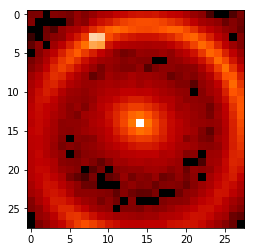

50
1.3534310173641766


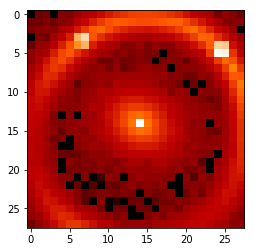

51
0.655187203928992


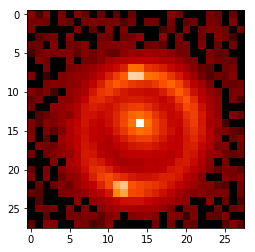

52
1.7227893231283637


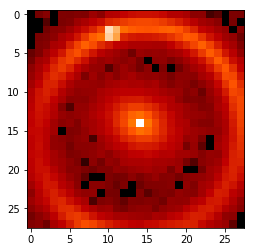

53
1.1254800225810424


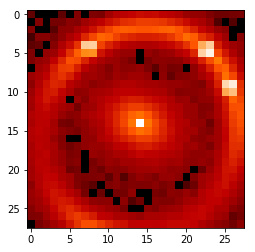

54
1.2100966232095833


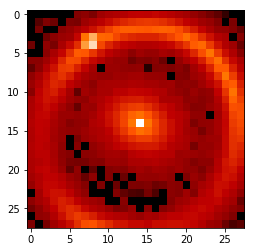

55
1.4539858169177093


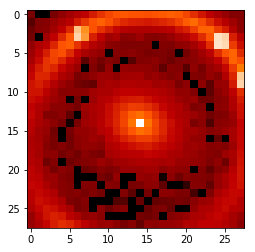

56
1.5365917460843481


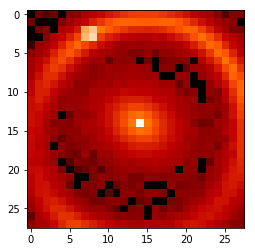

57
1.4501568049149358


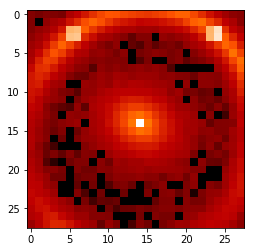

58
0.8112965859938188


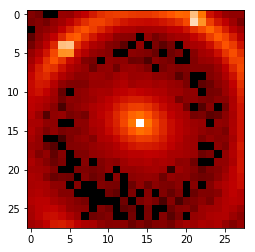

59
1.528347084990034


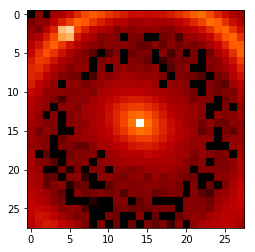

60
1.0300477024281203


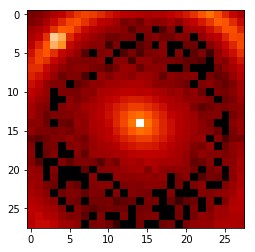

61
1.5239892481460366


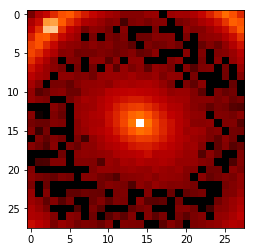

62
1.1685720585037331


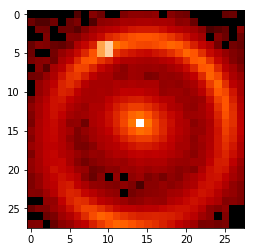

63
1.2394621609845702


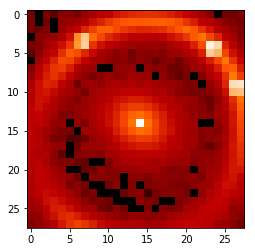

64
0.7700989707834827


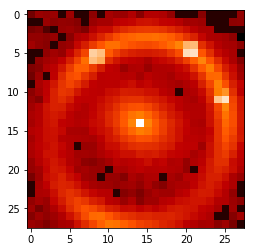

65
0.9472137018601314


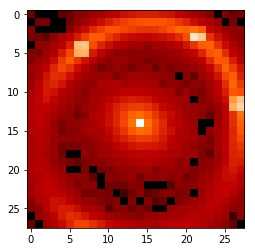

66
1.476662460174558


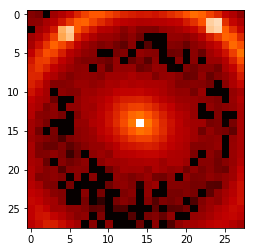

67
1.774187947483087


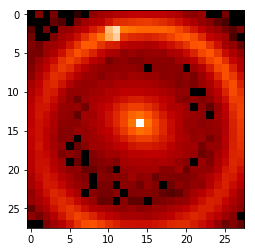

68
1.1957237854600233


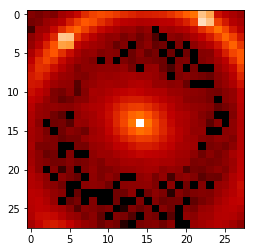

69
1.0620001078513484


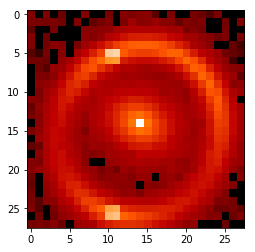

70
1.4718442571080252


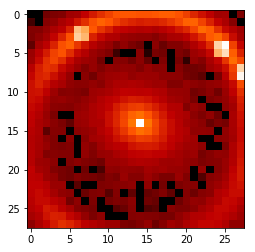

71
0.8908087383509429


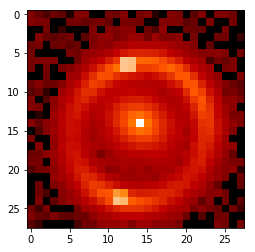

72
0.5070819533558419


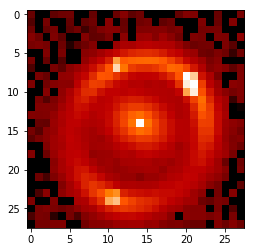

73
1.7256764528914807


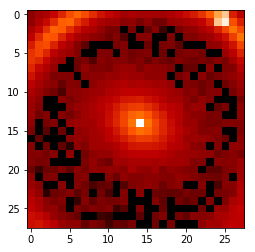

74
1.0925562752026508


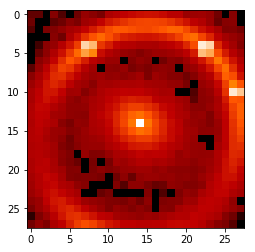

75
1.1864510352536135


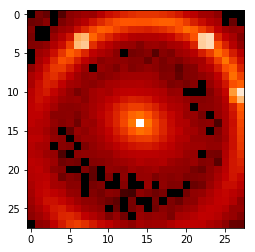

76
0.9935494045138606


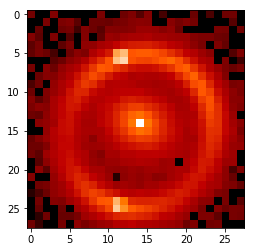

77
1.0489770627631954


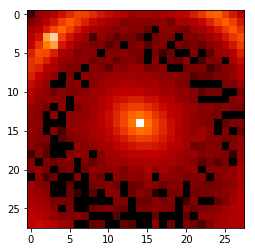

78
0.9607482851282698


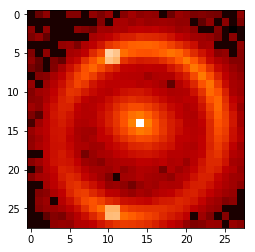

79
1.638191607440084


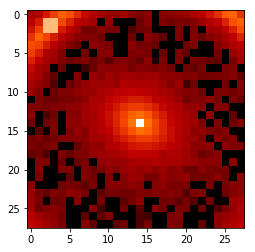

80
1.511364676618062


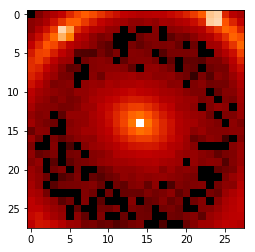

81
1.457230877007019


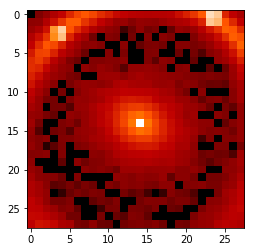

82
0.9835769157710965


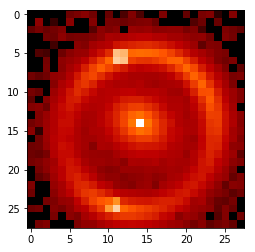

83
1.6808378035025118


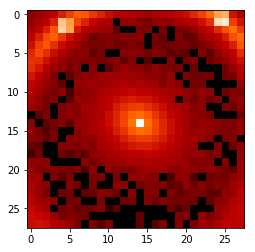

84
1.629189491111861


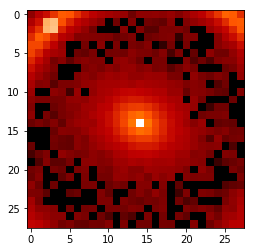

85
0.7085484557004547


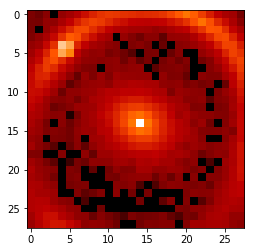

86
1.0796282185737252


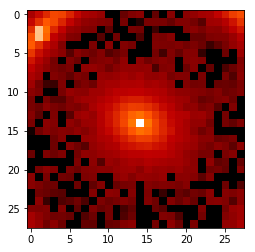

87
1.2130931314507793


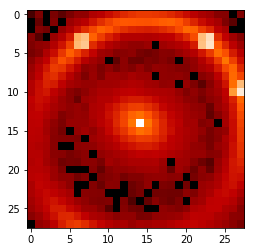

88
2.2102207523364035


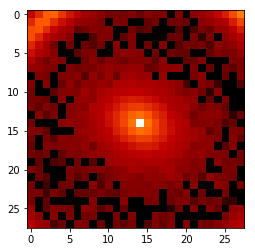

89
1.3121410714011654


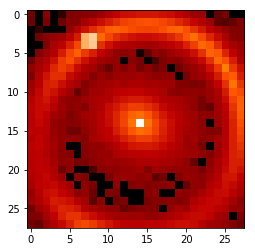

90
0.8098342452443417


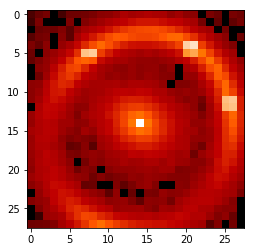

91
1.4483686816612253


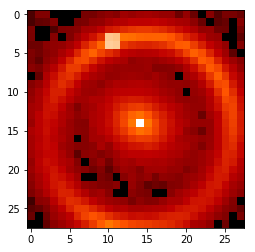

92
0.6127794293833136


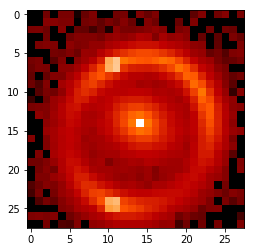

93
0.6745605164851066


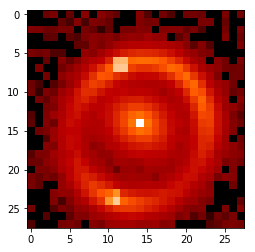

94
2.1839811467370454


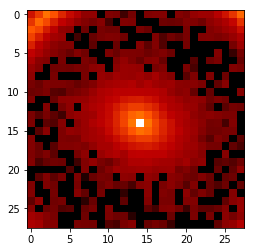

95
1.029030781584008


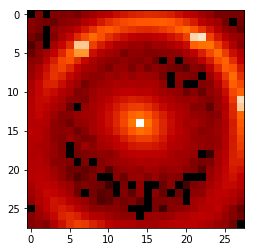

96
1.699908982124936


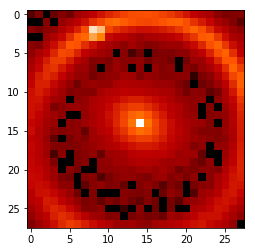

97
0.7987849343462174


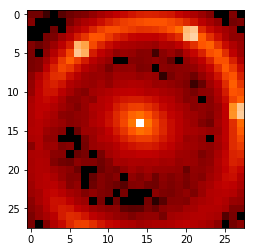

98
1.3306983503921839


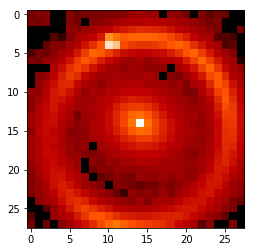

99
0.5785073441073888


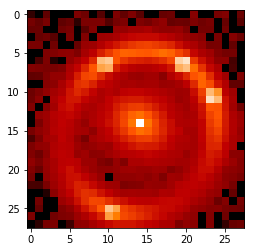

[0.5, 0.5, 0.1]
0
0.928928547690584


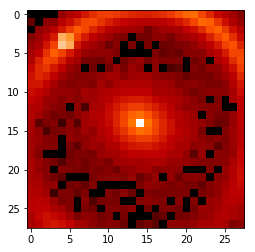

1
1.8613305868712982


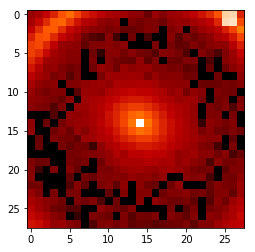

2
0.7974250114911992


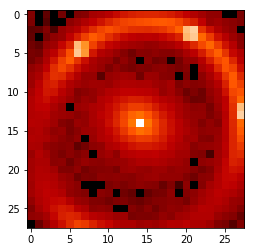

3
0.610196426984346


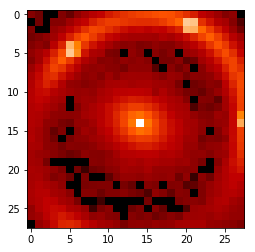

4
0.6228597535897318


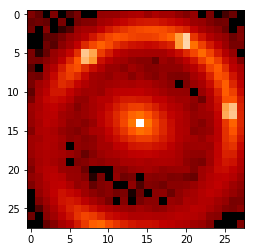

5
1.3683780288900842


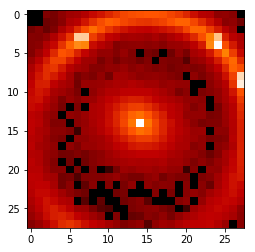

6
1.4135757722774331


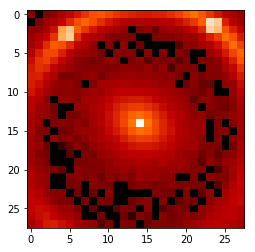

7
1.0963658183773521


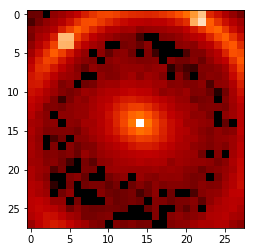

8
1.3881355472233898


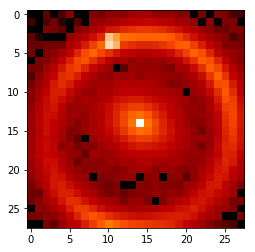

9
1.7251822729041506


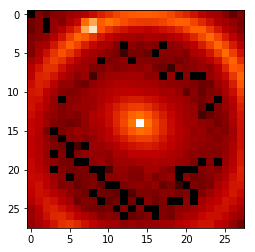

10
1.4389086066410437


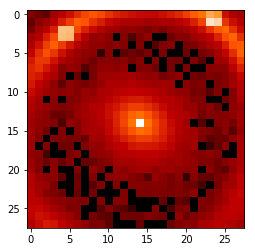

11
0.8729139102271821


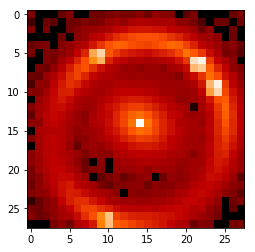

12
1.3113513345199814


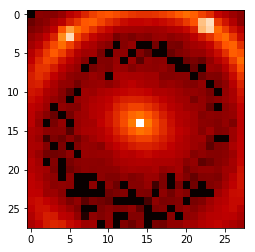

13
1.3787020595900648


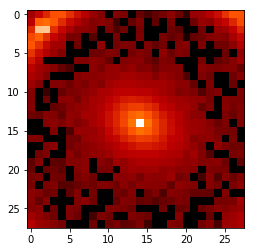

14
1.1927325921719136


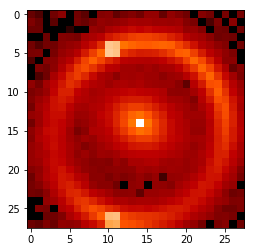

15
1.4949081297054523


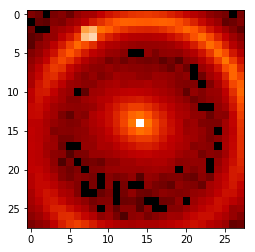

16
1.3719083568399104


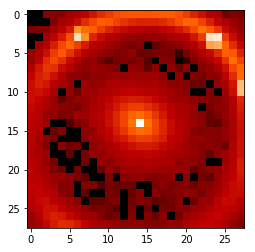

17
2.139044468208538


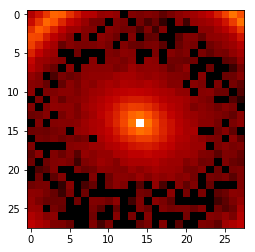

18
0.8190527811394015


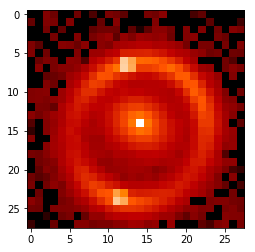

19
1.4085681864782984


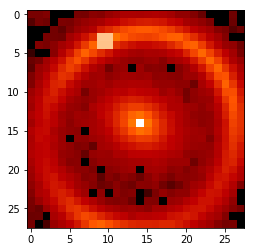

20
0.9584739697813975


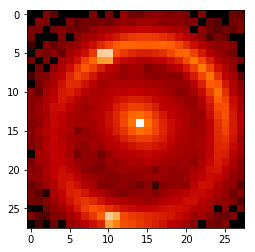

21
0.9450805268503681


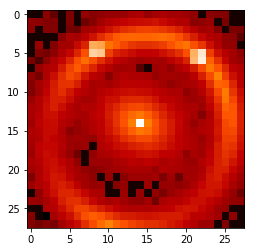

22
1.6016467002095265


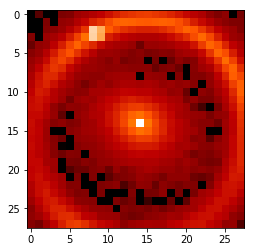

23
1.1833901200493753


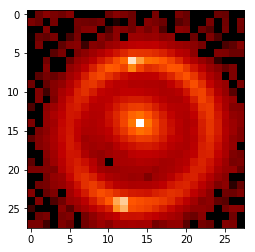

24
0.9027277732021832


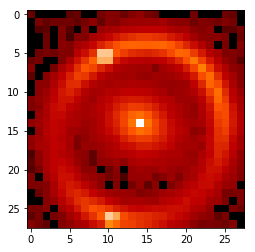

25
1.7859623935400517


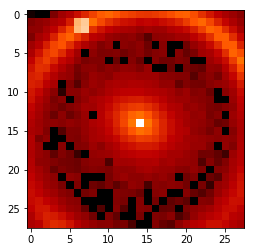

26
1.2789386782324934


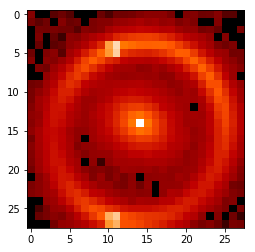

27
1.521624531729028


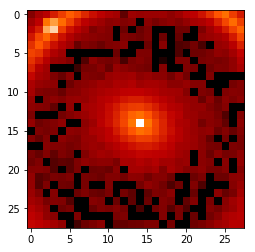

28
0.8984270126291818


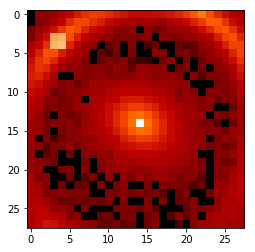

29
1.4779065258536892


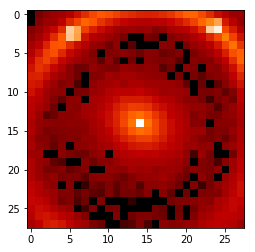

30
1.3204038370535733


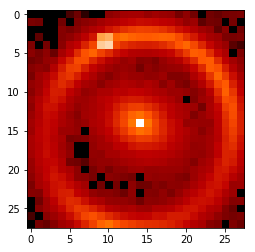

31
1.7244109710872906


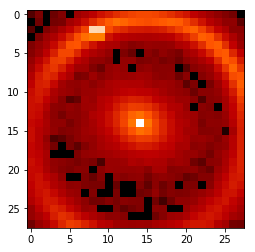

32
1.5495337355015668


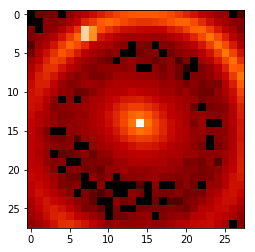

33
1.9335519109812342


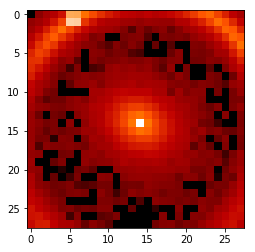

34
0.928719754268936


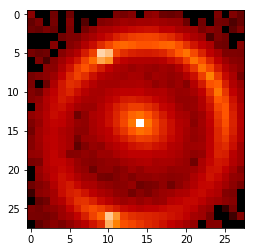

35
1.4942204024902563


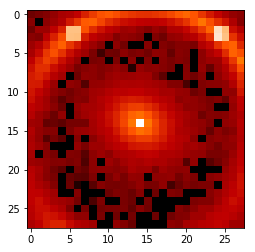

36
1.2227120439781407


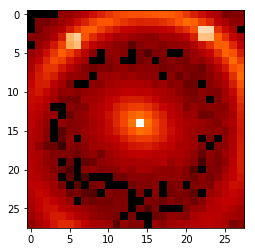

37
1.106652112601678


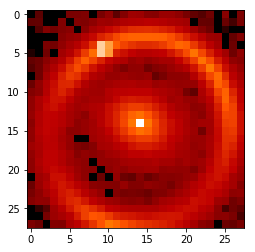

38
1.4174047634488107


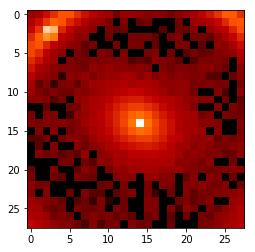

39
1.1929633964113402


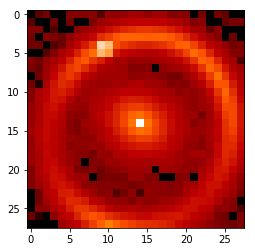

40
1.2624102857750457


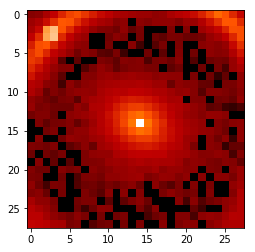

41
0.9851038840017495


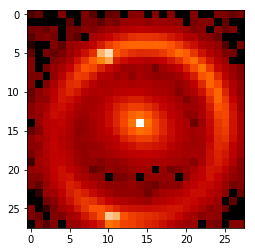

42
1.0244640164595105


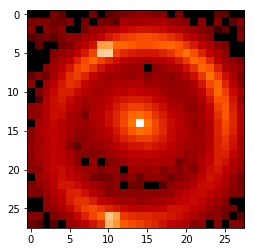

43
0.6901717644536556


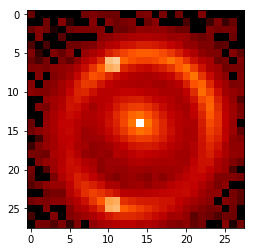

44
2.022501328915743


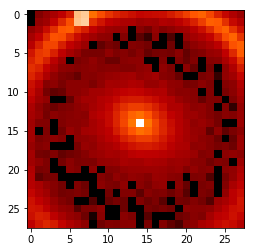

45
1.7835762069428522


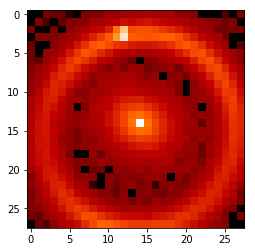

46
1.4397681194371148


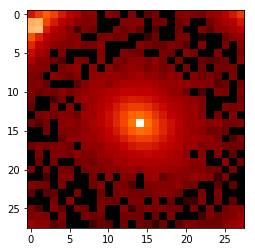

47
1.5197891576744684


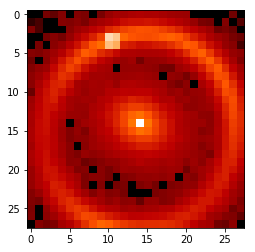

48
1.1487175970663284


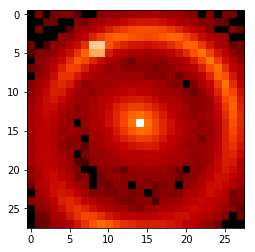

49
1.31080464452293


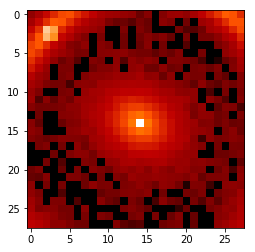

50
1.498421225621132


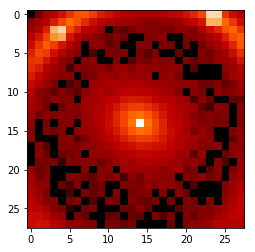

51
1.8557399905497363


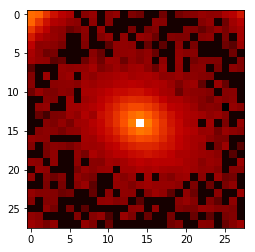

52
1.4803392691615107


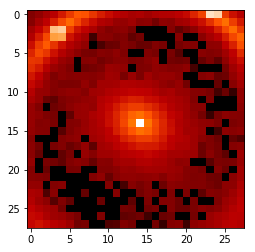

53
1.7069826074071974


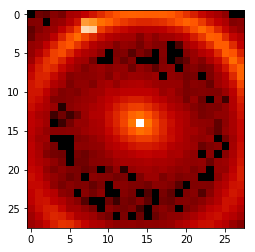

54
1.56142820309222


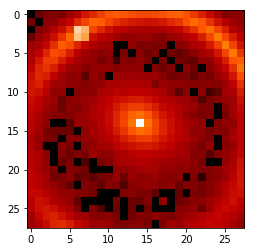

55
0.8406728464473544


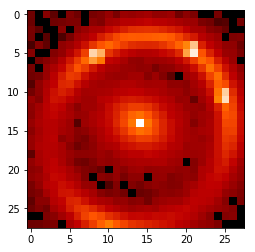

56
1.166336661603912


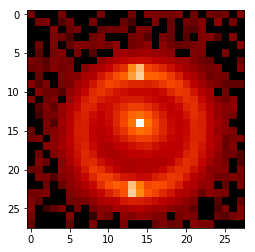

57
1.0734510390065615


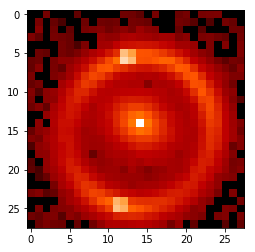

58
1.1374182864419777


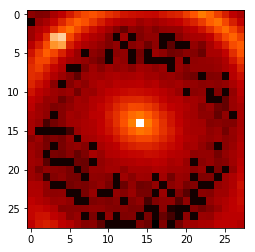

59
0.9366251032920201


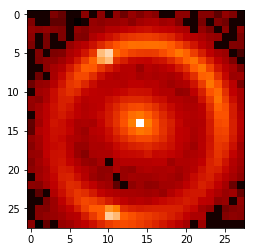

60
0.8477037626997205


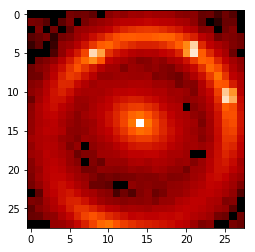

61
1.6524176119213747


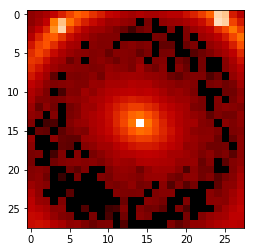

62
0.9462191775788817


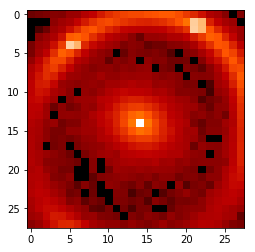

63
1.8628302901581741


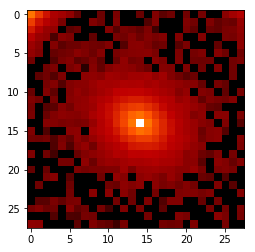

64
1.6247539785643936


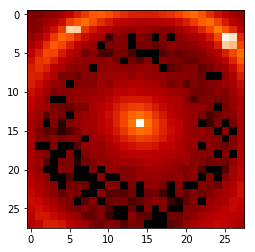

65
1.3680617917412778


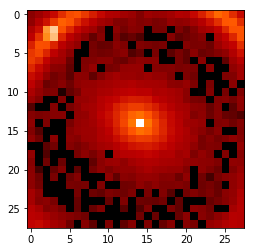

66
0.8471761798457629


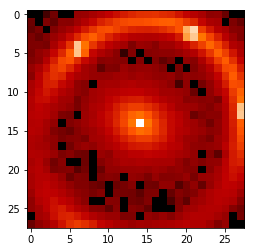

67
1.0872836808733775


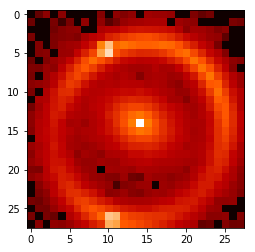

68
1.262444042061633


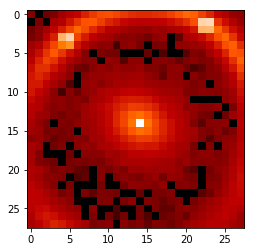

69
1.5215438768932121


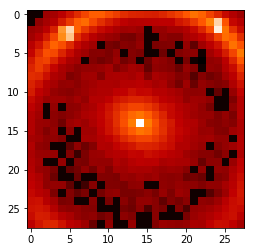

70
1.323822573256034


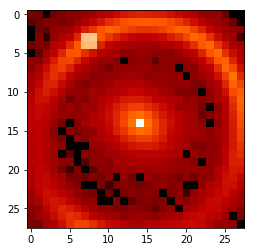

71
1.6040743407022835


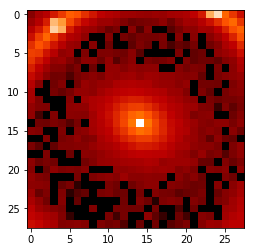

72
0.557557682262773


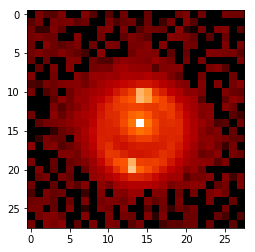

73
1.5183444582639736


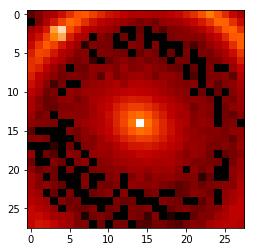

74
1.325068175057465


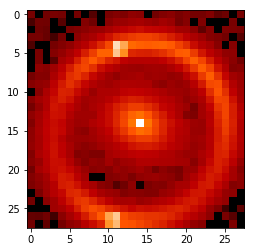

75
0.9164988288511711


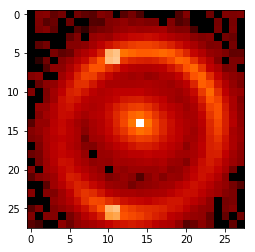

76
1.3330264614693612


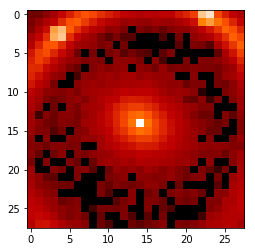

77
1.3379461624514335


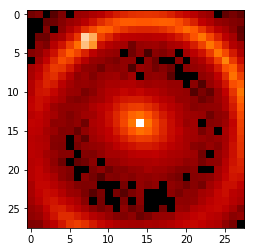

78
0.33508457894392496


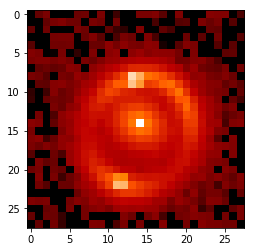

79
1.0809832207452605


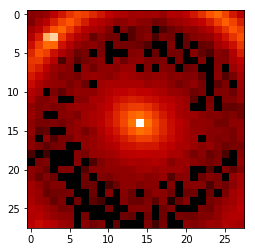

80
1.4096478031673354


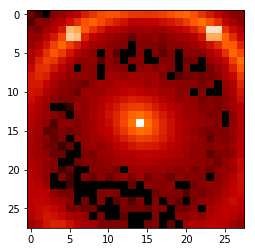

81
2.1832413820250403


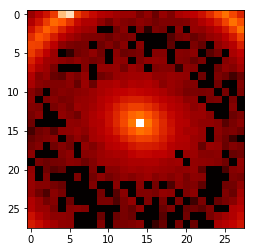

82
1.4611135430604805


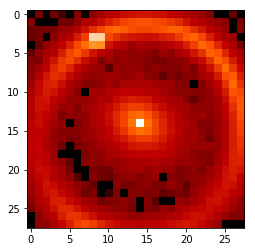

83
2.335527525674407


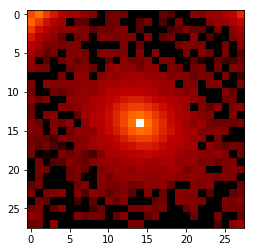

84
0.6470438270848088


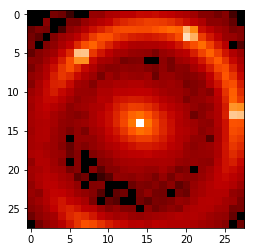

85
1.4327632531214318


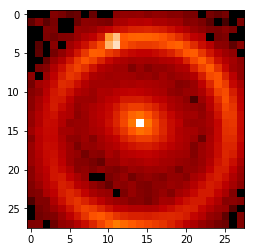

86
1.1055879183974895


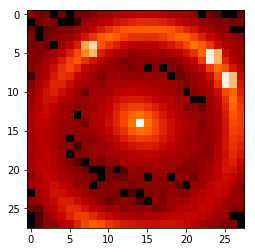

87
1.279270457509512


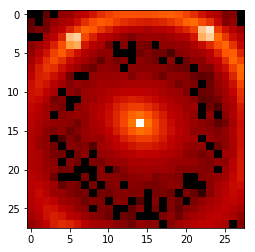

88
0.8970064131719012


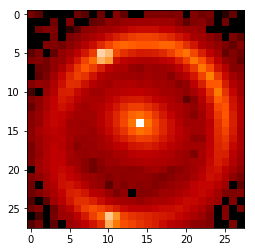

89
1.3922149834051394


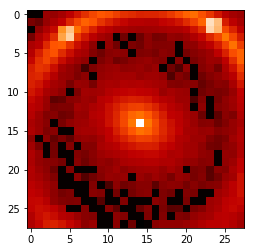

90
1.3235078573364332


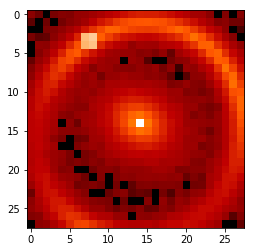

91
1.1442639723071397


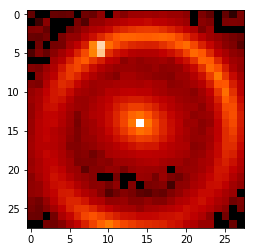

92
1.644486656289435


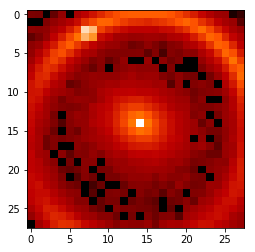

93
1.4068085060153215


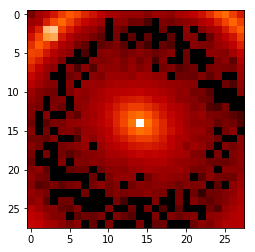

94
1.5885723414863513


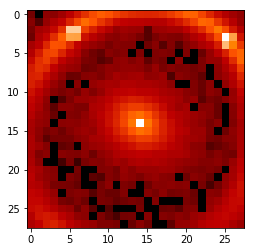

95
1.5862701861034254


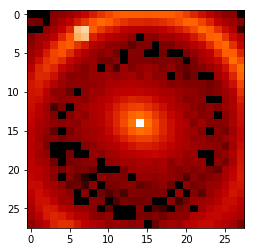

96
0.9138591492021555


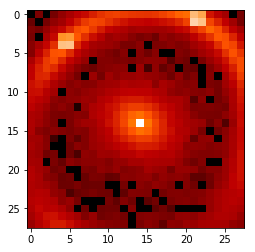

97
0.7605434499636129


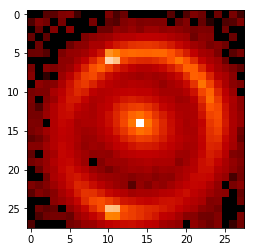

98
0.9569367352954234


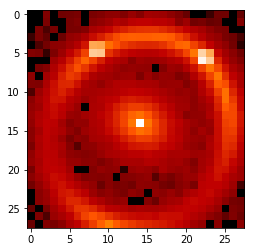

99
1.3060286393841565


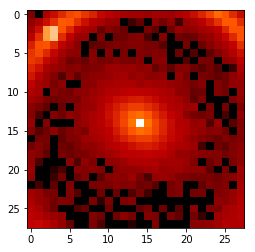

[0.5, 0.5, 0.1]
0
1.3210863316441268


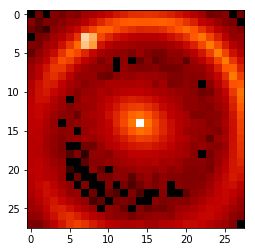

1
1.1168242267696515


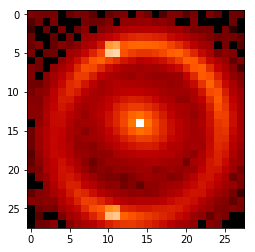

2
1.1467188548900293


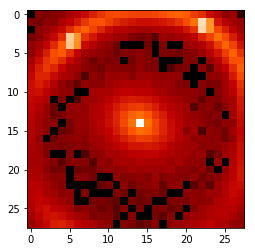

3
1.259632626434511


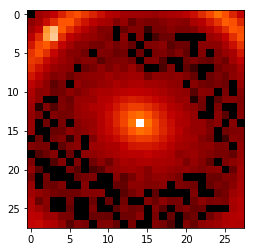

4
1.2892177762092765


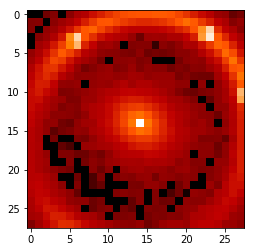

5
0.5106724943515364


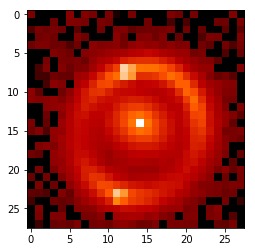

6
1.0511349000818189


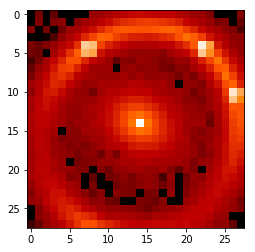

7
1.4812422515167973


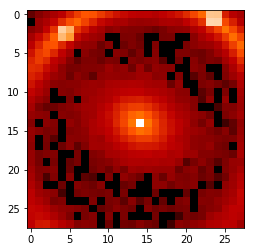

8
0.7169956644805305


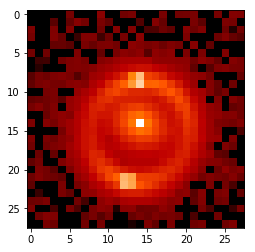

9
1.6301029092119559


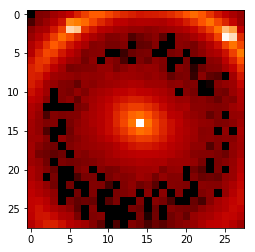

10
1.237329325548236


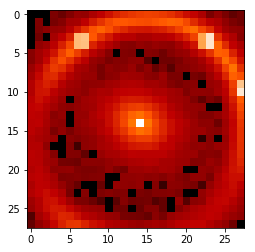

11
1.311508642618919


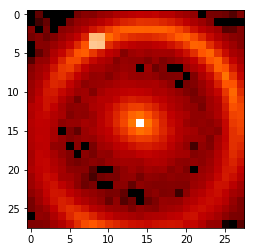

12
1.3295779336419922


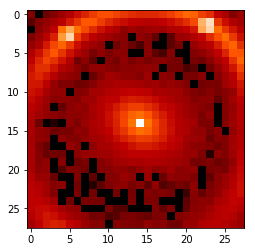

13
0.8649907971184033


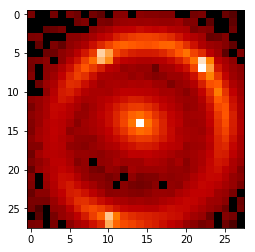

14
1.9672164766238145


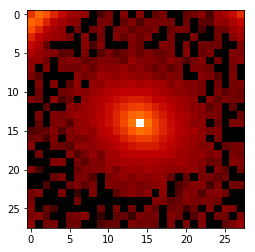

15
1.6550901923588903


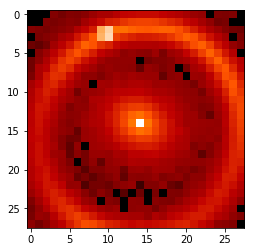

16
1.5584133443937296


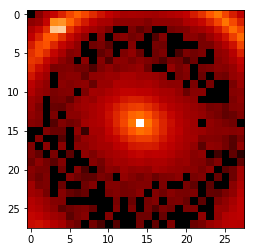

17
1.0055234805231326


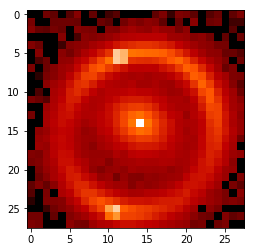

18
1.3020702781981275


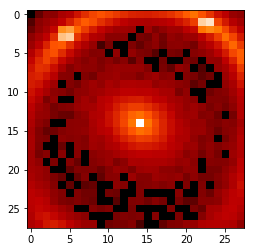

19
1.1649087994539806


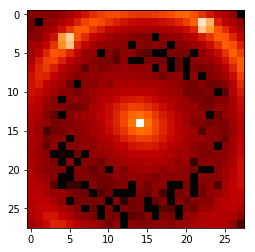

20
1.1587637652158573


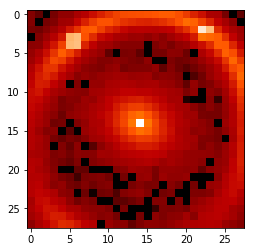

21
1.5373640010361576


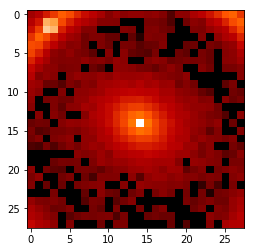

22
1.7493577057913183


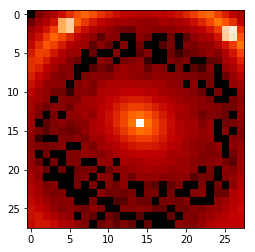

23
1.2448899515159582


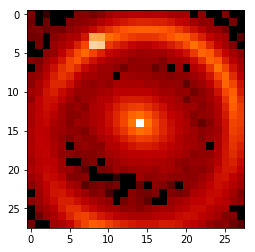

24
1.0916190748306878


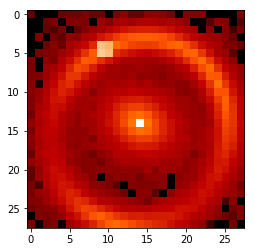

25
1.0249416713151136


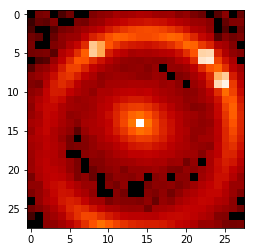

26
0.9506753008707539


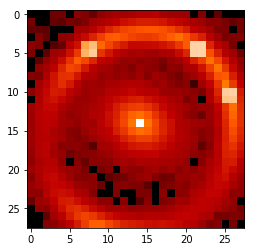

27
0.755037975931032


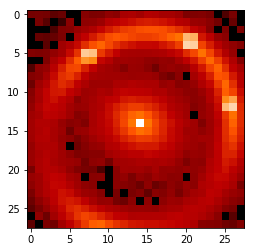

28
0.8950030309205093


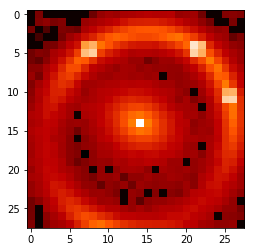

29
1.6205258845845703


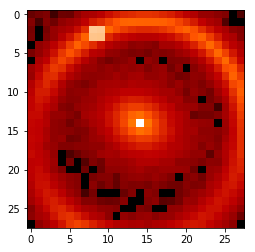

30
1.3680373503075722


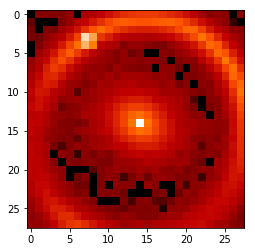

31
1.6116946775899197


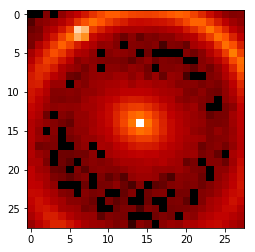

32
1.401986710447988


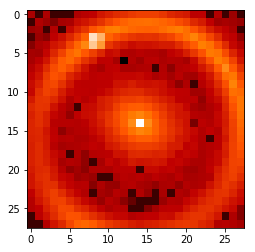

33
0.8816555398117314


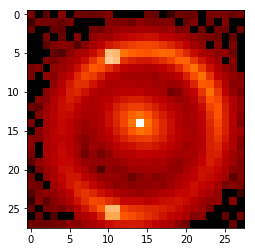

34
0.6374764586896982


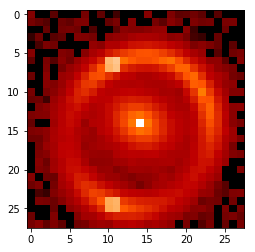

35
1.129042699470386


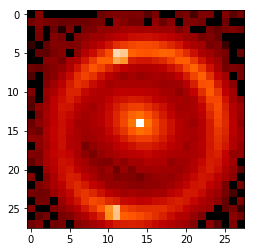

36
0.9054509521234047


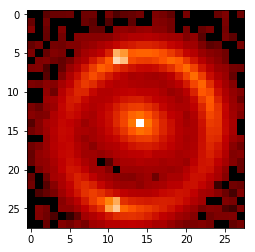

37
2.009751941796413


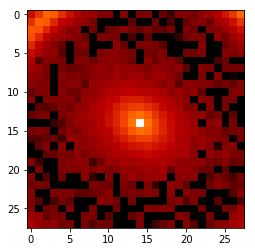

38
1.4457554523625615


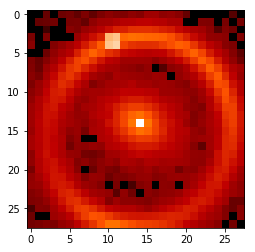

39
0.9996782028779718


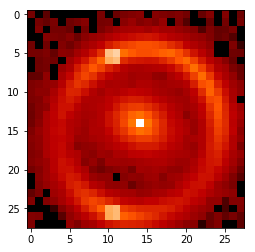

40
1.4285111015949825


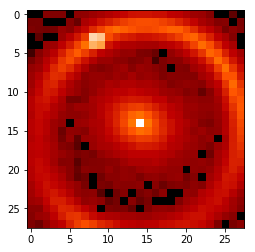

41
1.323997686778604


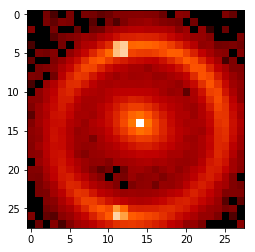

42
0.8951487767310466


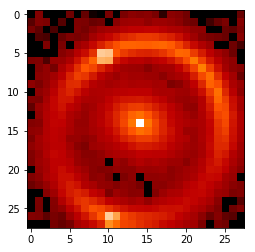

43
1.5738750902141732


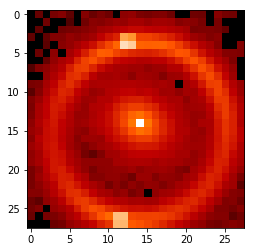

44
1.2167176905894488


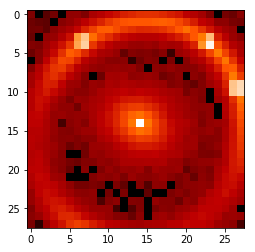

45
0.6499590148656469


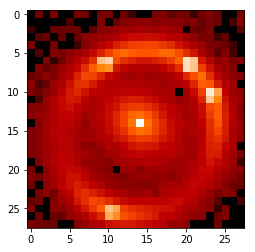

46
1.4538111087194734


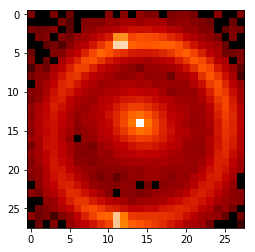

47
1.5748487461134308


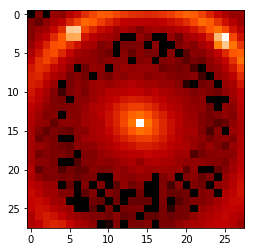

48
0.768667780366003


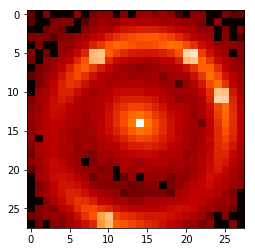

49
0.514007012534877


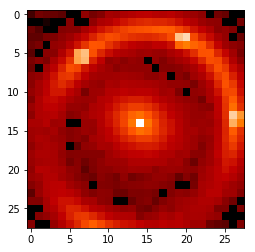

50
1.0531087785143458


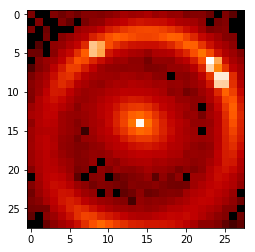

51
1.6145385205071017


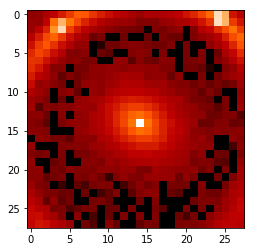

52
1.3960019061957496


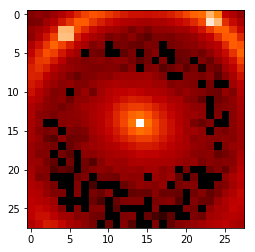

53
1.0597786788599648


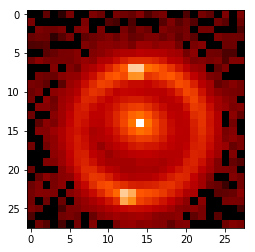

54
1.5526342700003302


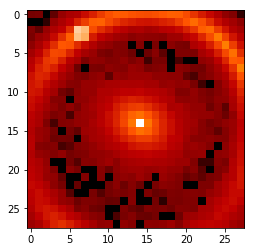

55
1.041596441554471


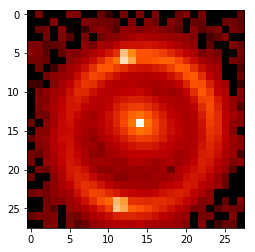

56
1.0926382595448356


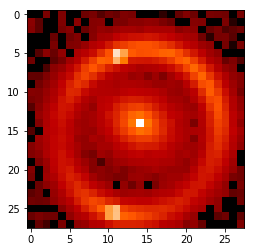

57
1.5610383815020061


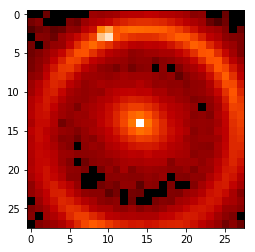

58
2.048601968619799


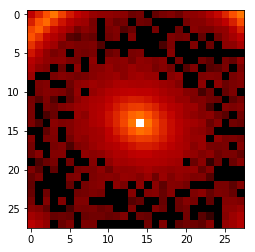

59
0.6567568825717466


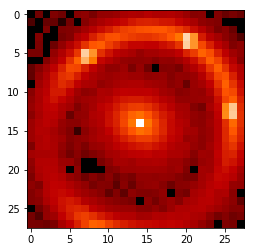

60
1.1878948674994496


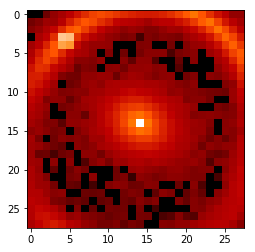

61
1.6091533136414362


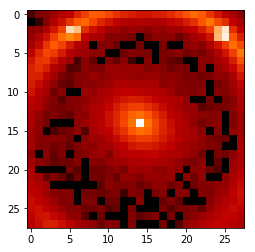

62
1.0276875077093017


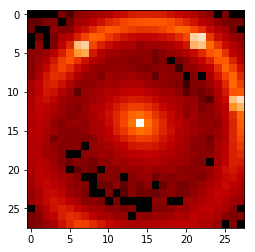

63
2.073834224005271


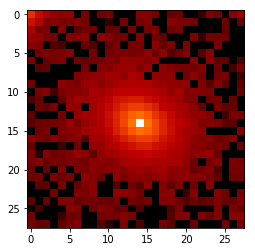

64
1.1243151658033428


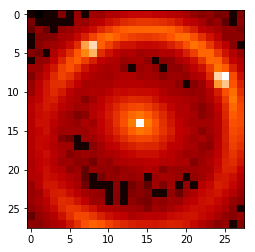

65
1.8456215661987274


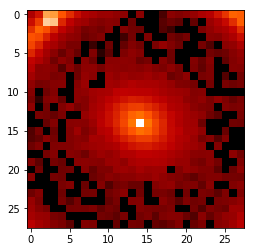

66
0.31530453166156447


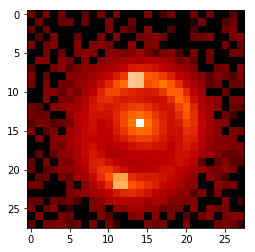

67
1.105642970692834


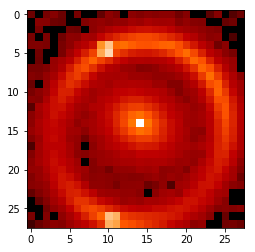

68
1.1048349983102348


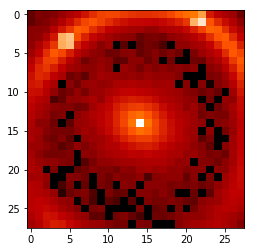

69
1.419192051948109


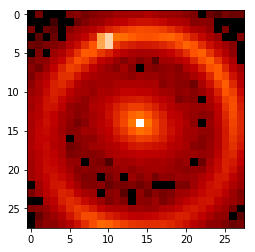

70
1.4397412185295309


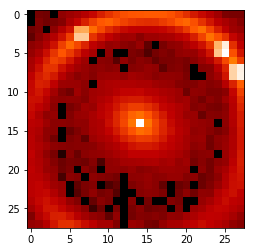

71
1.2606089746681215


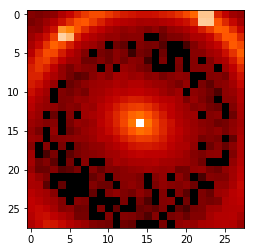

72
1.2936654667707557


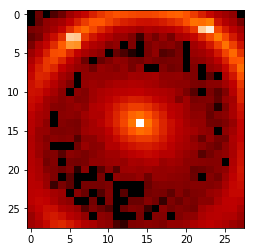

73
1.296577611935364


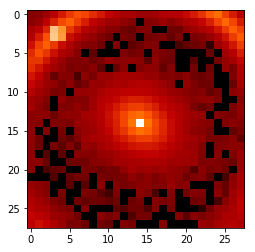

74
1.9822210690330322


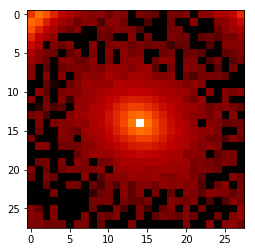

75
0.6810226972836536


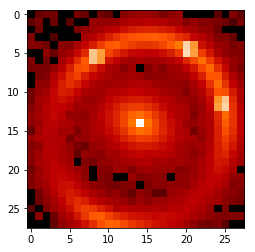

76
1.1908786687508477


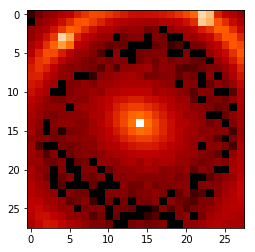

77
1.5853422550468668


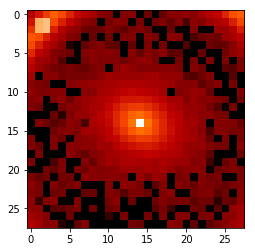

78
1.7289083970704842


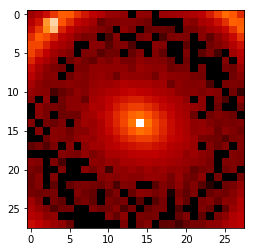

79
1.3291575261772222


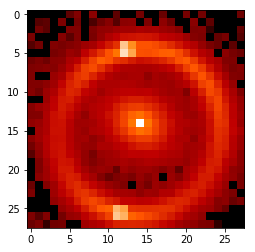

80
0.8603240163884809


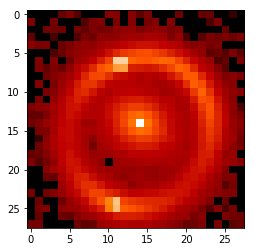

81
1.4886472010673741


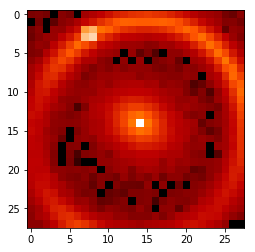

82
0.9591806174223888


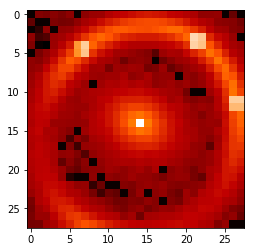

83
1.4670718548116428


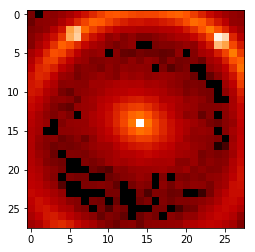

84
1.2602382869220567


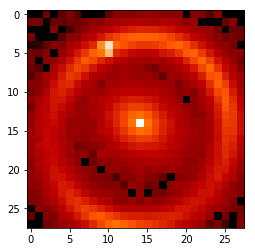

85
1.523186458319014


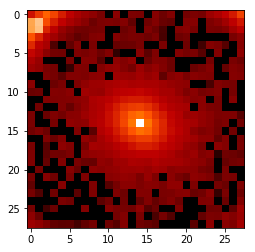

86
1.580307538395675


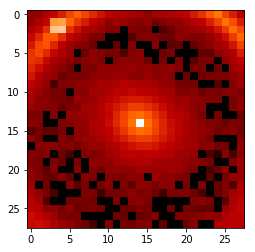

87
1.1896483277354633


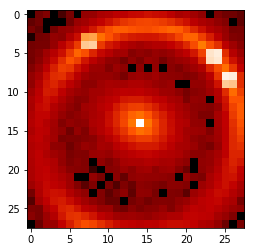

88
1.2098924049070483


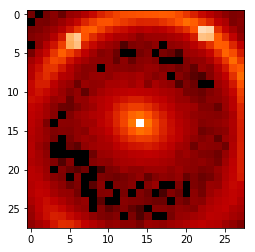

89
1.3076833834347712


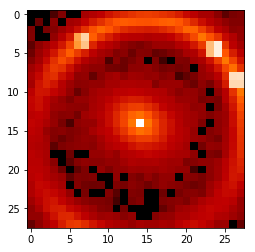

90
1.5358323919978303


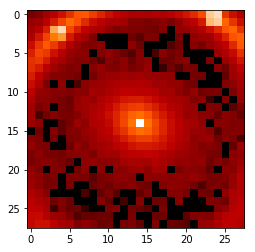

91
1.4701255669416702


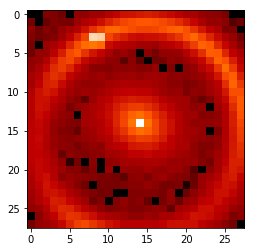

92
1.9324928803432702


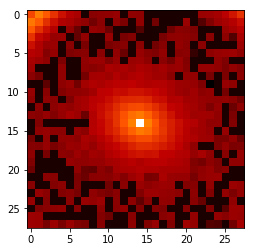

93
2.121945123761254


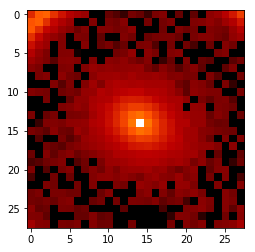

94
0.781578206962539


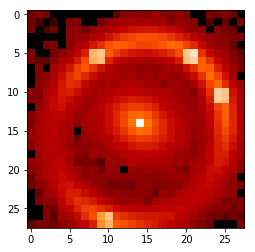

95
1.791652409313035


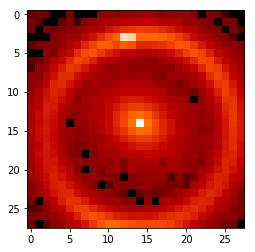

96
1.038666729426696


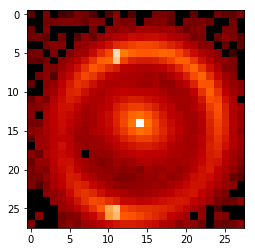

97
1.3287214995225567


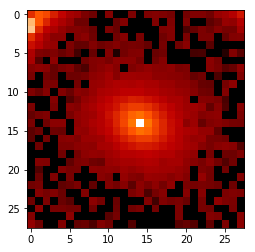

98
1.2546584860867795


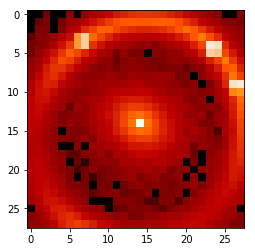

99
0.9774785440822105


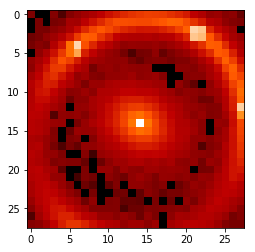

[0.5, 0.5, 0.1]
0
1.1213508932372067


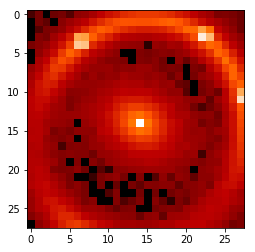

1
1.1365899642283916


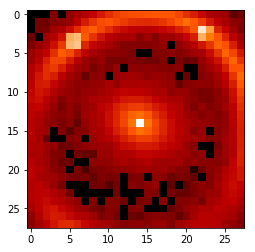

2
1.0629110439833713


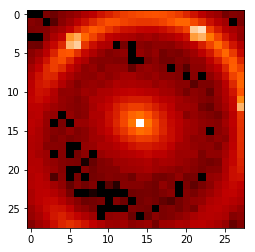

3
1.2891883880603334


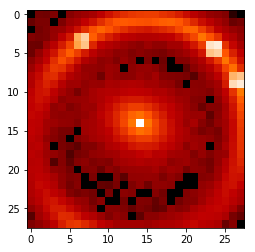

4
0.19969147122784792


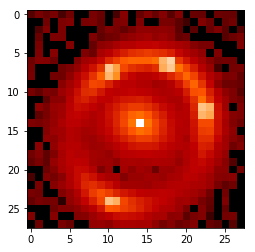

5
0.8712271303341517


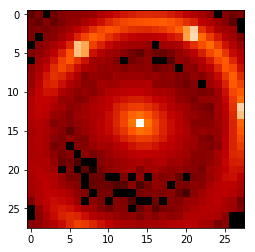

6
0.6889815388214271


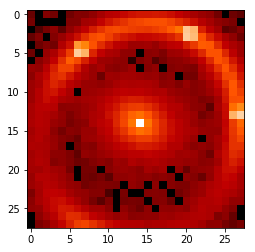

7
2.0901738357774993


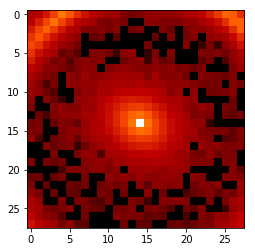

8
0.9998063566622241


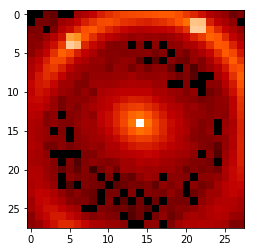

9
1.210717132105403


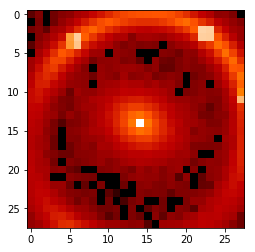

10
0.8784095335612521


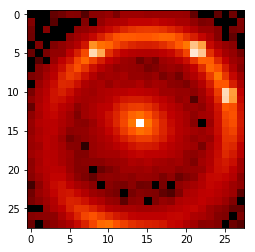

11
1.8471149496011523


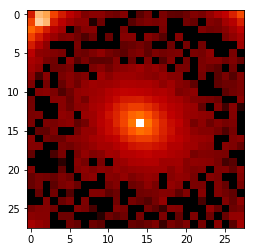

12
0.8221250659150539


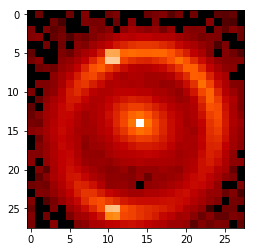

13
1.084870843179024


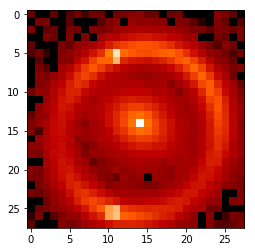

14
1.2326178712730276


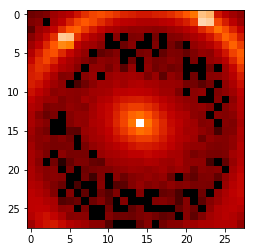

15
1.1010124408706632


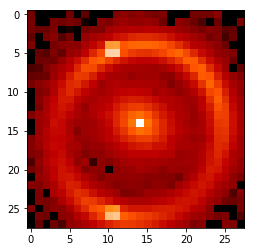

16
0.8201417843854681


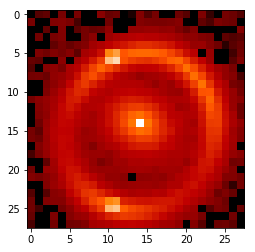

17
0.6735015609086951


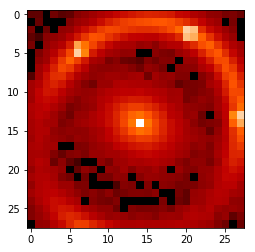

18
1.3030949593176813


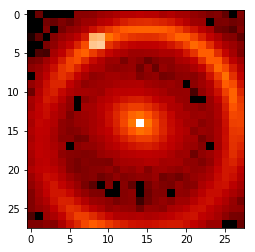

19
1.040927368078852


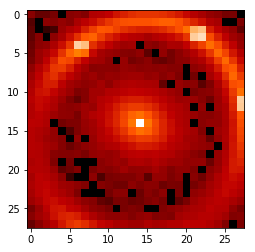

20
0.9643393910993905


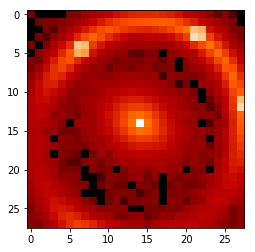

21
1.4969594021704558


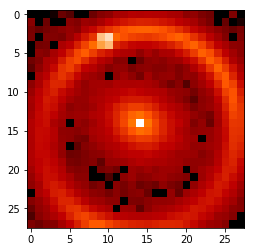

22
0.6868955155134608


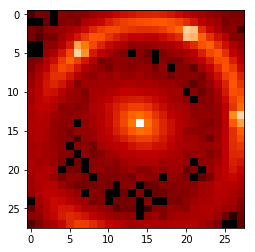

23
1.0302007590836304


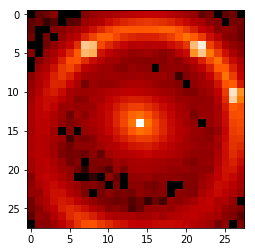

24
1.9126250672497478


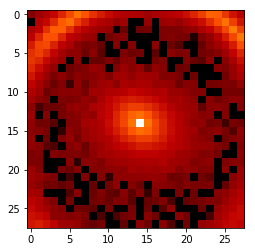

25
1.2340354718981204


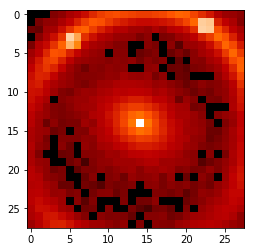

26
1.3954526215332466


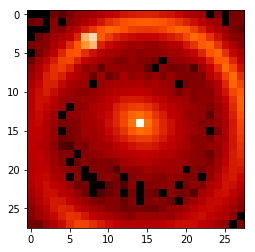

27
1.371335409800921


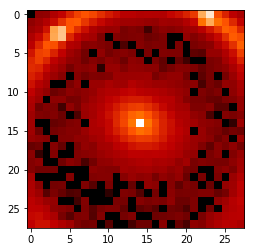

28
1.2434214588348744


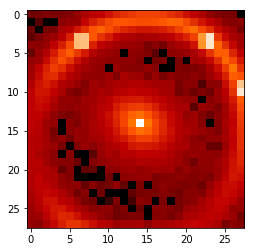

29
1.8435441151477403


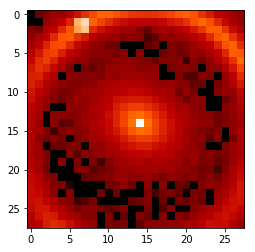

30
1.1885659851763875


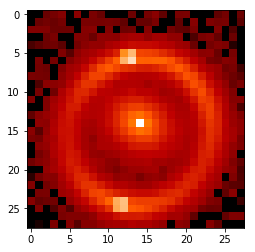

31
0.931643050355384


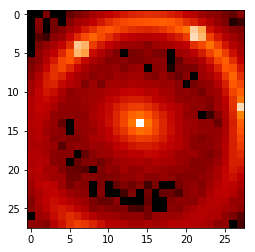

32
1.029855451580549


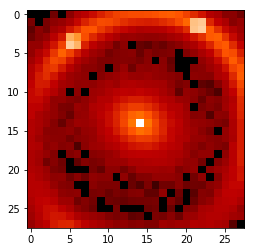

33
1.93056276555387


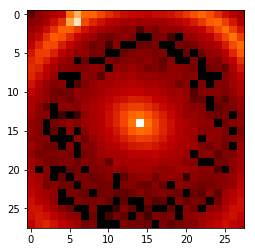

34
1.666206577735047


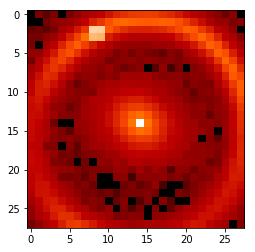

35
0.8661521629061346


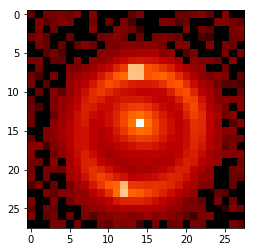

36
1.9960015840274274


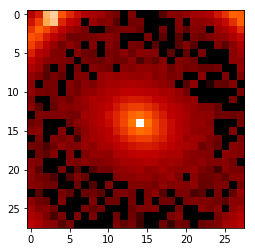

37
0.3378916938965508


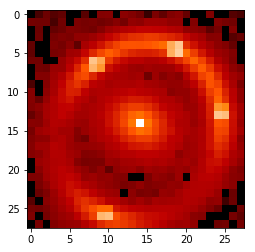

38
1.432814651467798


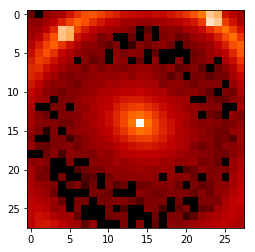

39
1.1582508732795305


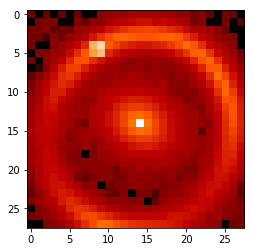

40
1.1314744180573302


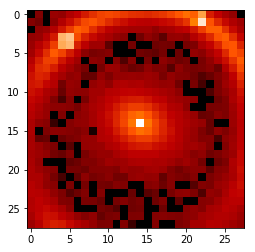

41
0.7674325990539579


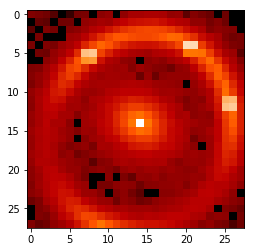

42
0.5456855869379381


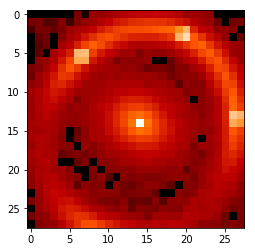

43
0.8711296166928093


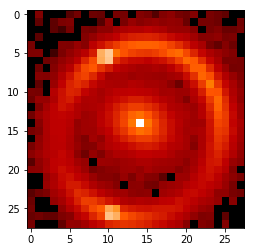

44
1.5116265915905278


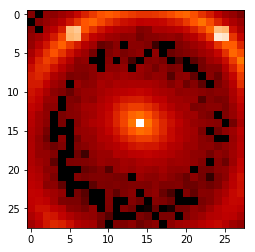

45
2.021771503753932


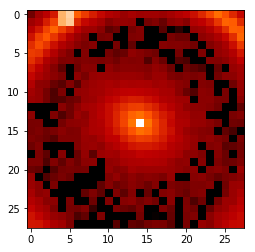

46
1.2550473435489284


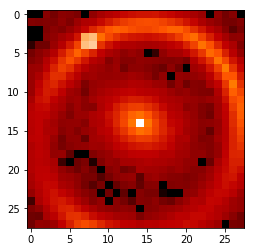

47
1.4922429183522228


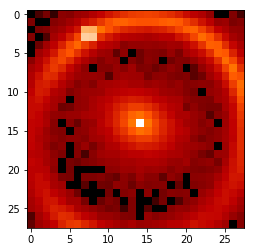

48
1.3737522286806751


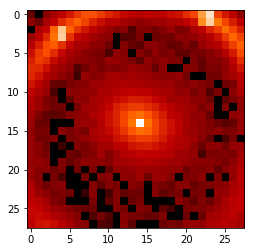

49
1.4210677018851268


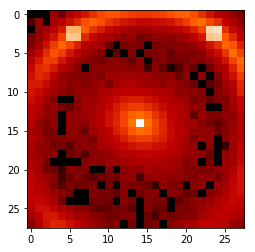

50
0.5637729888282615


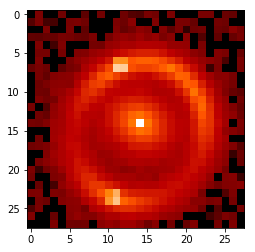

51
1.3581808996119145


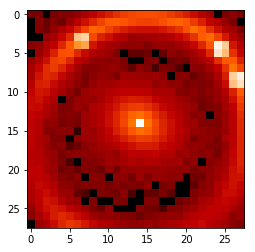

52
1.4211984199605943


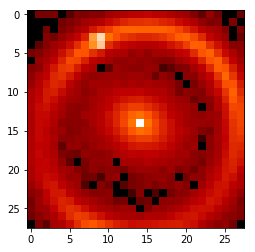

53
0.8700548152970884


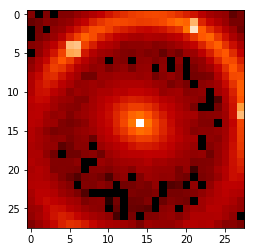

54
1.807369200471192


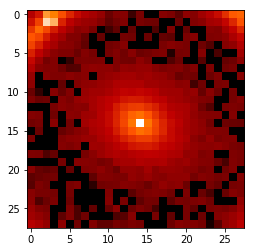

55
1.7674226035276845


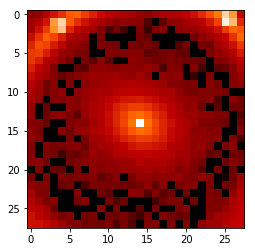

56
1.215734711432007


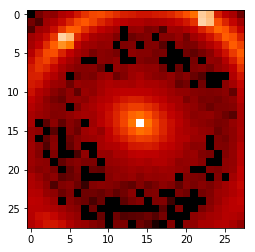

57
1.010382539236443


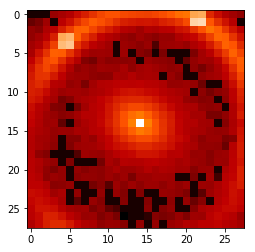

58
1.0684249879637047


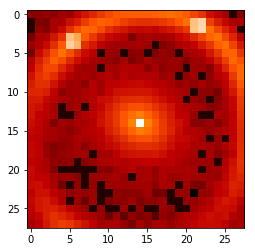

59
0.863186821161615


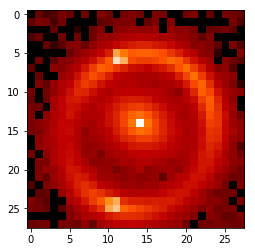

60
1.2935201098686528


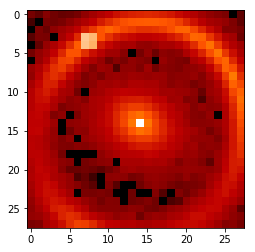

61
0.5852996474522535


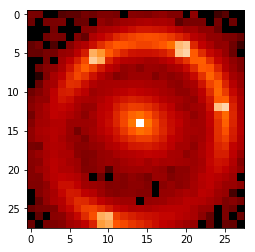

62
1.1033478381670592


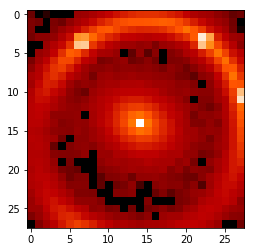

63
1.4412599326052975


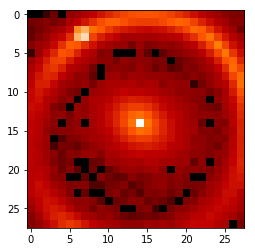

64
0.7200044483212944


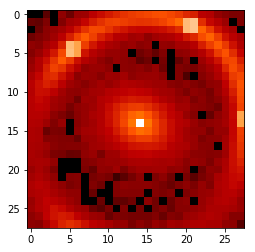

65
1.4673462358119362


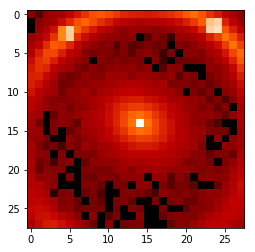

66
1.0079080990795262


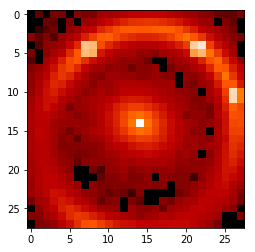

67
1.6805732460656608


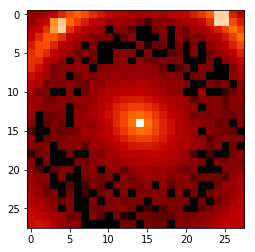

68
0.7960216797935988


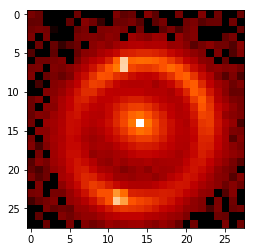

69
0.9702376816892392


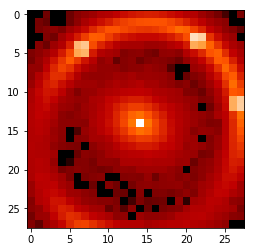

70
1.0887694307320188


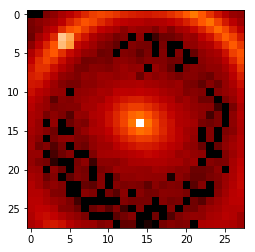

71
0.8591365096296242


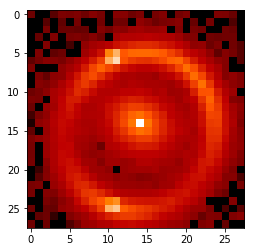

72
1.4938330612094082


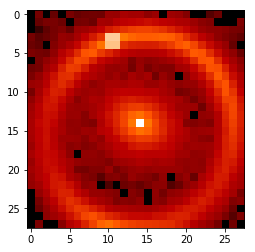

73
1.0857244112356383


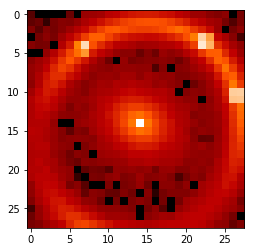

74
1.1394088258455128


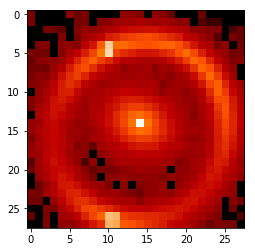

75
0.8003197146030661


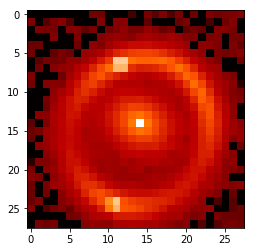

76
1.2317735699875552


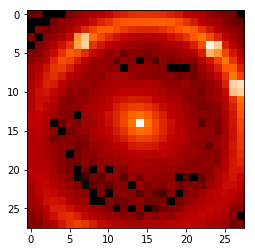

77
1.8056809345834386


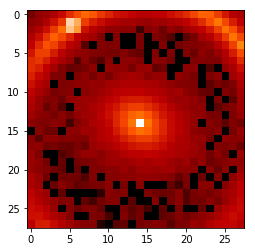

78
1.561764341919711


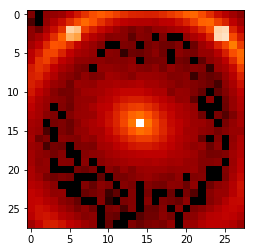

79
0.7510339673051777


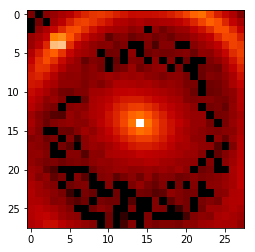

80
1.300968217729624


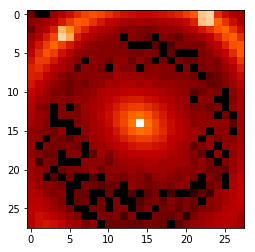

81
1.4875810632154693


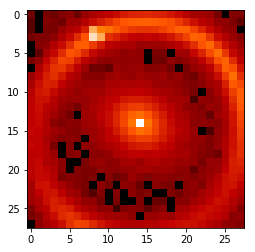

82
0.640093514377608


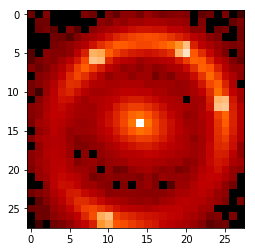

83
0.5920435342352455


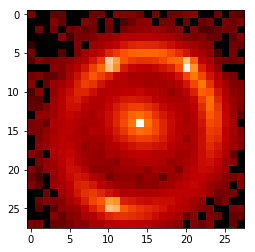

84
1.1225169845225298


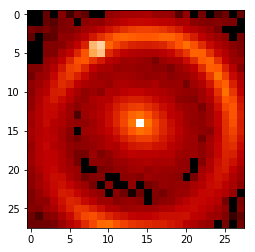

85
1.6270911756198874


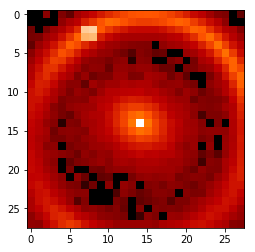

86
1.6825838227641012


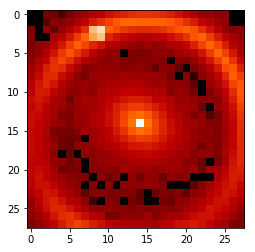

87
1.6564323537362589


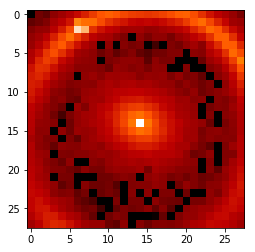

88
1.902430541927155


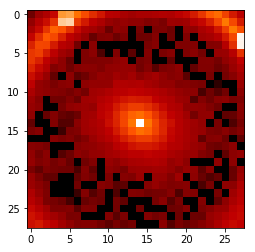

89
0.30423215898187184


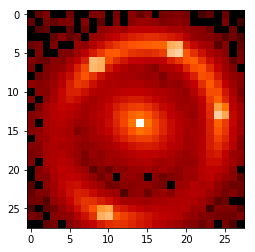

90
1.2658246595978775


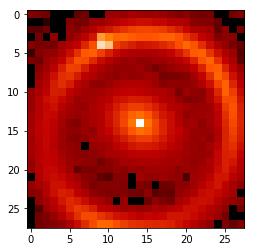

91
0.937085214150445


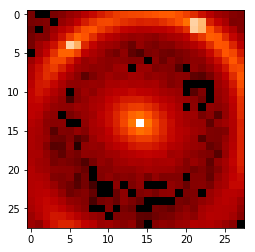

92
1.5537502497144393


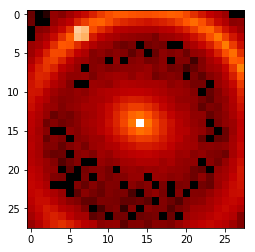

93
0.5943383823125453


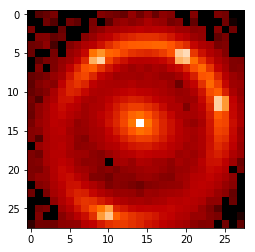

94
1.3324020548406297


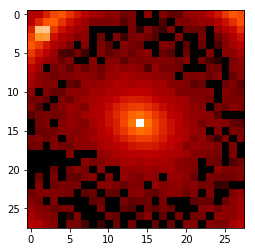

95
0.3099805634563253


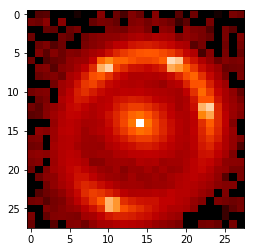

96
1.0841219578178332


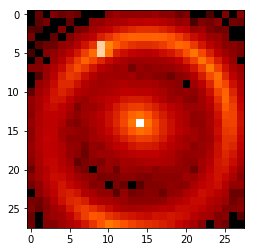

97
0.7719133683979351


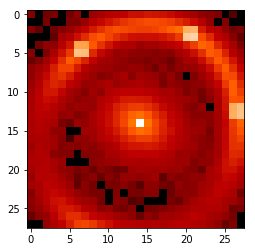

98
1.3024423662486952


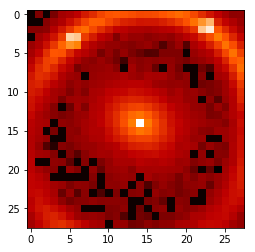

99
0.6659802819816216


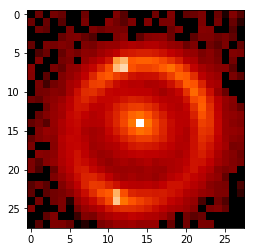

[0.5, 0.5, 0.1]
0
1.1904701761111014


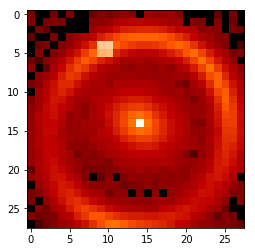

1
0.5690248620509654


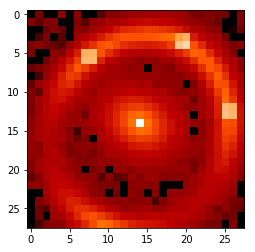

2
1.0169822539444628


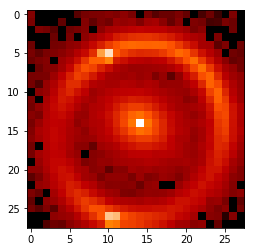

3
1.086299735848237


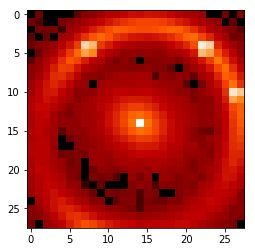

4
1.0837002887882976


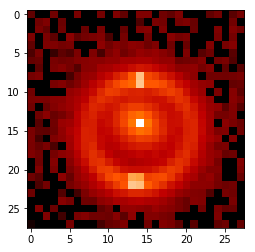

5
0.9498911172273456


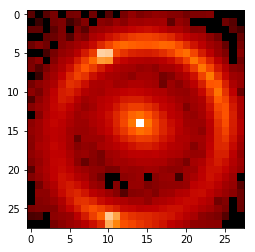

6
0.8321372053250718


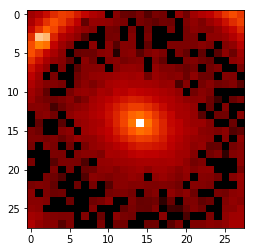

7
1.3759025072095927


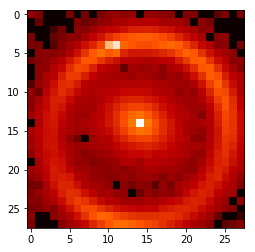

8
1.5609688881695791


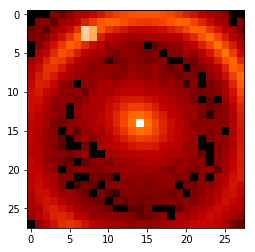

9
1.9541405433433274


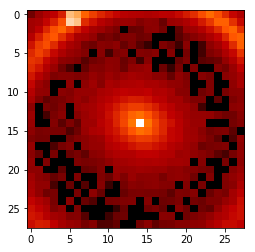

10
0.7364330784323552


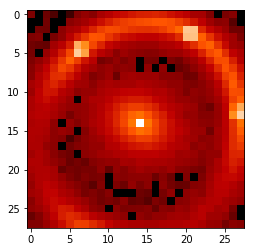

11
1.4471666947171924


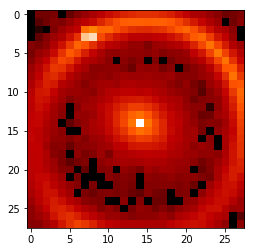

12
0.5421931419884687


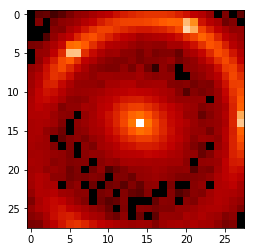

13
1.451971911224882


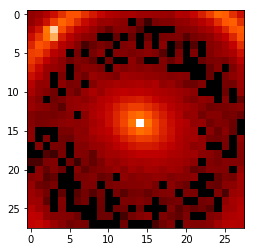

14
0.70307605337837


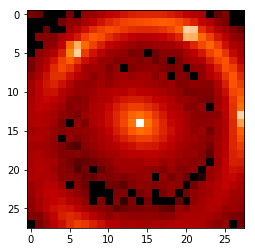

15
1.283748227113584


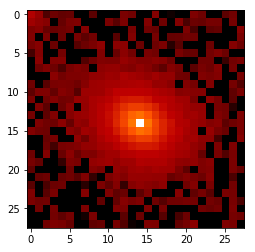

16
1.5482917459990067


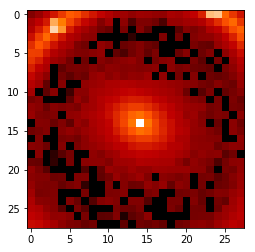

17
0.9827860145989169


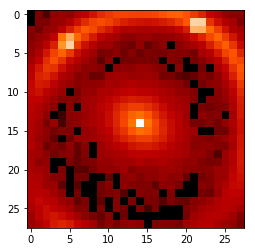

18
1.5615306734304082


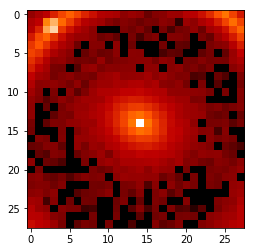

19
1.4718504060710813


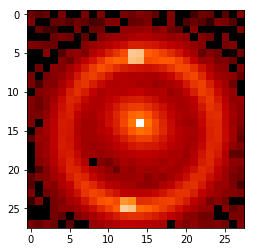

20
0.6676544346279606


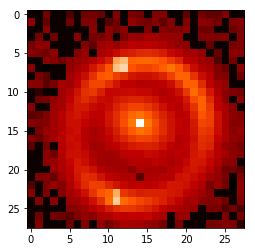

21
1.3879824285657287


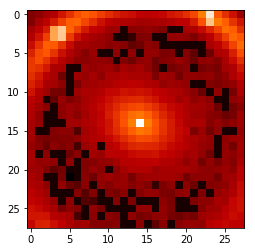

22
1.5539049629781316


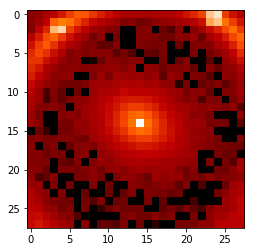

23
1.1255023082970899


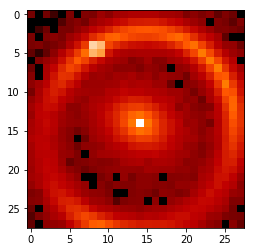

24
0.8412073894116865


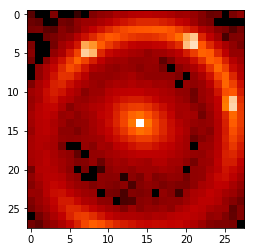

25
1.781713840844997


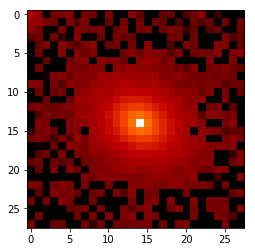

26
1.634461925854096


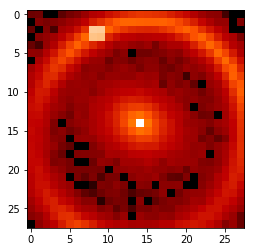

27
1.205088522088365


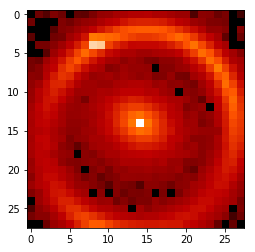

28
1.5693235013583389


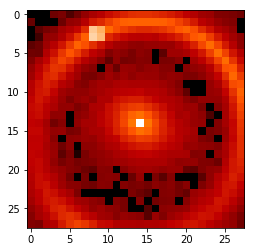

29
1.5453110359693303


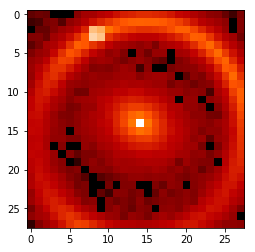

30
1.1614439835921317


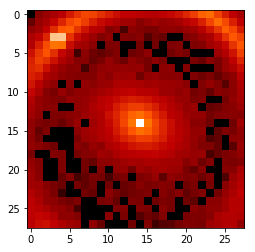

31
1.6674334957410193


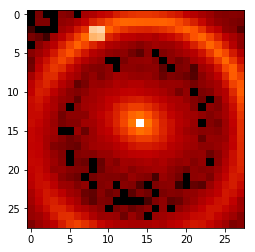

32
0.9201650564569259


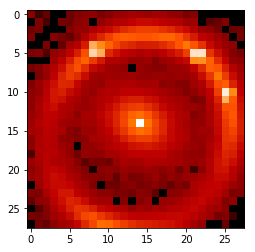

33
0.8041980194841944


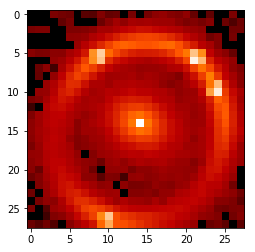

34
1.1088445555313529


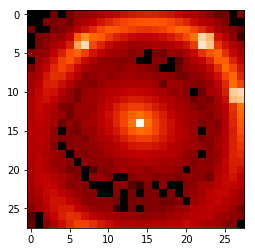

35
1.1044774152825187


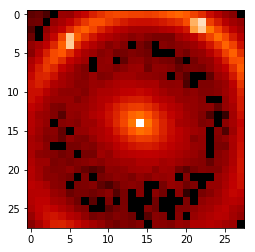

36
1.097194215778489


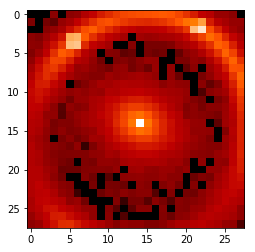

37
1.2577806760015748


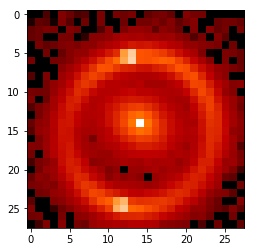

38
1.2648744193542685


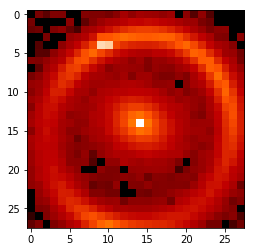

39
1.8255340324450708


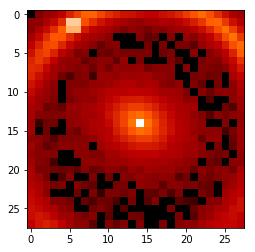

40
1.3607680531918387


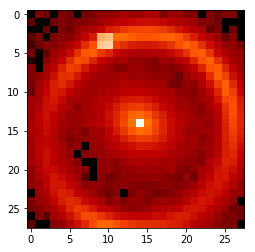

41
1.3183627303834158


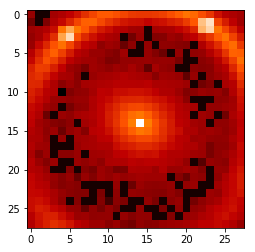

42
1.4346132650571835


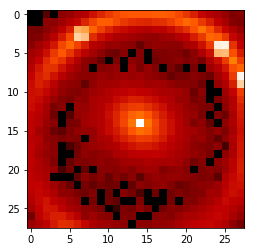

43
1.164689621171538


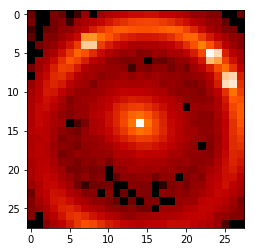

44
0.8119470991010986


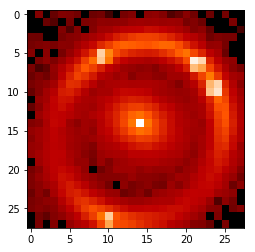

45
1.3517741394041434


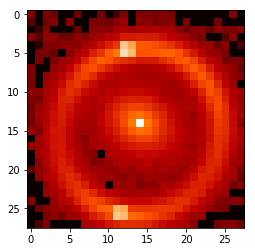

46
1.329071415781338


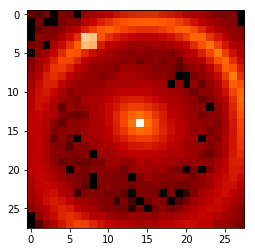

47
1.5042255911930502


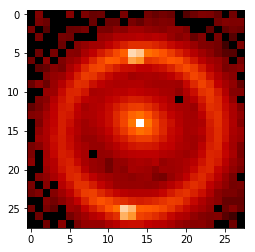

48
1.3042487962937195


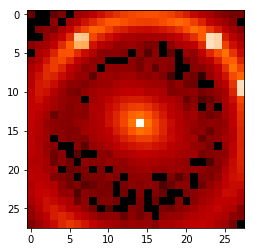

49
1.896535913584294


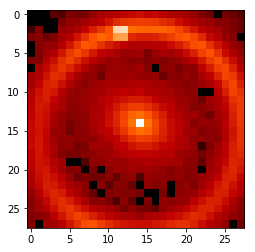

50
1.1485782715436557


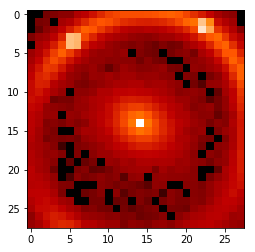

51
1.329890159378815


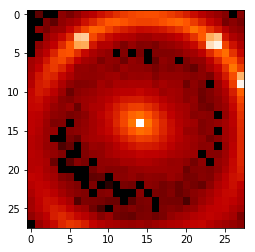

52
1.2715350355383424


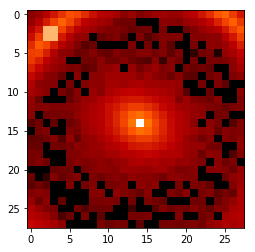

53
2.0075346745276494


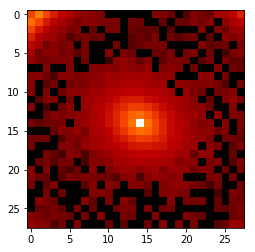

54
1.128440360857228


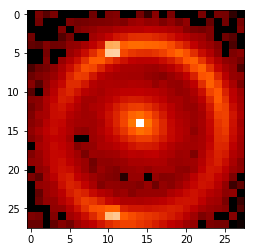

55
1.6953510355936803


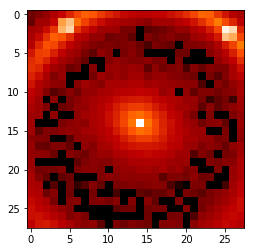

56
0.8814497617124453


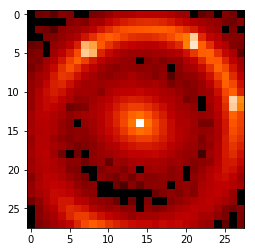

57
1.260298537847551


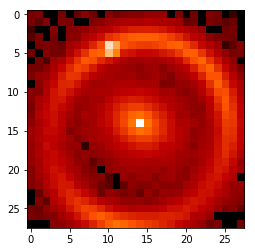

58
1.1343042932707657


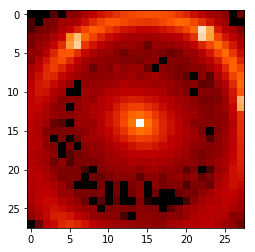

59
1.9028121874214277


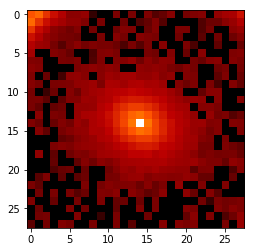

60
1.4607706253474637


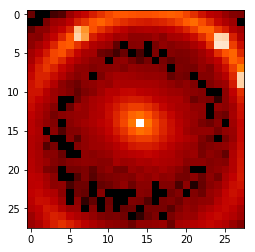

61
1.8058017702880615


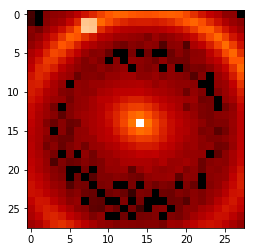

62
2.358373354135786


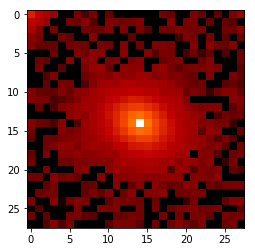

63
1.5024212201158629


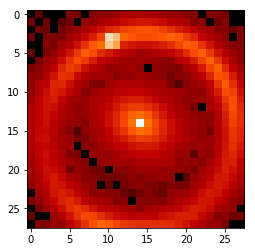

64
0.6304639246275017


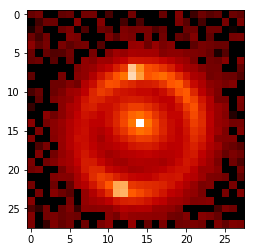

65
1.3012858982927964


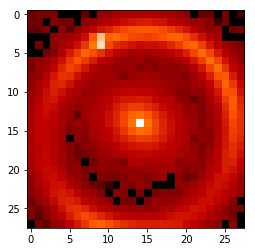

66
1.7190775013369395


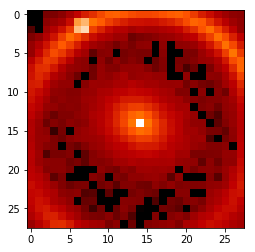

67
1.4541959871643453


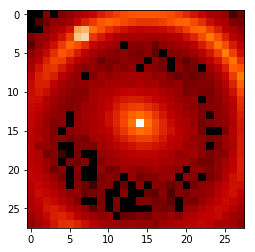

68
1.2954570519799624


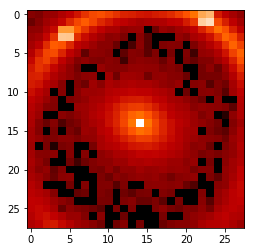

69
1.2096437981967356


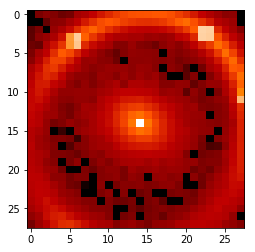

70
0.9365992754556627


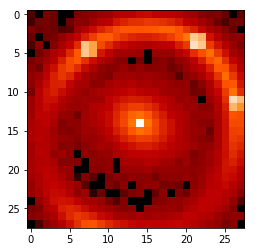

71
1.2495555604452289


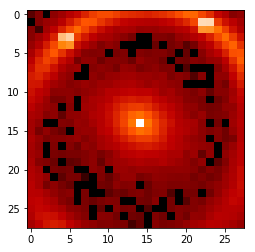

72
1.532982652225026


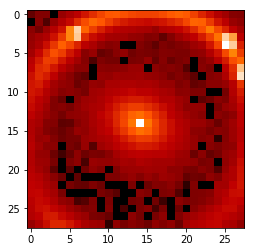

73
1.48215191291179


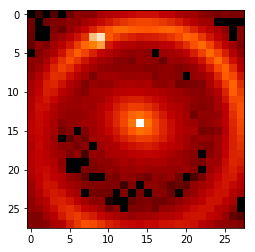

74
1.6510237250851416


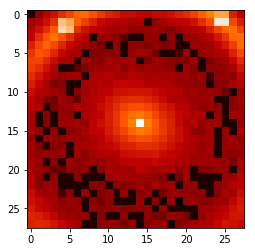

75
0.8619335835724231


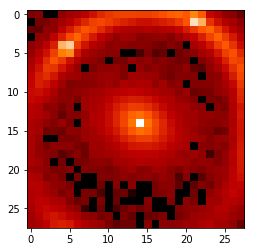

76
0.8783938213443787


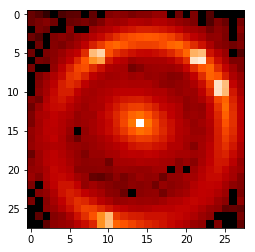

77
1.2787780674052032


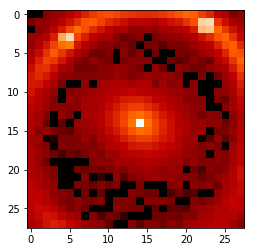

78
1.649279744497352


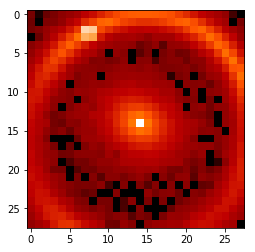

79
1.8825080187865653


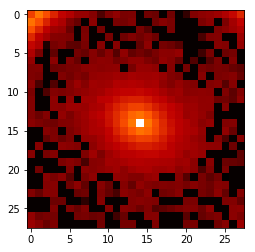

80
1.0951722226967533


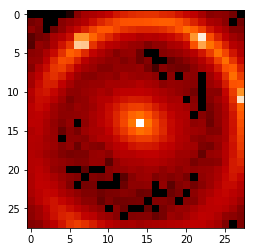

81
1.7305964764460673


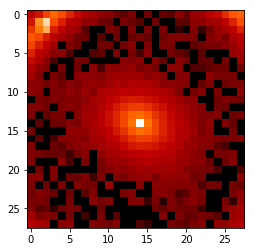

82
0.5615817154727824


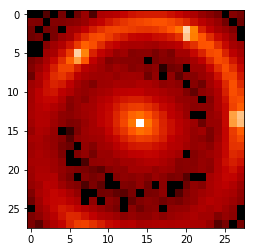

83
2.043144765238745


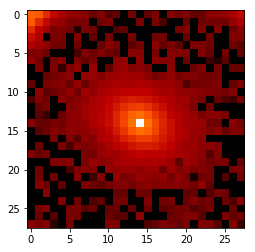

84
2.2716968822011436


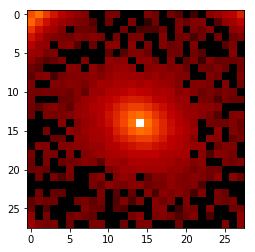

85
1.8231106243738877


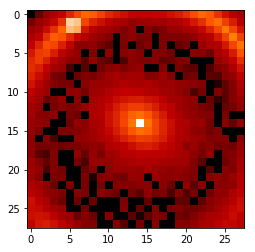

86
1.0913658194475029


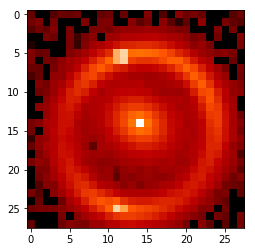

87
1.0192423437826934


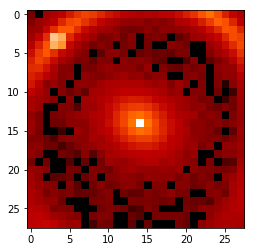

88
0.8158099191740411


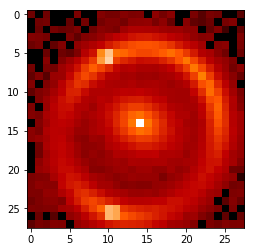

89
1.6824138988854427


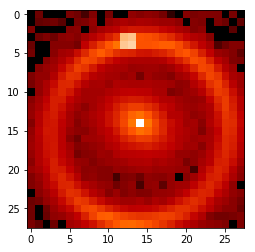

90
1.1480885946779702


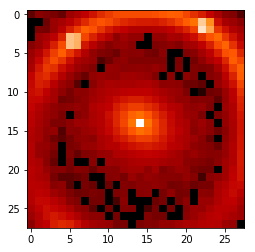

91
2.039090718183309


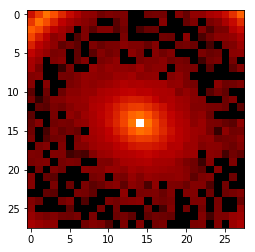

92
1.5016799710188506


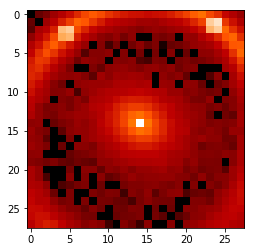

93
0.46348596655631236


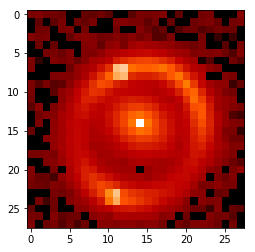

94
1.1151491123642976


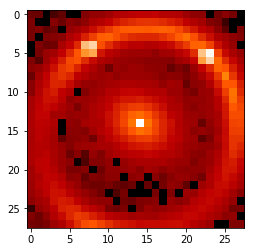

95
1.1310511015039038


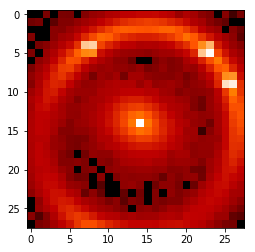

96
1.4228291842652165


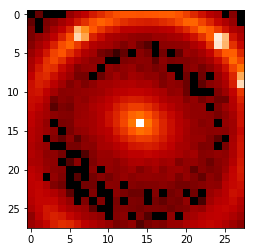

97
0.9733285490184937


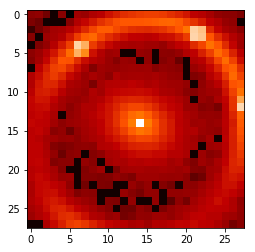

98
1.3854788568439131


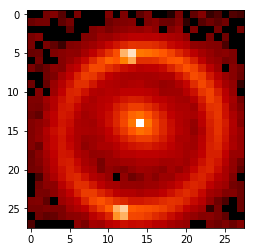

99
1.8131287018552613


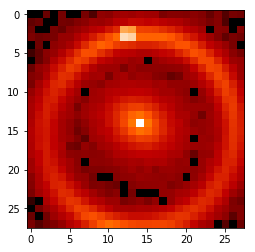

[0.5, 0.5, 0.1]
0
1.4662575967210814


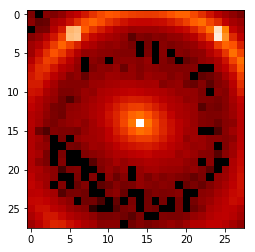

1
1.1236995890773867


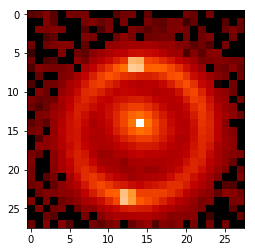

2
1.16417455988746


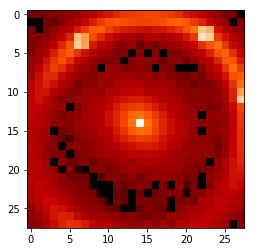

3
1.6937097970201225


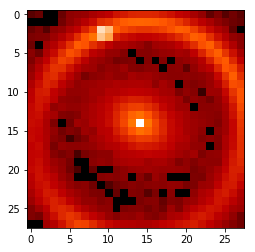

4
1.6551666167598569


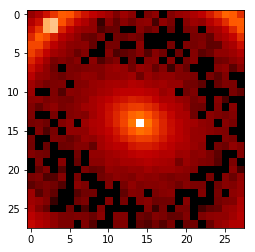

5
1.0459686239434824


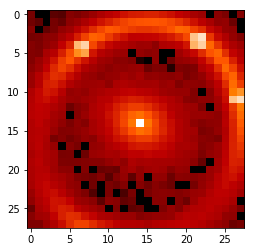

6
0.606176178152669


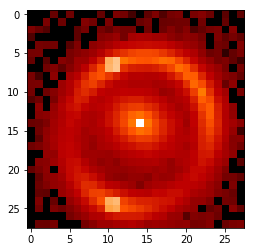

7
1.390368858260286


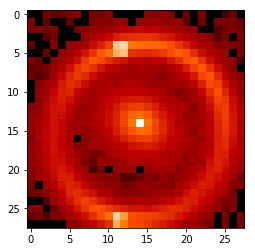

8
0.5514963346171413


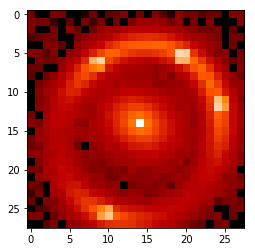

9
0.7960137698151426


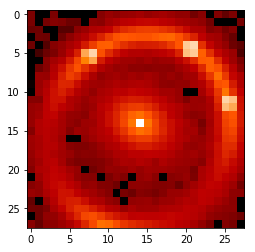

10
1.2558558442096128


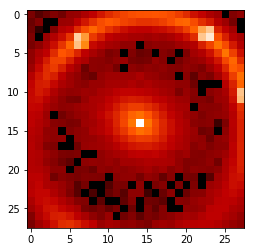

11
0.7529939888810642


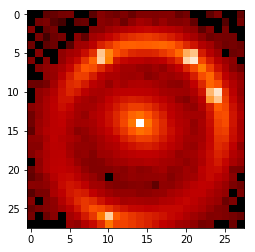

12
1.523507225257509


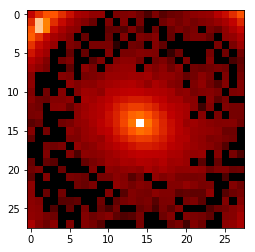

13
2.051466087241284


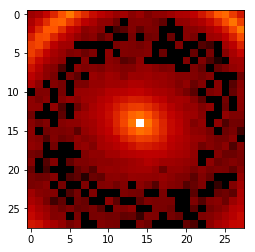

14
1.6555851106984214


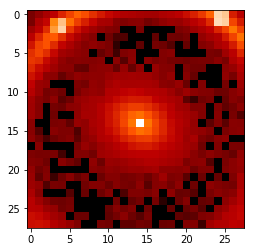

15
1.0791482968042816


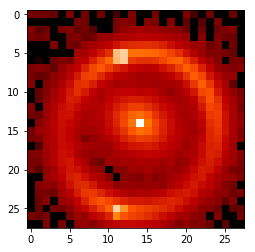

16
1.5861536652409323


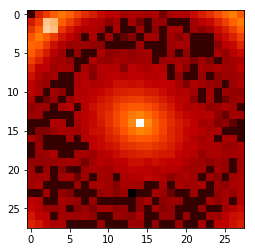

17
0.7462247324169077


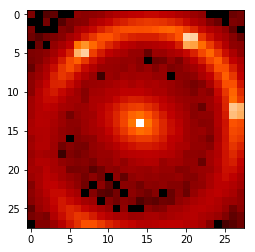

18
0.1274390489496109


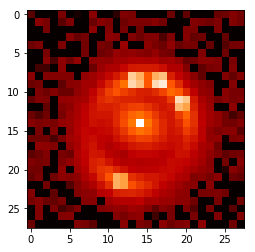

19
1.3606997219070731


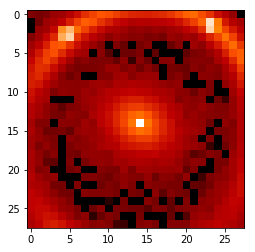

20
0.7171436465955122


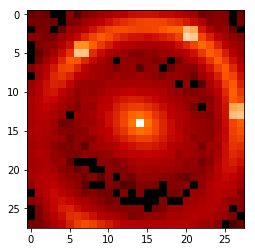

21
1.7301565451305927


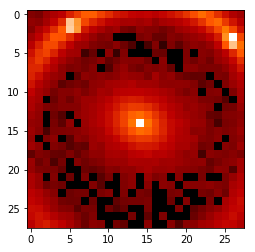

22
1.5593243807065464


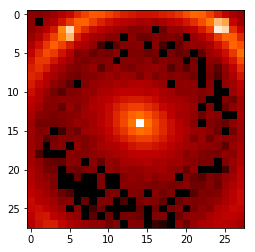

23
1.4422689569486105


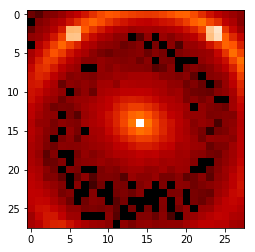

24
1.712885085332957


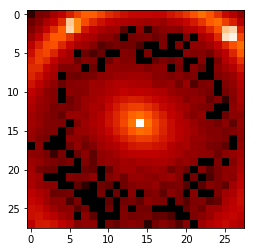

25
1.7889837947523977


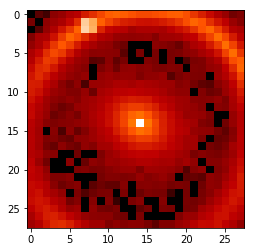

26
1.076539736412531


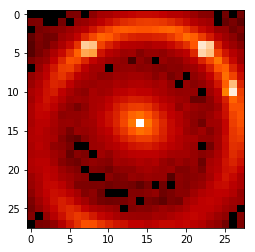

27
1.0853207630958355


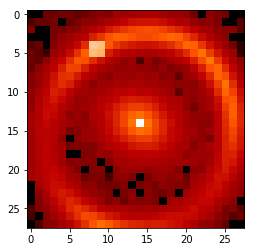

28
1.1847700158737493


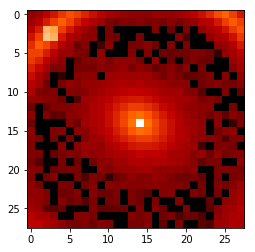

29
2.2403587999662258


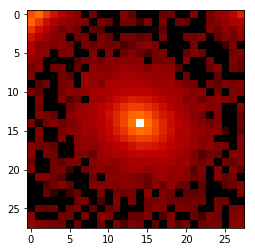

30
1.2187243356356106


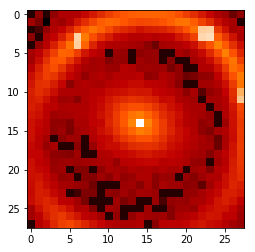

31
1.1289830099026799


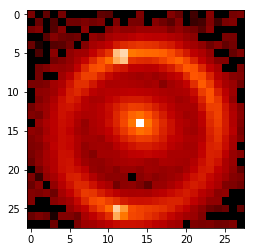

32
1.4336797247181126


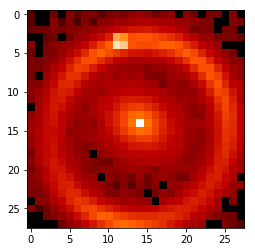

33
1.7262822341849997


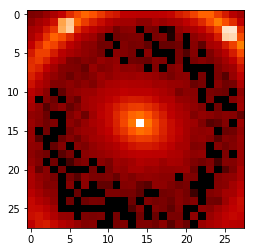

34
1.243021156400639


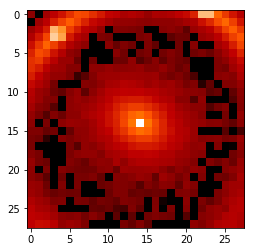

35
0.8471416473955518


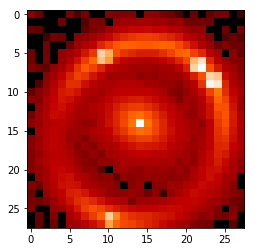

36
1.2922172642547476


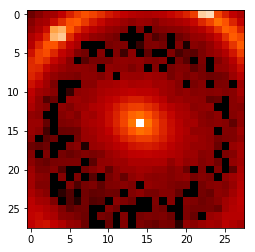

37
1.76877004549453


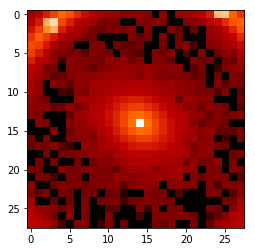

38
0.793933198370768


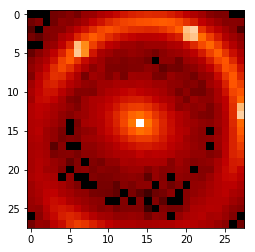

39
0.8969857988756693


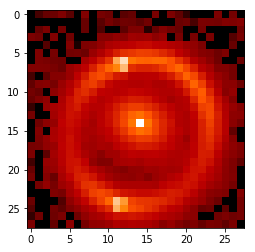

40
1.0746375157097015


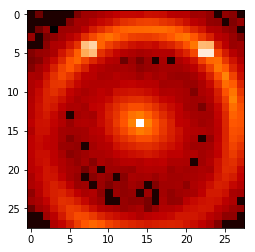

41
1.4675642580467168


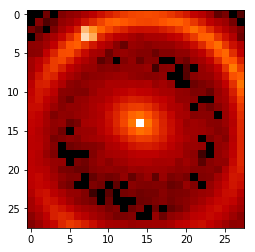

42
1.1517374698275462


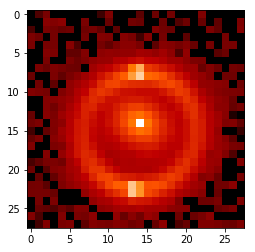

43
1.0904783989499003


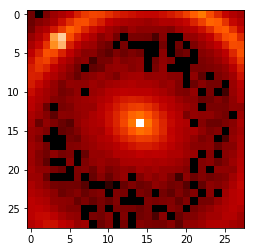

44
0.9042568811004661


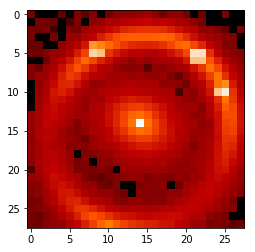

45
0.8209227799088457


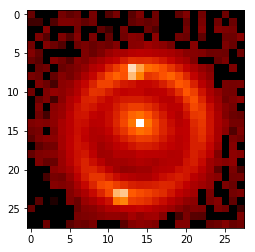

46
1.0004345364099598


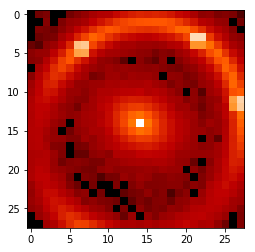

47
1.3984593811036654


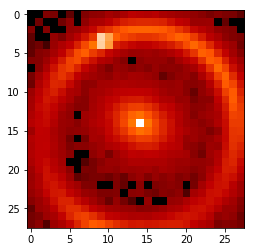

48
1.4862522887151517


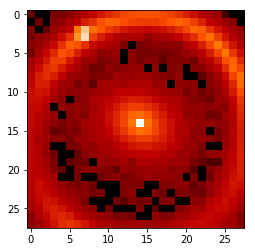

49
1.2767275314240527


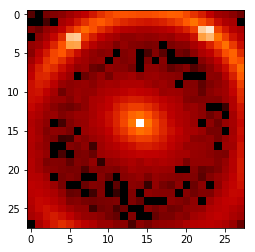

50
1.7442587559498457


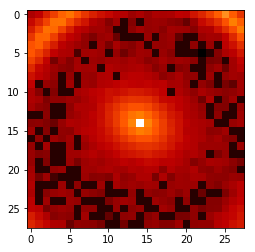

51
1.6600244614479245


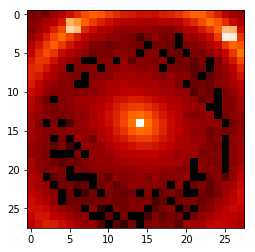

52
0.7292627024258915


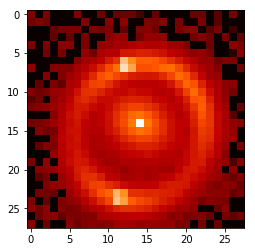

53
1.281361129030584


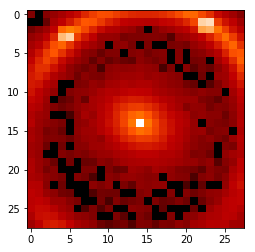

54
1.1087179723250402


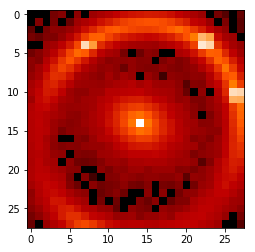

55
1.24166129112762


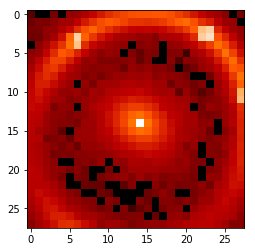

56
1.0802779722479554


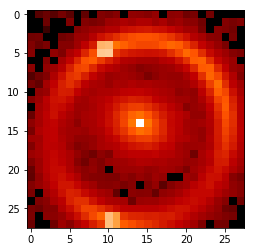

57
1.3971192075840955


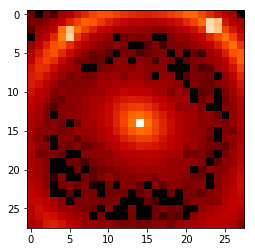

58
1.032507351261976


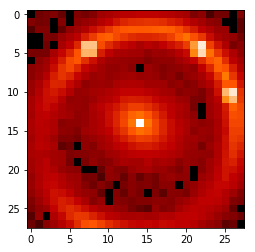

59
1.7629325028001608


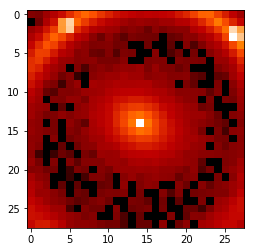

60
0.9655364630121841


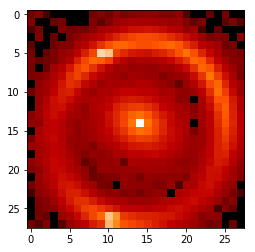

61
2.184491828047874


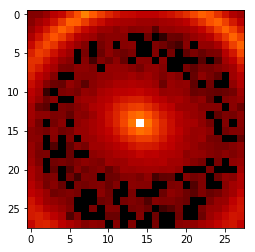

62
0.8814649888089087


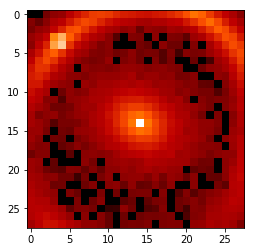

63
1.3002181662359753


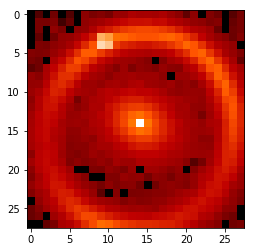

64
1.1795658247582188


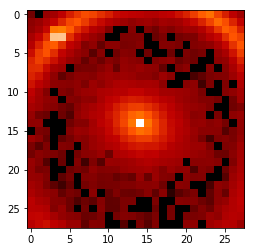

65
1.1223400672751886


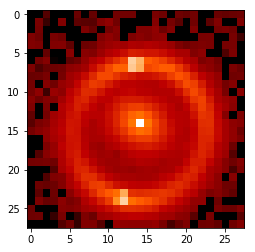

66
1.3797837381911409


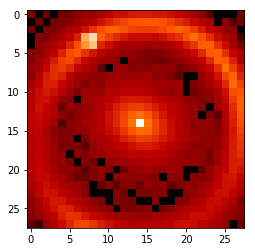

67
1.2664618017897997


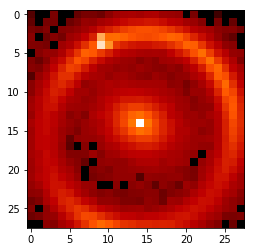

68
0.5549638926594531


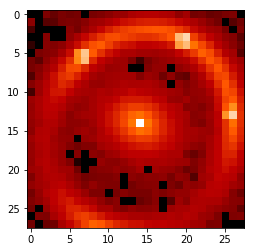

69
1.356783515924225


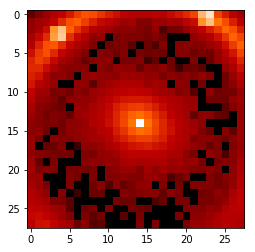

70
0.6821210063325478


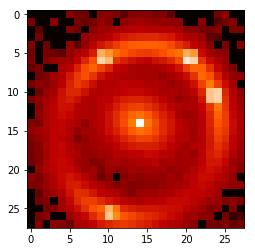

71
1.280877466593023


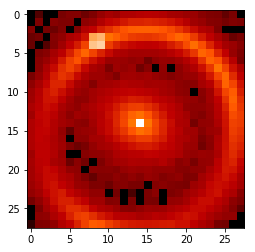

72
1.3794603621336856


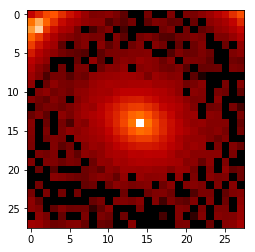

73
0.6253359504128283


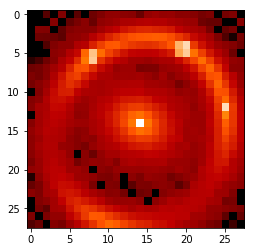

74
1.4302752959394267


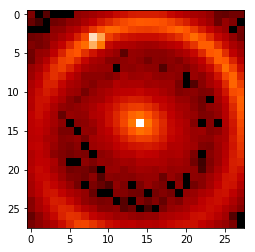

75
0.7802654000454065


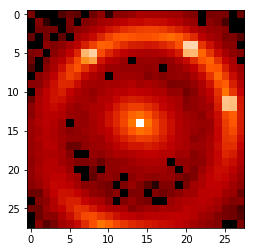

76
1.308671467490059


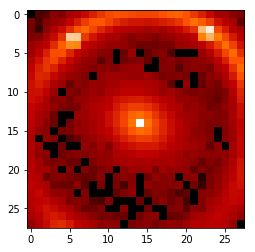

77
1.121871863076087


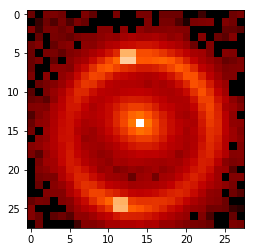

78
0.809918036666827


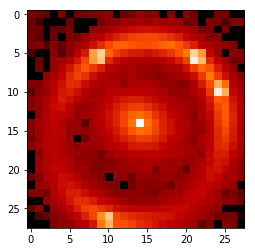

79
1.169563307275695


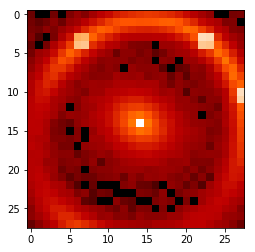

80
1.3852266062238336


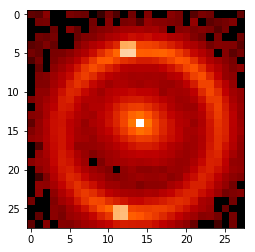

81
0.7534760126737284


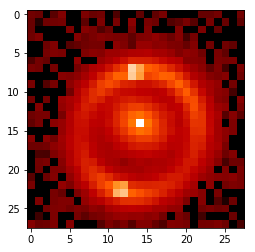

82
1.6815184061778243


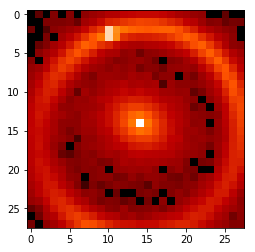

83
0.8579368896037304


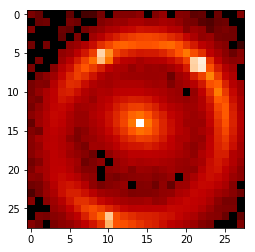

84
1.196010178304166


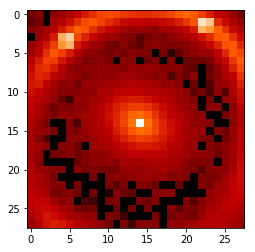

85
1.126948106639275


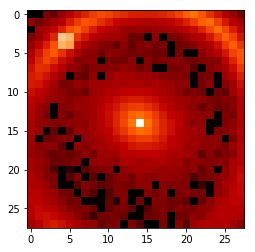

86
1.4701346806863422


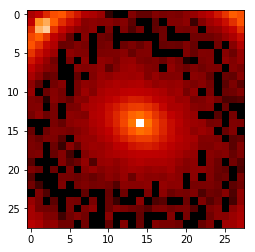

87
1.4027447691711408


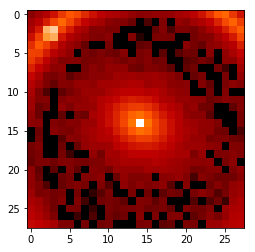

88
0.8122908293367768


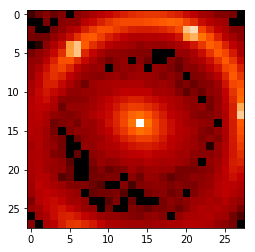

89
0.6386646186031891


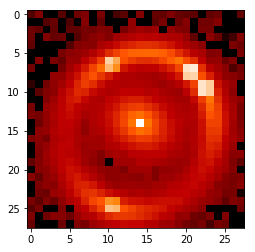

90
0.8107629426240892


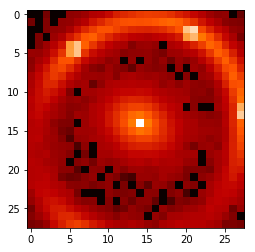

91
1.1454378198697683


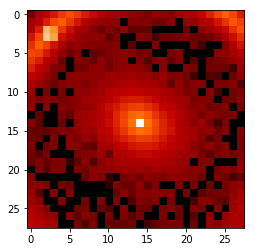

92
0.673973485597942


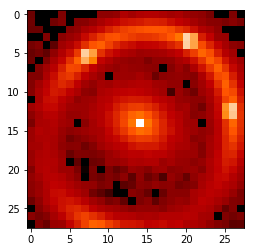

93
1.0002360749985122


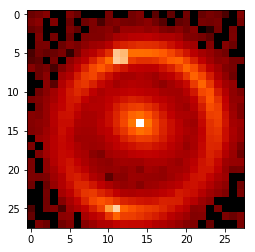

94
1.0187457896015775


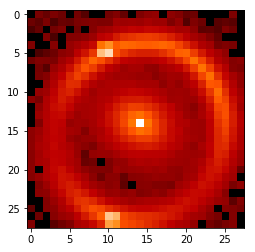

95
0.601476694726565


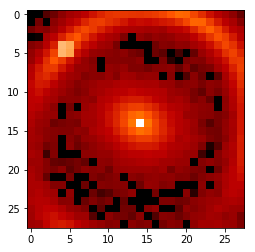

96
1.094778303200282


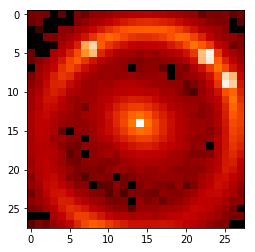

97
1.1479327737364022


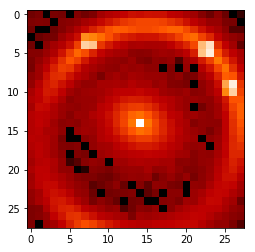

98
1.0860182783018335


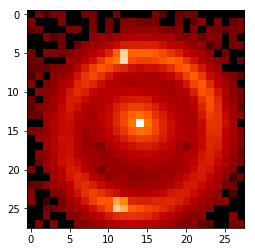

99
1.3736898387715126


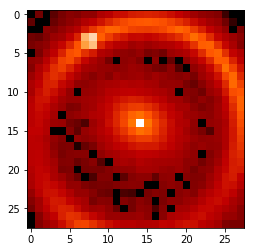

[0.5, 0.5, 0.1]
0
1.7398805921296199


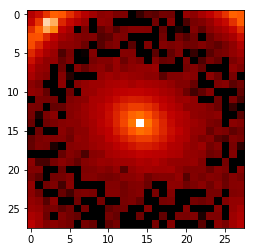

1
1.1581722576368925


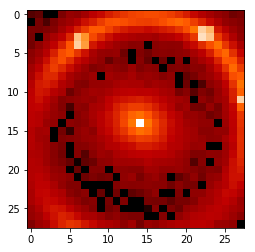

2
1.2921838766938802


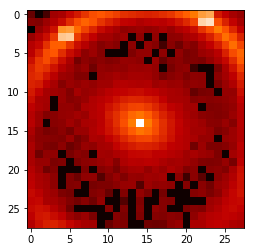

3
1.6462648003814664


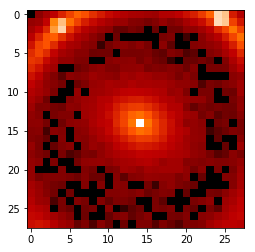

4
1.6393837729956318


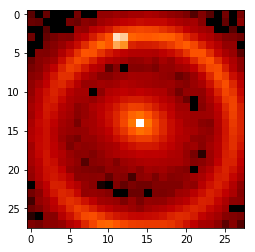

5
1.5976450027540348


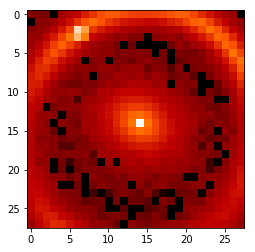

6
1.387410169710798


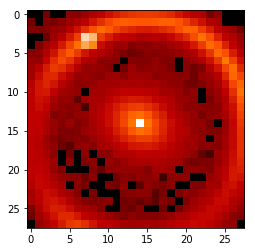

7
1.7998809973782524


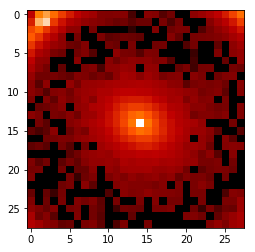

8
0.4296901231256186


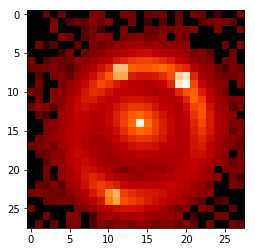

9
1.6387649672827869


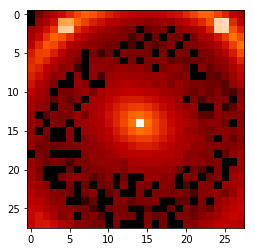

10
1.1907377993660997


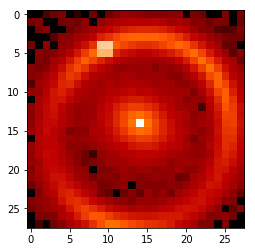

11
1.1338287696655953


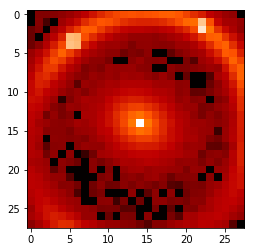

12
1.3184118941919074


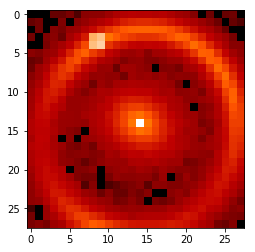

13
1.3855008433263125


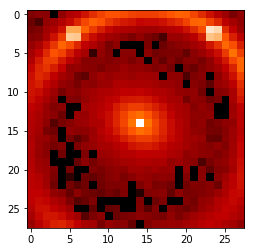

14
1.4399004608928319


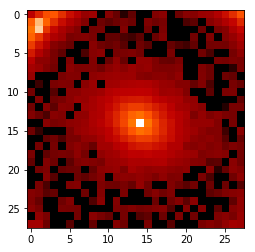

15
1.1663626907132718


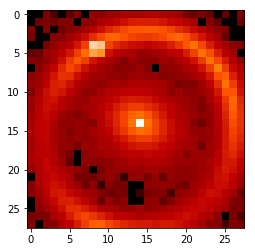

16
1.49427518136173


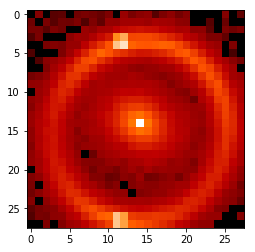

17
0.9594759074122927


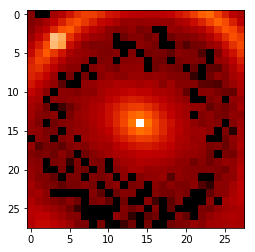

18
1.1957043220461523


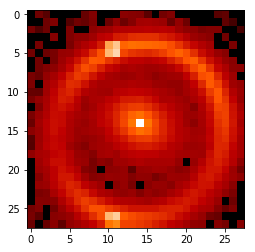

19
1.025125090428502


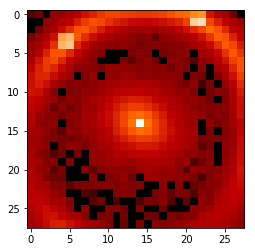

20
1.3255215690301358


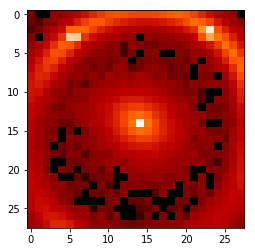

21
1.391717925712282


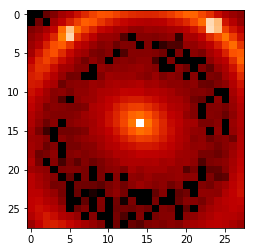

22
1.0386630231099283


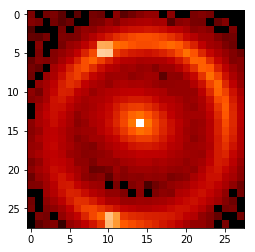

23
1.805560951000058


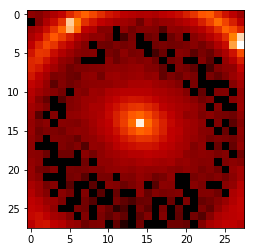

24
1.1218952742993515


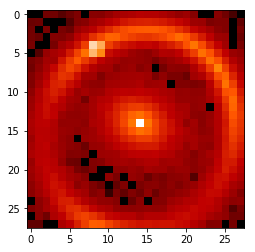

25
1.822048303936503


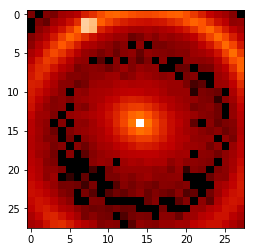

26
0.8512571780291576


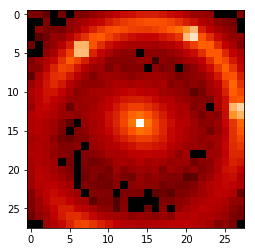

27
0.8062246395920152


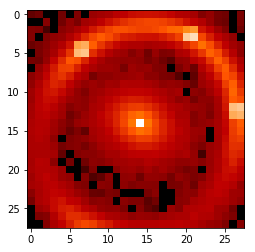

28
1.8305670047029745


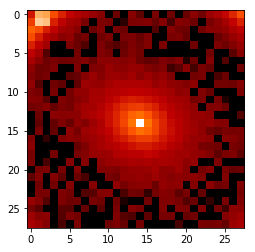

29
1.3770092254604294


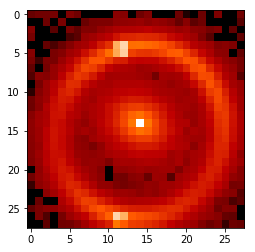

30
0.8078717674479183


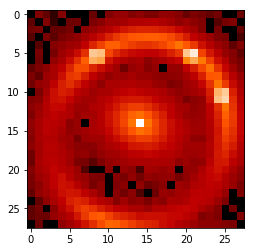

31
1.2617939600840058


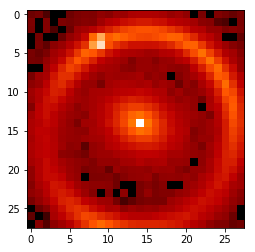

32
1.1153599128844507


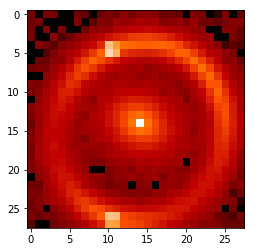

33
0.9621993096044046


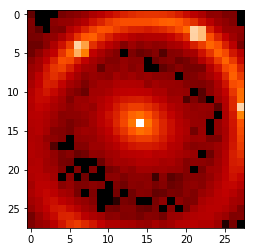

34
1.1535864561352516


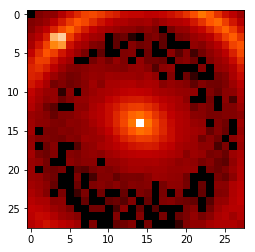

35
1.2636220283076565


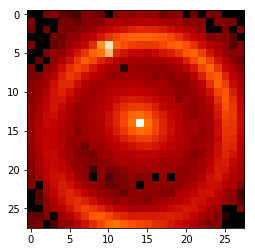

36
1.050913519746315


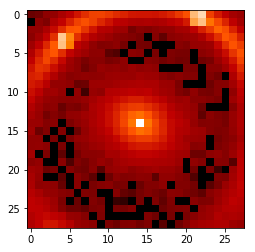

37
0.37840230161047184


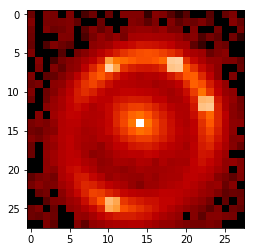

38
0.9874841096948003


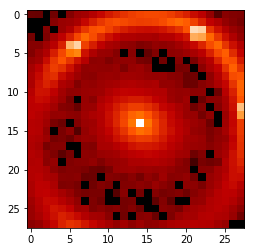

39
1.5729407148182468


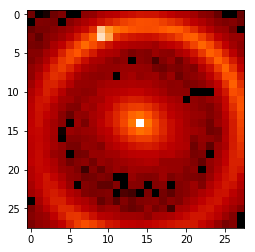

40
0.9302517573937193


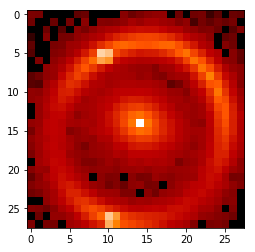

41
1.302523007701181


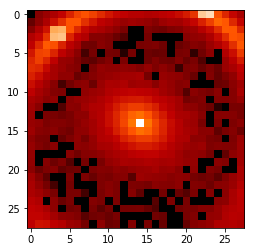

42
1.0232341703916483


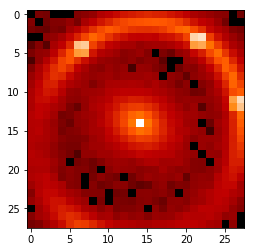

43
2.0004230611594225


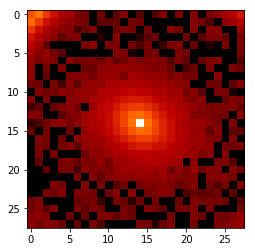

44
0.5916004081179197


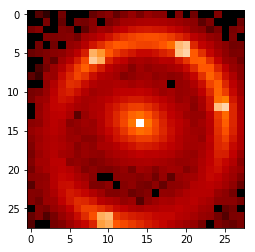

45
1.0578711413810014


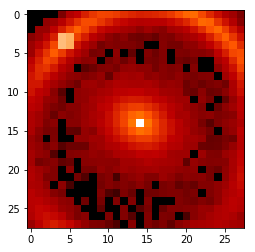

46
1.9712161023449377


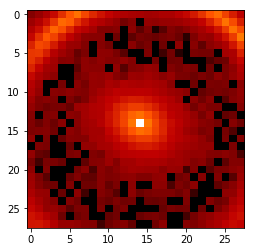

47
1.065605630997479


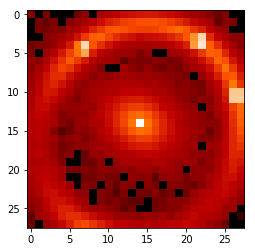

48
0.4782892465880523


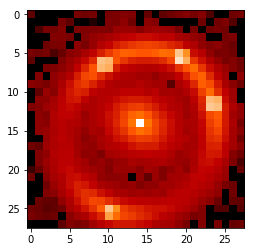

49
1.1222367014156887


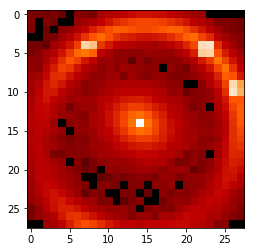

50
1.189239279830321


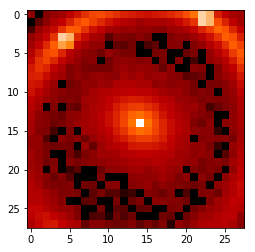

51
1.8380349767152997


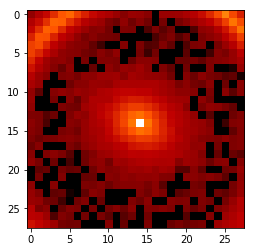

52
0.6402025230989153


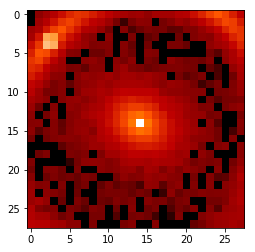

53
0.7913812597819192


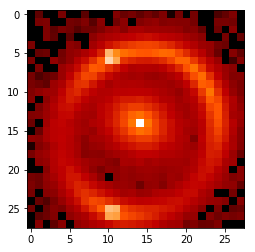

54
1.3767426915332608


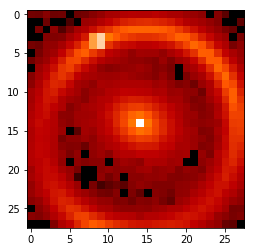

55
0.9249386830205262


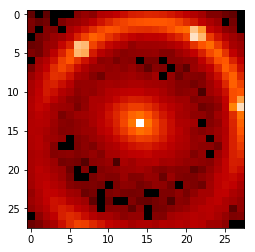

56
1.3526938515754587


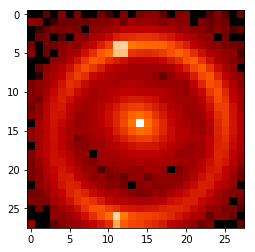

57
1.2324299373657188


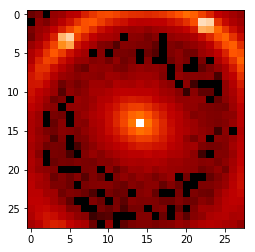

58
0.9958516666632593


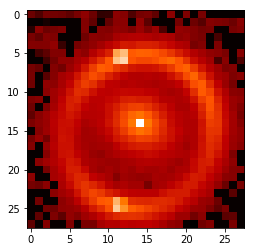

59
0.6510474584101572


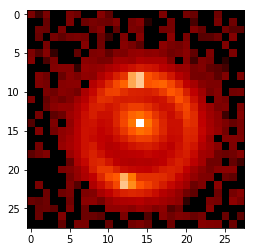

60
1.5603601974526855


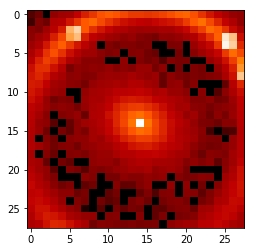

61
1.0923577739677848


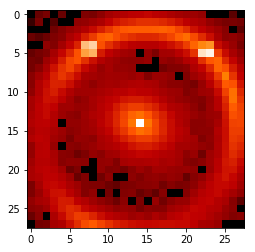

62
0.9540039573040437


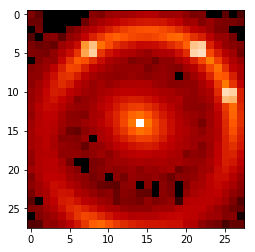

63
1.2831845800249746


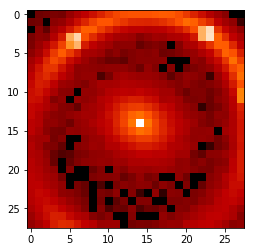

64
1.3531113204627974


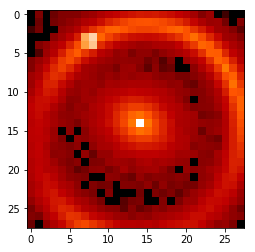

65
0.8091651397811717


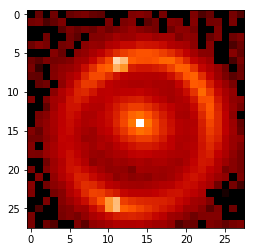

66
1.1573837503475322


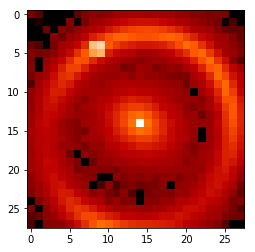

67
0.9891326814732703


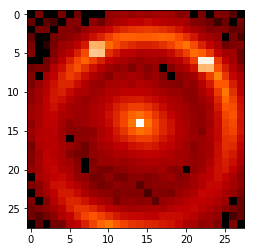

68
1.181047797520862


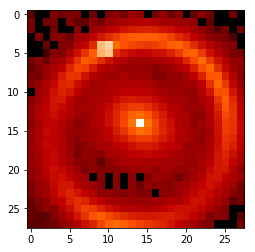

69
1.4620043098917646


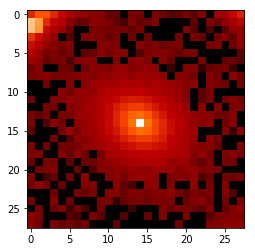

70
0.9227018328134232


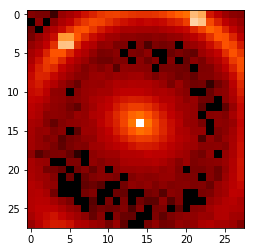

71
1.8142295139759632


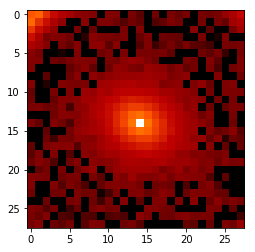

72
1.0055191589616839


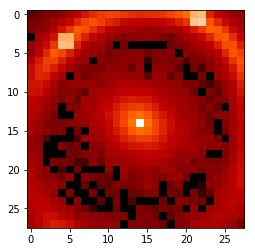

73
1.3631861585287537


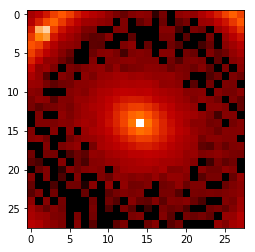

74
1.0350992149151816


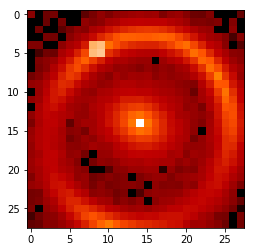

75
0.8076606008727001


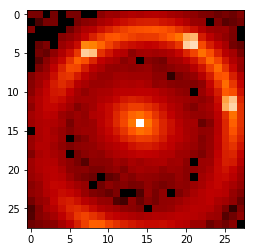

76
1.1646312952943843


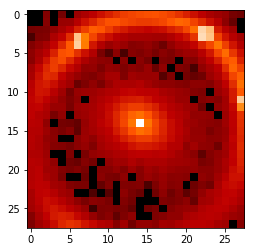

77
1.5688882998297065


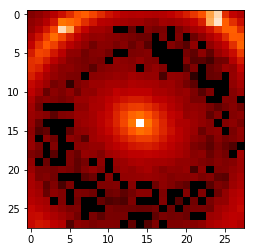

78
0.9587433468696611


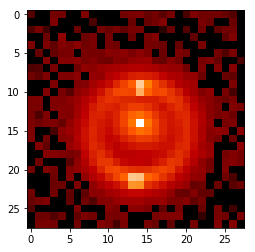

79
1.5573759170658086


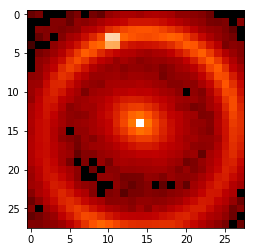

80
0.9965984857497403


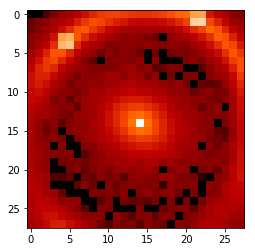

81
0.5320295564108476


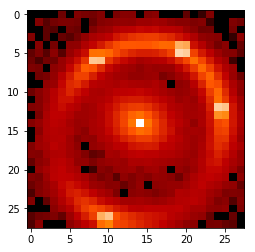

82
1.4344794437108614


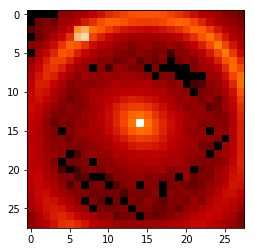

83
0.3596132663362017


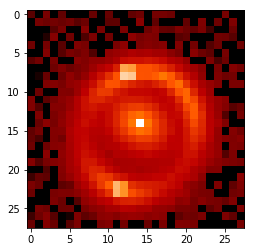

84
1.6731719631597315


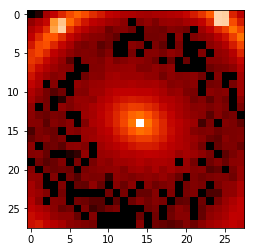

85
1.5943617185443233


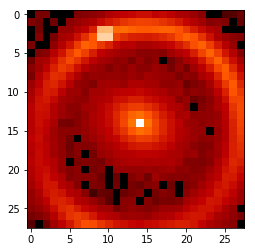

86
1.3222954263710678


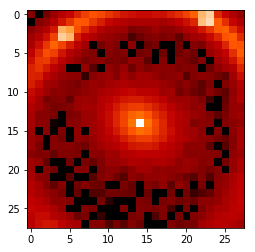

87
1.069125117085544


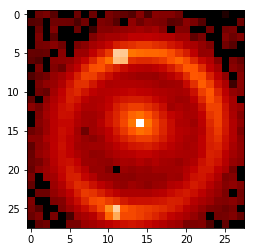

88
1.7825964522990172


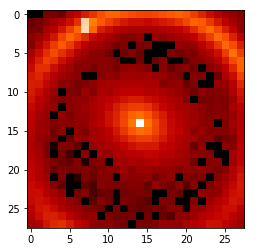

89
1.7724514859761433


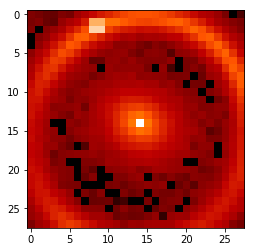

90
1.4948402462761023


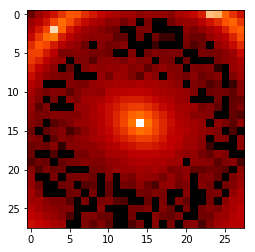

91
0.7031645228229129


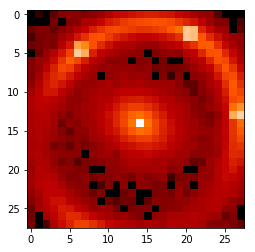

92
0.683741948940339


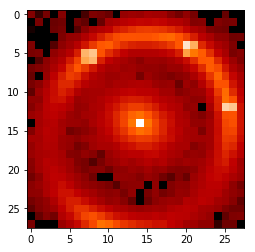

93
1.1058567164841981


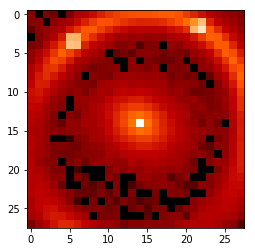

94
1.4489065068228721


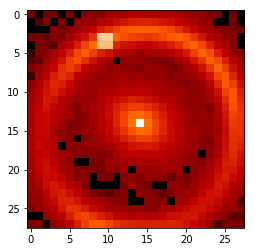

95
1.6697522753123404


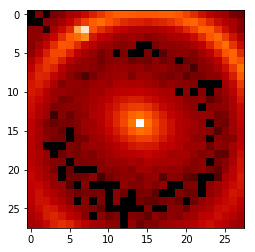

96
0.8363477118370677


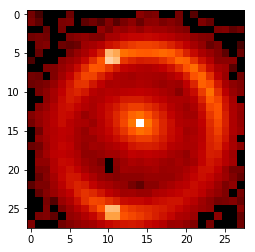

97
1.214262002294196


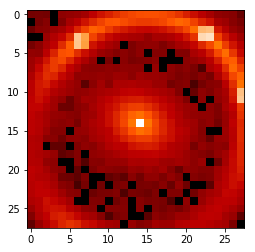

98
-0.001975212859375519


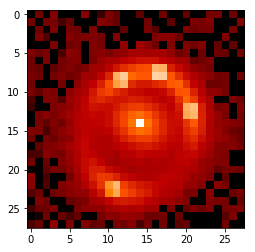

99
1.6653530328509767


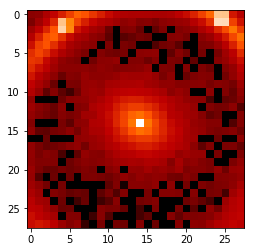

[0.5, 0.5, 0.1]
0
0.6641929189985118


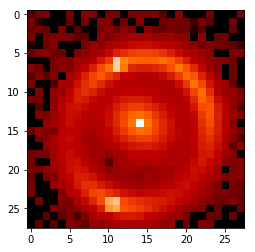

1
1.5811980940665828


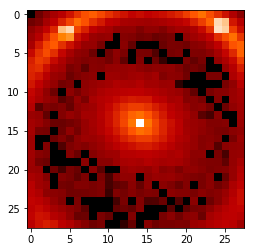

2
1.4304304228200948


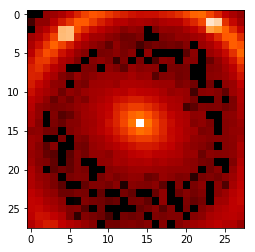

3
1.6212977651235272


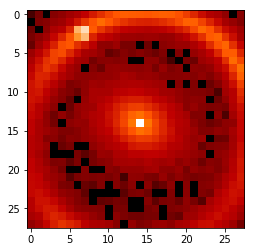

4
1.349689085102869


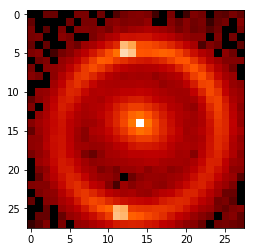

5
1.2118111167900667


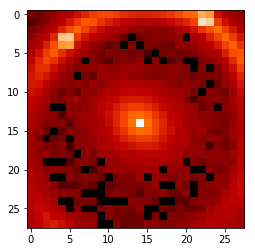

6
0.849437940030004


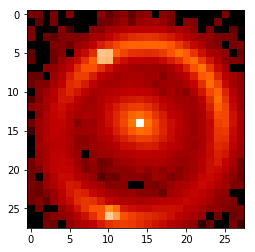

7
1.1952204621749918


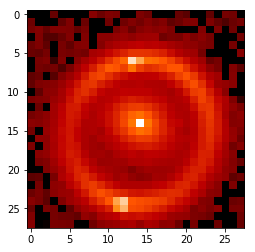

8
1.0685918503751115


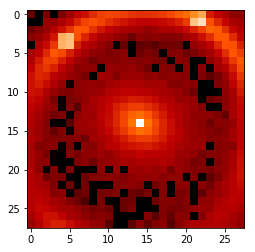

9
0.8665684087381524


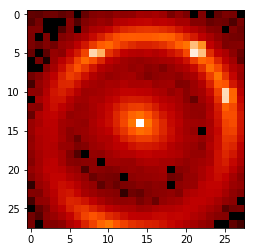

10
0.9123540320904265


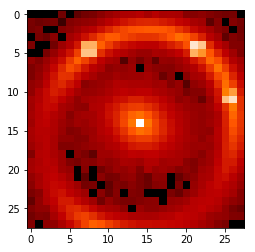

11
0.5492839381838268


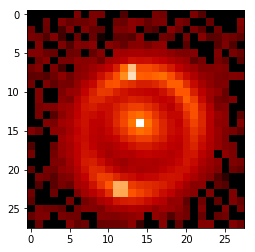

12
0.7887518013118646


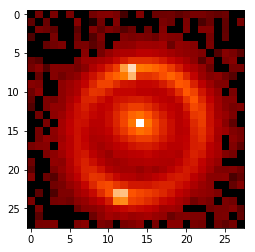

13
1.5964774713675633


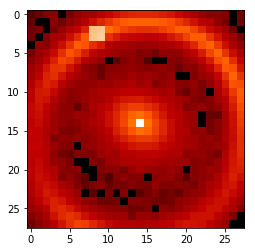

14
0.8333309280363932


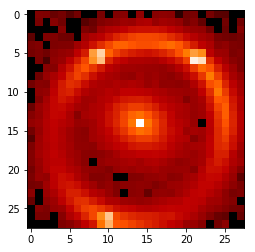

15
1.4783738033748548


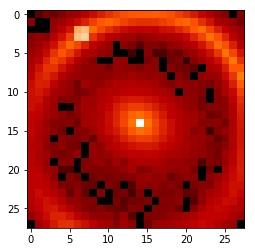

16
0.7133528144669307


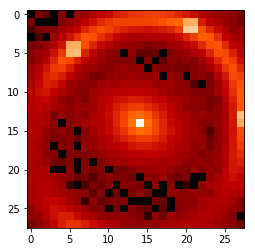

17
0.952705136670758


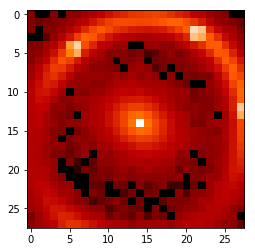

18
1.5272199195950782


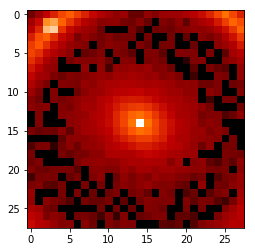

19
0.9758007639264685


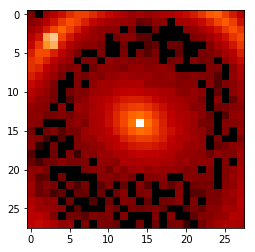

20
1.8664233846989045


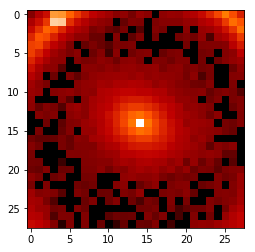

21
0.5647682024525029


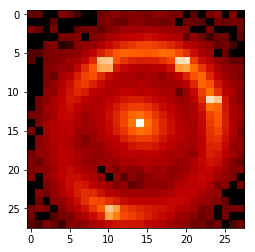

22
1.2778731230801261


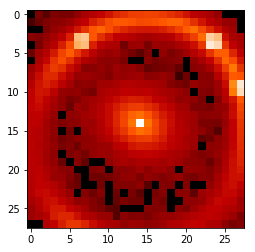

23
1.0007183484622875


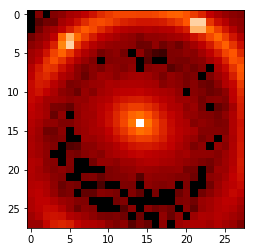

24
1.4099306500217532


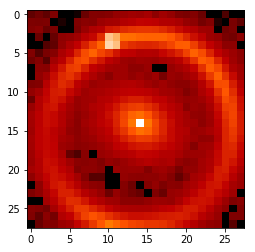

25
1.6480194425043138


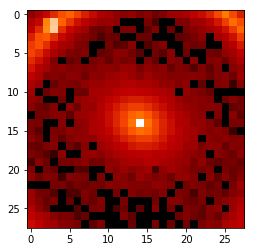

26
1.0511872125040496


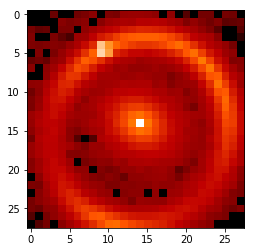

27
1.2003408942530458


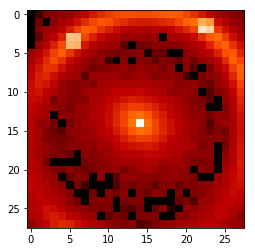

28
1.3696870383275448


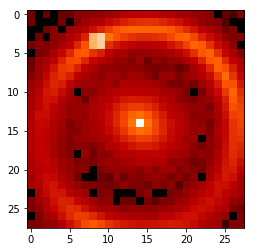

29
0.6007078450462777


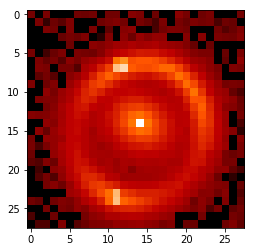

30
0.7153487616361436


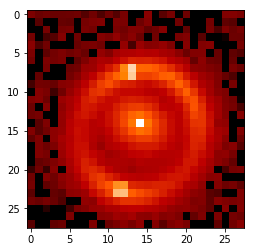

31
1.0535685297011383


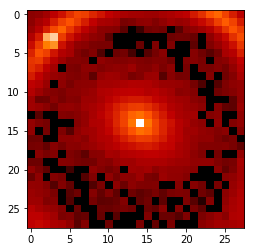

32
1.1549017191836752


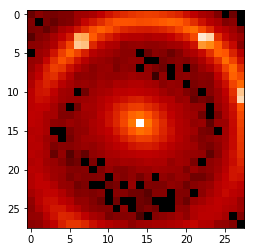

33
1.726561997060084


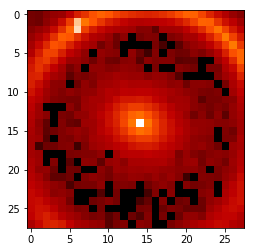

34
1.7881761417675226


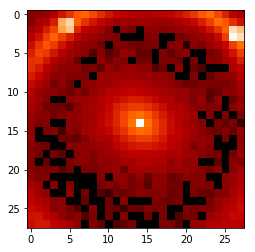

35
1.9442383318673908


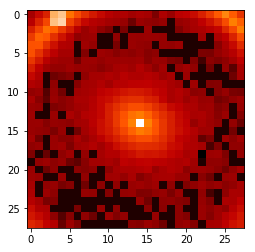

36
0.5862747375579033


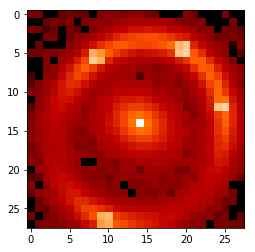

37
0.8751781667404834


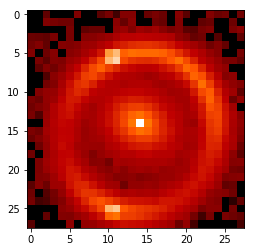

38
1.0691027735363015


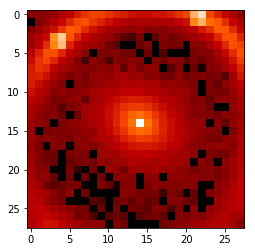

39
1.74740235381831


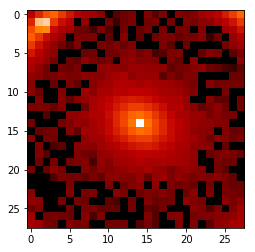

40
1.0515825298884


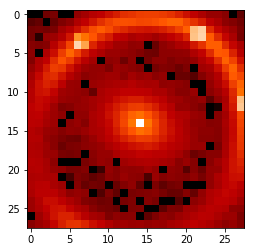

41
0.9153082060979472


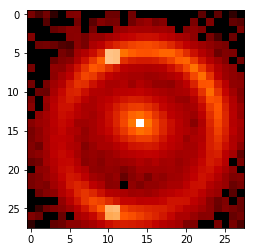

42
1.5872853426159605


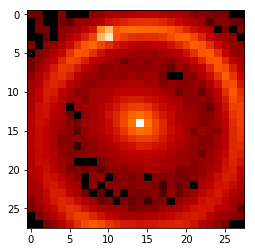

43
1.3444330418833625


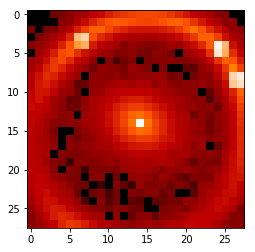

44
1.396859562937637


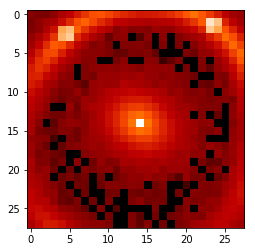

45
1.120163234402611


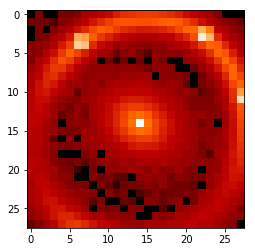

46
1.30420197485183


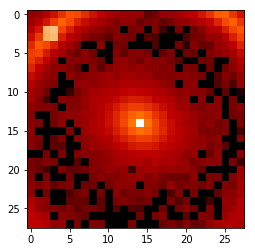

47
1.095248773279857


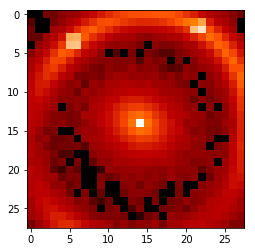

48
1.2839687498740302


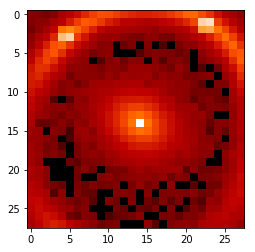

49
1.3376591735058367


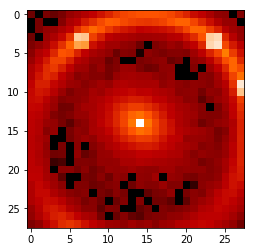

50
0.9839118149454225


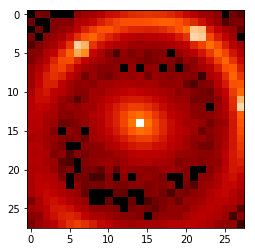

51
1.0178719548942161


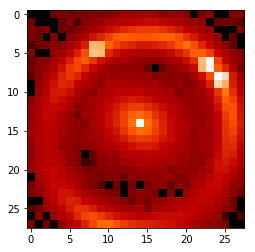

52
1.3537967060442153


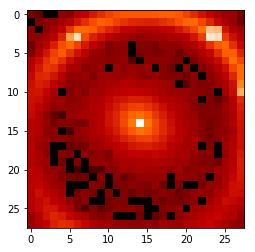

53
0.9681860045890135


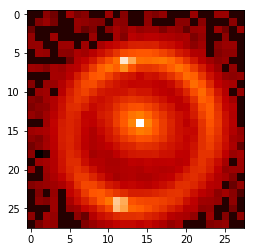

54
0.7808138406872256


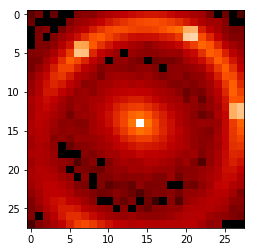

55
0.21825688945492194


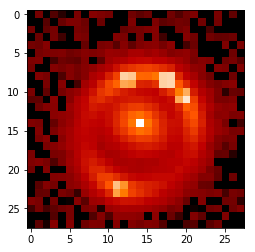

56
0.5411953417972537


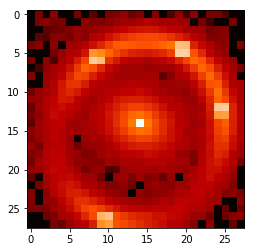

57
0.6240702434423345


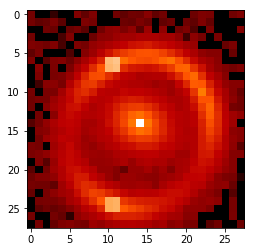

58
1.9159518627032062


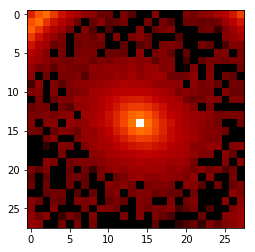

59
1.0434434791975291


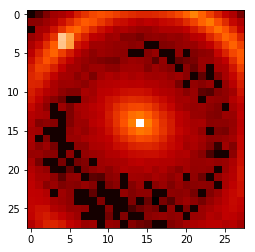

60
0.9839217489169724


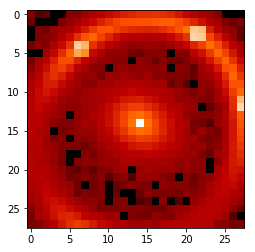

61
1.327934546516588


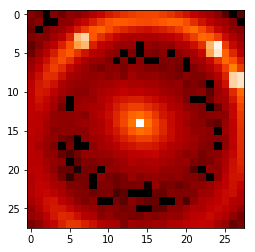

62
1.6425101665896171


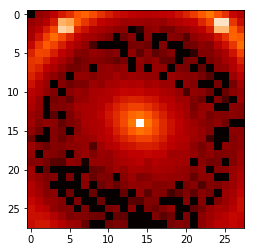

63
0.6164662292817993


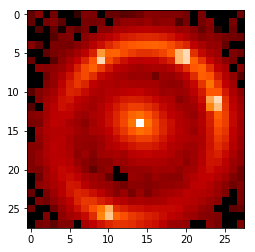

64
1.8305667904674898


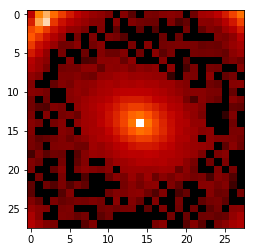

65
1.6377425105705883


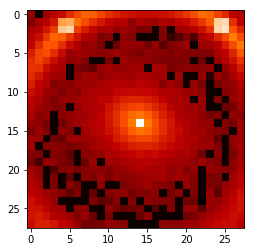

66
1.6765501515155947


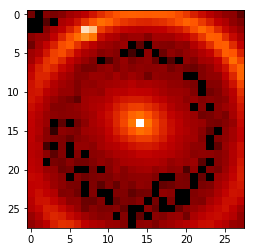

67
1.8035785129270052


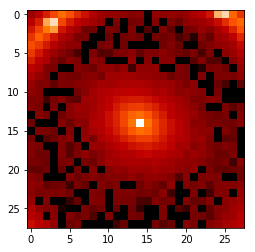

68
2.192145838344787


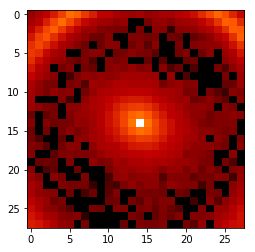

69
1.294604987390509


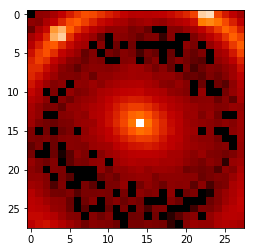

70
1.8094692766349665


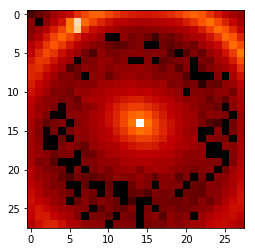

71
1.2715385525987515


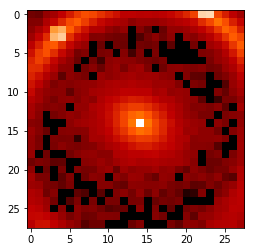

72
0.9175568028224752


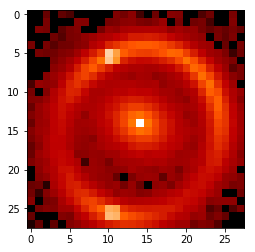

73
0.7730328226236403


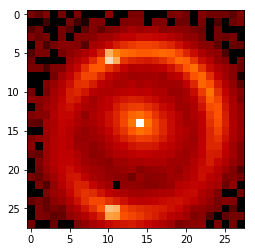

74
0.7867653164550721


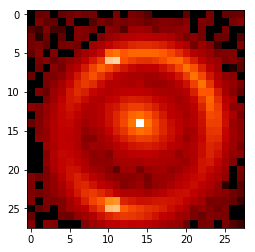

75
1.7039249717582856


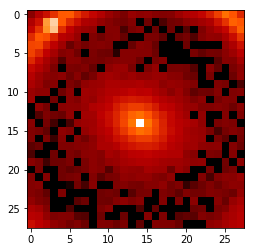

76
1.3553452016994763


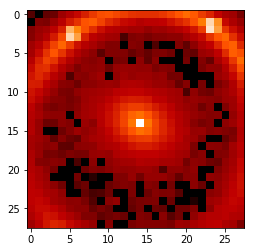

77
1.430876911896601


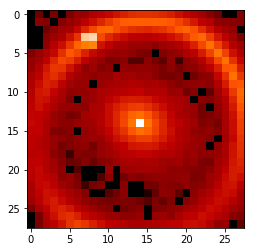

78
1.1336798402315695


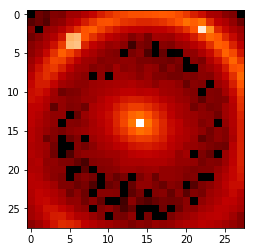

79
1.1140558094295092


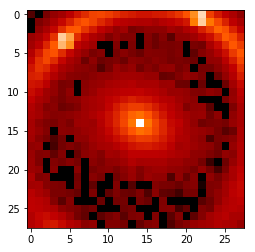

80
0.9058120616139773


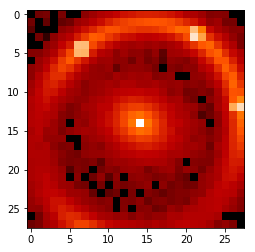

81
0.9195048529645655


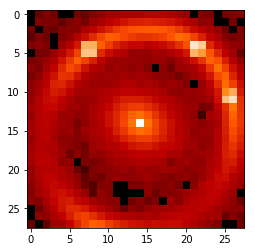

82
1.5454122449844572


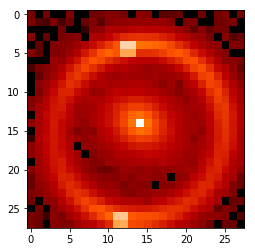

83
1.9308639139083539


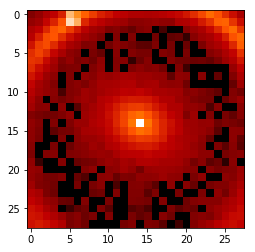

84
0.8596901502773979


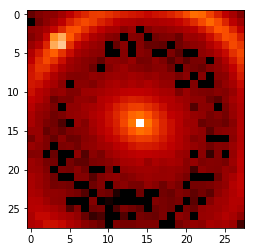

85
1.5886587349450934


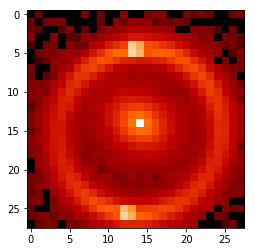

86
1.5824935409438314


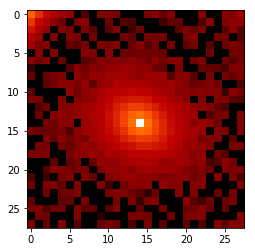

87
1.5878416438908678


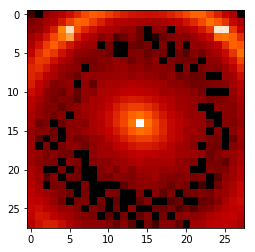

88
0.7370161624886716


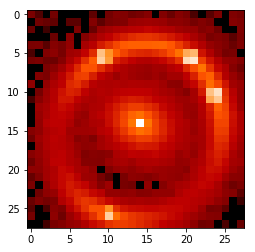

89
0.5007580646853261


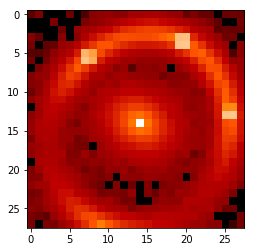

90
1.1932328657046605


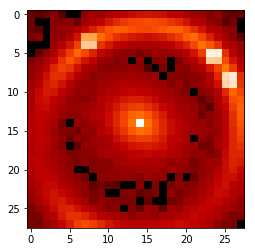

91
1.067408841729813


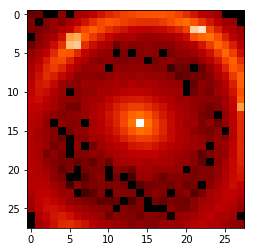

92
1.4540147441843343


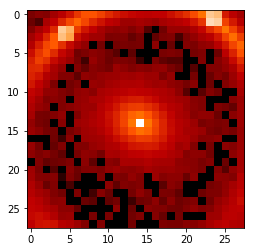

93
1.2086632340163557


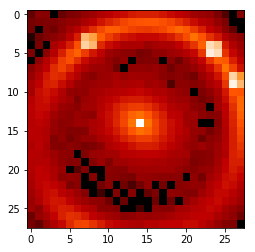

94
1.8317660818252195


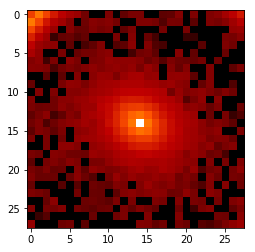

95
1.1607694723721016


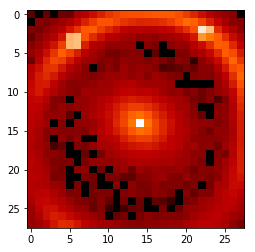

96
0.7334957656269097


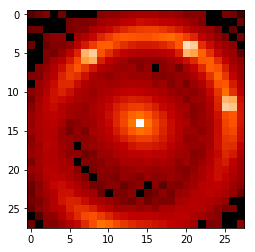

97
1.2193505530572573


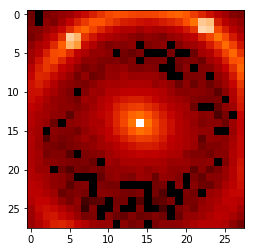

98
0.9580805285675605


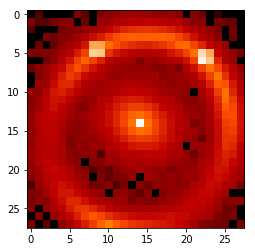

99
0.8692221748688658


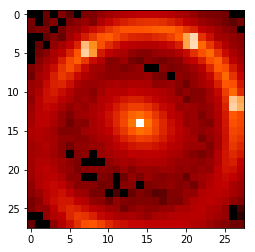

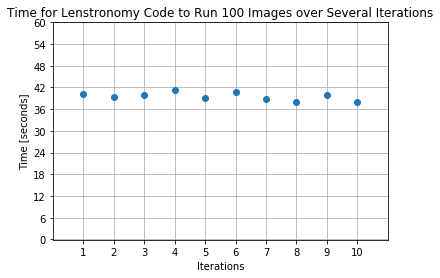

In [113]:
import datetime
timeArray = []
size = 100
itera = 10
overEst = 60
for j in range(itera):
  firstTime = datetime.datetime.now()
  rand = np.random.normal(1.25, 0.41, size)
  rand2 = np.random.normal(1.25, 0.41, size)
  gen = Simlens(0,0,.9,.4,2,.5,.1,-.5,[0.5, 0.5, 0.1],1.5, 0.05, 0.05, 2., 0.1, 0, 0.01, -1.0)
  print(Simlens.redshift_list)
  for i in range(size):
    print(i)
    sis_theta_E = rand[i]
    spep_theta_E = rand2[i]
    print(sis_theta_E)
    out = np.log10(gen.image_gen(sis_theta_E, spep_theta_E))
    for i in range(len(out)):
      for j in range(len(out)):
        if math.isnan(out[i][j]):
          out[i][j] = -5
    plt.imshow(out, cmap='gist_heat')
    plt.show()
  newTime = datetime.datetime.now()
  deltaTime = newTime-firstTime
  deltaTime = deltaTime.seconds + round((deltaTime.microseconds / (10**6)), 6)
  timeArray.append(deltaTime)
ticks = []
for i in range(itera):
  ticks.append(i+1)
y_ticks = []
for i in range(11):
  y_ticks.append(i * (overEst / 10))
plt.plot(ticks, timeArray, 'o')
plt.yticks(y_ticks)
plt.ylim([-0.1, overEst])
plt.xticks(ticks)
plt.xlim([0, itera+1])
plt.grid()
plt.xlabel('Iterations');
plt.ylabel('Time [seconds]');
plt.title('Time for Lenstronomy Code to Run 100 Images over Several Iterations');
plt.show()